## Домашнее задание: Разработка рекомендательной системы для музыки на платформе Spotify

1. Предобработка данных и EDA

Необходимо провести анализ данных (Exploratory Data Analysis, EDA) для понимания структуры датасетов и подготовки данных к разработке рекомендательной системы: 
- Загрузка данных и очистка выбросов
- Рассчитайте основные статистики для числовых колонок: среднее, медиану, стандартное отклонение, минимумы и максимумы.
- Проведите корреляционный анализ между различными признаками (например, между valence, energy, danceability и другими признаками).
- Постройте гистограммы и коробочные диаграммы для визуализации распределений числовых признаков.
- Анализ категориальных данных
- Постройте тепловую карту корреляции между признаками.

2. Разработка рекомендательной системы (Контентная фильтрация)

В этой части задания необходимо разработать рекомендательную систему, которая будет основывать свои рекомендации на характеристиках самих песен.

- Построение модели на основе контента. Используйте признаки, чтобы рекомендовать похожие песни по жанрам и стилю.
- Проведите кластеризацию для улучшения рекомендация на основе признаков с использованием алгоритмов, таких как K-means или DBSCAN. Рекомендуйте песни, которые находятся в одном кластере с уже выбранной песней.

3. Построение гибридной модели

    Разработайте гибридную рекомендательную систему, которая сочетает контентную фильтрацию и методы кластеризации признаков. Таким образом, рекомендации могут быть основаны как на схожести признаков, так и на принадлежности песен к определённым группам (кластерам).

4. Оценка качества модели

После того как модели будут построены, необходимо провести их оценку.

- Придумайте метрику для оценки качества на тренировочных данных.
- Создайте свой валидационный набор в группе студентов. Каждому из студентов необходимо выбрать по 30 песен, которые ему нравятся. Желательно разных исполнителей. Объедините данные в группе и создайте единый набор.
- Оцените свою модель с помощью метрик precision/recall at K на разных параметрах и объясните полученный результат. 

In [1]:
import sys
import os
import pandas as pd
import numpy as np
from scipy import sparse
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
import plotly.express as px 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import warnings
from collections import defaultdict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN  
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from sklearn.exceptions import DataConversionWarning
from sklearn.cluster import MiniBatchKMeans

Загрузка датасетов

In [2]:
# Загрузка датасетов
df = pd.read_csv('data/data.csv')
data_by_artist = pd.read_csv('data/data_by_artist.csv')
data_by_genres = pd.read_csv('data/data_by_genres.csv')
data_by_year = pd.read_csv('data/data_by_year.csv')
data_w_genres = pd.read_csv('data/data_w_genres.csv')

### 1. Проведем анализ основного датасета df

In [3]:
df.head()

valence  year  acousticness  \
0   0.0594  1921         0.982   
1   0.9630  1921         0.732   
2   0.0394  1921         0.961   
3   0.1650  1921         0.967   
4   0.2530  1921         0.957   

                                             artists  danceability  \
0  ['Sergei Rachmaninoff', 'James Levine', 'Berli...         0.279   
1                                     ['Dennis Day']         0.819   
2  ['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...         0.328   
3                                   ['Frank Parker']         0.275   
4                                     ['Phil Regan']         0.418   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       831667   0.211         0  4BJqT0PrAfrxzMOxytFOIz          0.878000   
1       180533   0.341         0  7xPhfUan2yNtyFG0cUWkt8          0.000000   
2       500062   0.166         0  1o6I8BglA6ylDMrIELygv1          0.913000   
3       210000   0.309         0  3ftBPsC5vPBKxYSee08FDH          0.000028   
4       166693   0.193         0  4d6HGyGT8e121BsdKmw9v6          0.000002   

   key  liveness  loudness  mode  \
0   10     0.665   -20.096     1   
1    7     0.160   -12.441     1   
2    3     0.101   -14.850     1   
3    5     0.381    -9.316     1   
4    3     0.229   -10.096     1   

                                                name  popularity release_date  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4         1921   
1                            Clancy Lowered the Boom           5         1921   
2                                          Gati Bali           5         1921   
3                                          Danny Boy           3         1921   
4                        When Irish Eyes Are Smiling           2         1921   

   speechiness    tempo  
0       0.0366   80.954  
1       0.4150   60.936  
2       0.0339  110.339  
3       0.0354  100.109  
4       0.0380  101.665

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [5]:
# Проверка числовых и нечисловых колонок
numeric_columns = df.select_dtypes(include=[np.number]).columns
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns

print(f"\nЧисловые колонки:\n{numeric_columns.tolist()}")
print(f"\nНечисловые колонки:\n{non_numeric_columns.tolist()}")


Числовые колонки:
['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']

Нечисловые колонки:
['artists', 'id', 'name', 'release_date']


In [6]:
# Убедимся, что все значения числовых колонок корректны
df_numeric = df[numeric_columns]
df_numeric

valence  year  acousticness  danceability  duration_ms  energy  \
0        0.0594  1921       0.98200         0.279       831667   0.211   
1        0.9630  1921       0.73200         0.819       180533   0.341   
2        0.0394  1921       0.96100         0.328       500062   0.166   
3        0.1650  1921       0.96700         0.275       210000   0.309   
4        0.2530  1921       0.95700         0.418       166693   0.193   
...         ...   ...           ...           ...          ...     ...   
170648   0.6080  2020       0.08460         0.786       301714   0.808   
170649   0.7340  2020       0.20600         0.717       150654   0.753   
170650   0.6370  2020       0.10100         0.634       211280   0.858   
170651   0.1950  2020       0.00998         0.671       337147   0.623   
170652   0.6420  2020       0.13200         0.856       189507   0.721   

        explicit  instrumentalness  key  liveness  loudness  mode  popularity  \
0              0          0.878000   10    0.6650   -20.096     1           4   
1              0          0.000000    7    0.1600   -12.441     1           5   
2              0          0.913000    3    0.1010   -14.850     1           5   
3              0          0.000028    5    0.3810    -9.316     1           3   
4              0          0.000002    3    0.2290   -10.096     1           2   
...          ...               ...  ...       ...       ...   ...         ...   
170648         0          0.000289    7    0.0822    -3.702     1          72   
170649         0          0.000000    7    0.1010    -6.020     1          68   
170650         0          0.000009    4    0.2580    -2.226     0          76   
170651         1          0.000008    2    0.6430    -7.161     1          70   
170652         1          0.004710    7    0.1820    -4.928     1          74   

        speechiness    tempo  
0            0.0366   80.954  
1            0.4150   60.936  
2            0.0339  110.339  
3            0.0354  100.109  
4            0.0380  101.665  
...             ...      ...  
170648       0.0881  105.029  
170649       0.0605  137.936  
170650       0.0809   91.688  
170651       0.3080   75.055  
170652       0.1080   94.991  

[170653 rows x 15 columns]

In [7]:
# Очистка выбросов
# почистим датасет от слишком длинных песен (возможно это записи текстов писателей, типа Хэмингуэя) и других аномалий
def remove_outliers(df, threshold=3):
    """Удаление выбросов на основе Z-score."""
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    z_scores = np.abs((df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std())
    df_clean = df[(z_scores < threshold).all(axis=1)]
    return df_clean

cleaned_df = remove_outliers(df)

print(f"\nРазмер датасета до очистки: {df.shape}")
print(f"Размер датасета после очистки: {cleaned_df.shape}")


Размер датасета до очистки: (170653, 19)
Размер датасета после очистки: (145847, 19)


In [8]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145847 entries, 1 to 170650
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           145847 non-null  float64
 1   year              145847 non-null  int64  
 2   acousticness      145847 non-null  float64
 3   artists           145847 non-null  object 
 4   danceability      145847 non-null  float64
 5   duration_ms       145847 non-null  int64  
 6   energy            145847 non-null  float64
 7   explicit          145847 non-null  int64  
 8   id                145847 non-null  object 
 9   instrumentalness  145847 non-null  float64
 10  key               145847 non-null  int64  
 11  liveness          145847 non-null  float64
 12  loudness          145847 non-null  float64
 13  mode              145847 non-null  int64  
 14  name              145847 non-null  object 
 15  popularity        145847 non-null  int64  
 16  release_date      145847 

In [9]:
# Основные статистики
numeric_cols = cleaned_df.select_dtypes(include=[np.number]).columns
cleaned_df[numeric_cols].describe()

valence           year   acousticness   danceability  \
count  145847.000000  145847.000000  145847.000000  145847.000000   
mean        0.539076    1975.848238       0.523157       0.529441   
std         0.265405      24.754046       0.374825       0.169666   
min         0.000000    1921.000000       0.000000       0.056900   
25%         0.323000    1956.000000       0.122000       0.412000   
50%         0.551000    1976.000000       0.569000       0.539000   
75%         0.764500    1996.000000       0.907000       0.652000   
max         1.000000    2020.000000       0.996000       0.988000   

         duration_ms         energy  explicit  instrumentalness  \
count  145847.000000  145847.000000  145847.0     145847.000000   
mean   223423.945155       0.477982       0.0          0.173345   
std     83757.837707       0.263374       0.0          0.316745   
min     16416.000000       0.000240       0.0          0.000000   
25%    171200.000000       0.258000       0.0          0.000001   
50%    206187.000000       0.460000       0.0          0.000386   
75%    259235.000000       0.693000       0.0          0.132000   
max    609177.000000       1.000000       0.0          0.999000   

                 key       liveness       loudness           mode  \
count  145847.000000  145847.000000  145847.000000  145847.000000   
mean        5.184214       0.183993     -11.313826       0.720227   
std         3.489983       0.133768       5.138180       0.448889   
min         0.000000       0.009670     -28.554000       0.000000   
25%         2.000000       0.097100     -14.340000       0.000000   
50%         5.000000       0.130000     -10.685000       1.000000   
75%         8.000000       0.237000      -7.405000       1.000000   
max        11.000000       0.730000       3.744000       1.000000   

          popularity    speechiness          tempo  
count  145847.000000  145847.000000  145847.000000  
mean       30.880875       0.063607     117.197371  
std        21.098698       0.063067      30.229485  
min         0.000000       0.022200      30.946000  
25%        12.000000       0.034000      94.173000  
50%        33.000000       0.042500     115.121000  
75%        47.000000       0.062400     135.335500  
max        96.000000       0.585000     208.959000

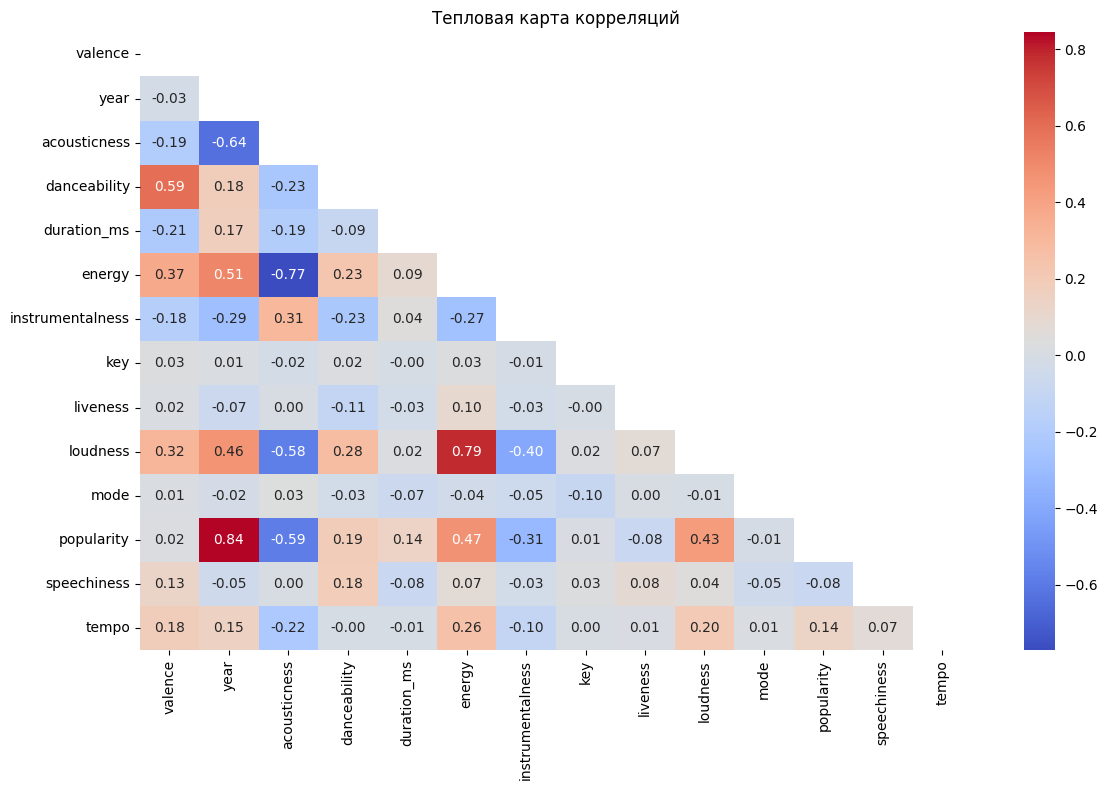

In [10]:
# Корреляционный анализ
# исключим explicit перед посторением матрицы корреляции, так как в нем булевы значения 
numeric_cols = [col for col in numeric_cols if col != 'explicit']

correlation_matrix = cleaned_df[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)))
plt.title("Тепловая карта корреляций")
plt.tight_layout()
plt.show()

In [11]:
correlation_matrix

valence      year  acousticness  danceability  duration_ms  \
valence           1.000000 -0.025164     -0.193565      0.593473    -0.210329   
year             -0.025164  1.000000     -0.637706      0.180317     0.168835   
acousticness     -0.193565 -0.637706      1.000000     -0.231303    -0.187537   
danceability      0.593473  0.180317     -0.231303      1.000000    -0.093801   
duration_ms      -0.210329  0.168835     -0.187537     -0.093801     1.000000   
energy            0.373749  0.512615     -0.771542      0.231661     0.090530   
instrumentalness -0.176680 -0.285374      0.306649     -0.225197     0.043928   
key               0.026301  0.012769     -0.022514      0.023042    -0.003585   
liveness          0.016648 -0.068509      0.001488     -0.106948    -0.031112   
loudness          0.315449  0.464776     -0.581838      0.276576     0.020198   
mode              0.013736 -0.015467      0.033893     -0.028408    -0.070630   
popularity        0.019142  0.843943     -0.588421      0.189848     0.142522   
speechiness       0.126981 -0.047756      0.003259      0.181781    -0.079172   
tempo             0.177547  0.146512     -0.216313     -0.004587    -0.006533   

                    energy  instrumentalness       key  liveness  loudness  \
valence           0.373749         -0.176680  0.026301  0.016648  0.315449   
year              0.512615         -0.285374  0.012769 -0.068509  0.464776   
acousticness     -0.771542          0.306649 -0.022514  0.001488 -0.581838   
danceability      0.231661         -0.225197  0.023042 -0.106948  0.276576   
duration_ms       0.090530          0.043928 -0.003585 -0.031112  0.020198   
energy            1.000000         -0.267291  0.029119  0.097472  0.786017   
instrumentalness -0.267291          1.000000 -0.012581 -0.028488 -0.403150   
key               0.029119         -0.012581  1.000000 -0.004238  0.021019   
liveness          0.097472         -0.028488 -0.004238  1.000000  0.069037   
loudness          0.786017         -0.403150  0.021019  0.069037  1.000000   
mode             -0.037127         -0.053386 -0.096043  0.000287 -0.006764   
popularity        0.465413         -0.311770  0.010353 -0.080645  0.428474   
speechiness       0.067930         -0.032086  0.025448  0.083508  0.043655   
tempo             0.255860         -0.102690  0.004342  0.005527  0.204745   

                      mode  popularity  speechiness     tempo  
valence           0.013736    0.019142     0.126981  0.177547  
year             -0.015467    0.843943    -0.047756  0.146512  
acousticness      0.033893   -0.588421     0.003259 -0.216313  
danceability     -0.028408    0.189848     0.181781 -0.004587  
duration_ms      -0.070630    0.142522    -0.079172 -0.006533  
energy           -0.037127    0.465413     0.067930  0.255860  
instrumentalness -0.053386   -0.311770    -0.032086 -0.102690  
key              -0.096043    0.010353     0.025448  0.004342  
liveness          0.000287   -0.080645     0.083508  0.005527  
loudness         -0.006764    0.428474     0.043655  0.204745  
mode              1.000000   -0.012082    -0.048121  0.011003  
popularity       -0.012082    1.000000    -0.077434  0.135569  
speechiness      -0.048121   -0.077434     1.000000  0.065625  
tempo             0.011003    0.135569     0.065625  1.000000

выводы: 
1. Высокая корреляция между year и popularity (0.84), более новые треки, как правило, более популярны. Это может отражать современные тренды или влияние алгоритмов стриминговых платформ.
2. Отрицательные значения между acousticness и energy (-0.77), кустические треки обычно менее энергетичны, что логично, так как электронная/синтезированная музыка чаще ассоциируется с высокой энергией.
3. Положительная корреляция между energy и loudness (0.79), чем громче трек (выше loudness), тем он воспринимается как более энергичный.
4. Умеренная отрицательная связь между acousticness и year (-0.64), означает что со временем доля акустических треков уменьшается, что согласуется с ростом популярности электронной и хип-хоп музыки.
5. Для прогнозирования популярности можно сфокусироваться на year, acousticness, energy и loudness.


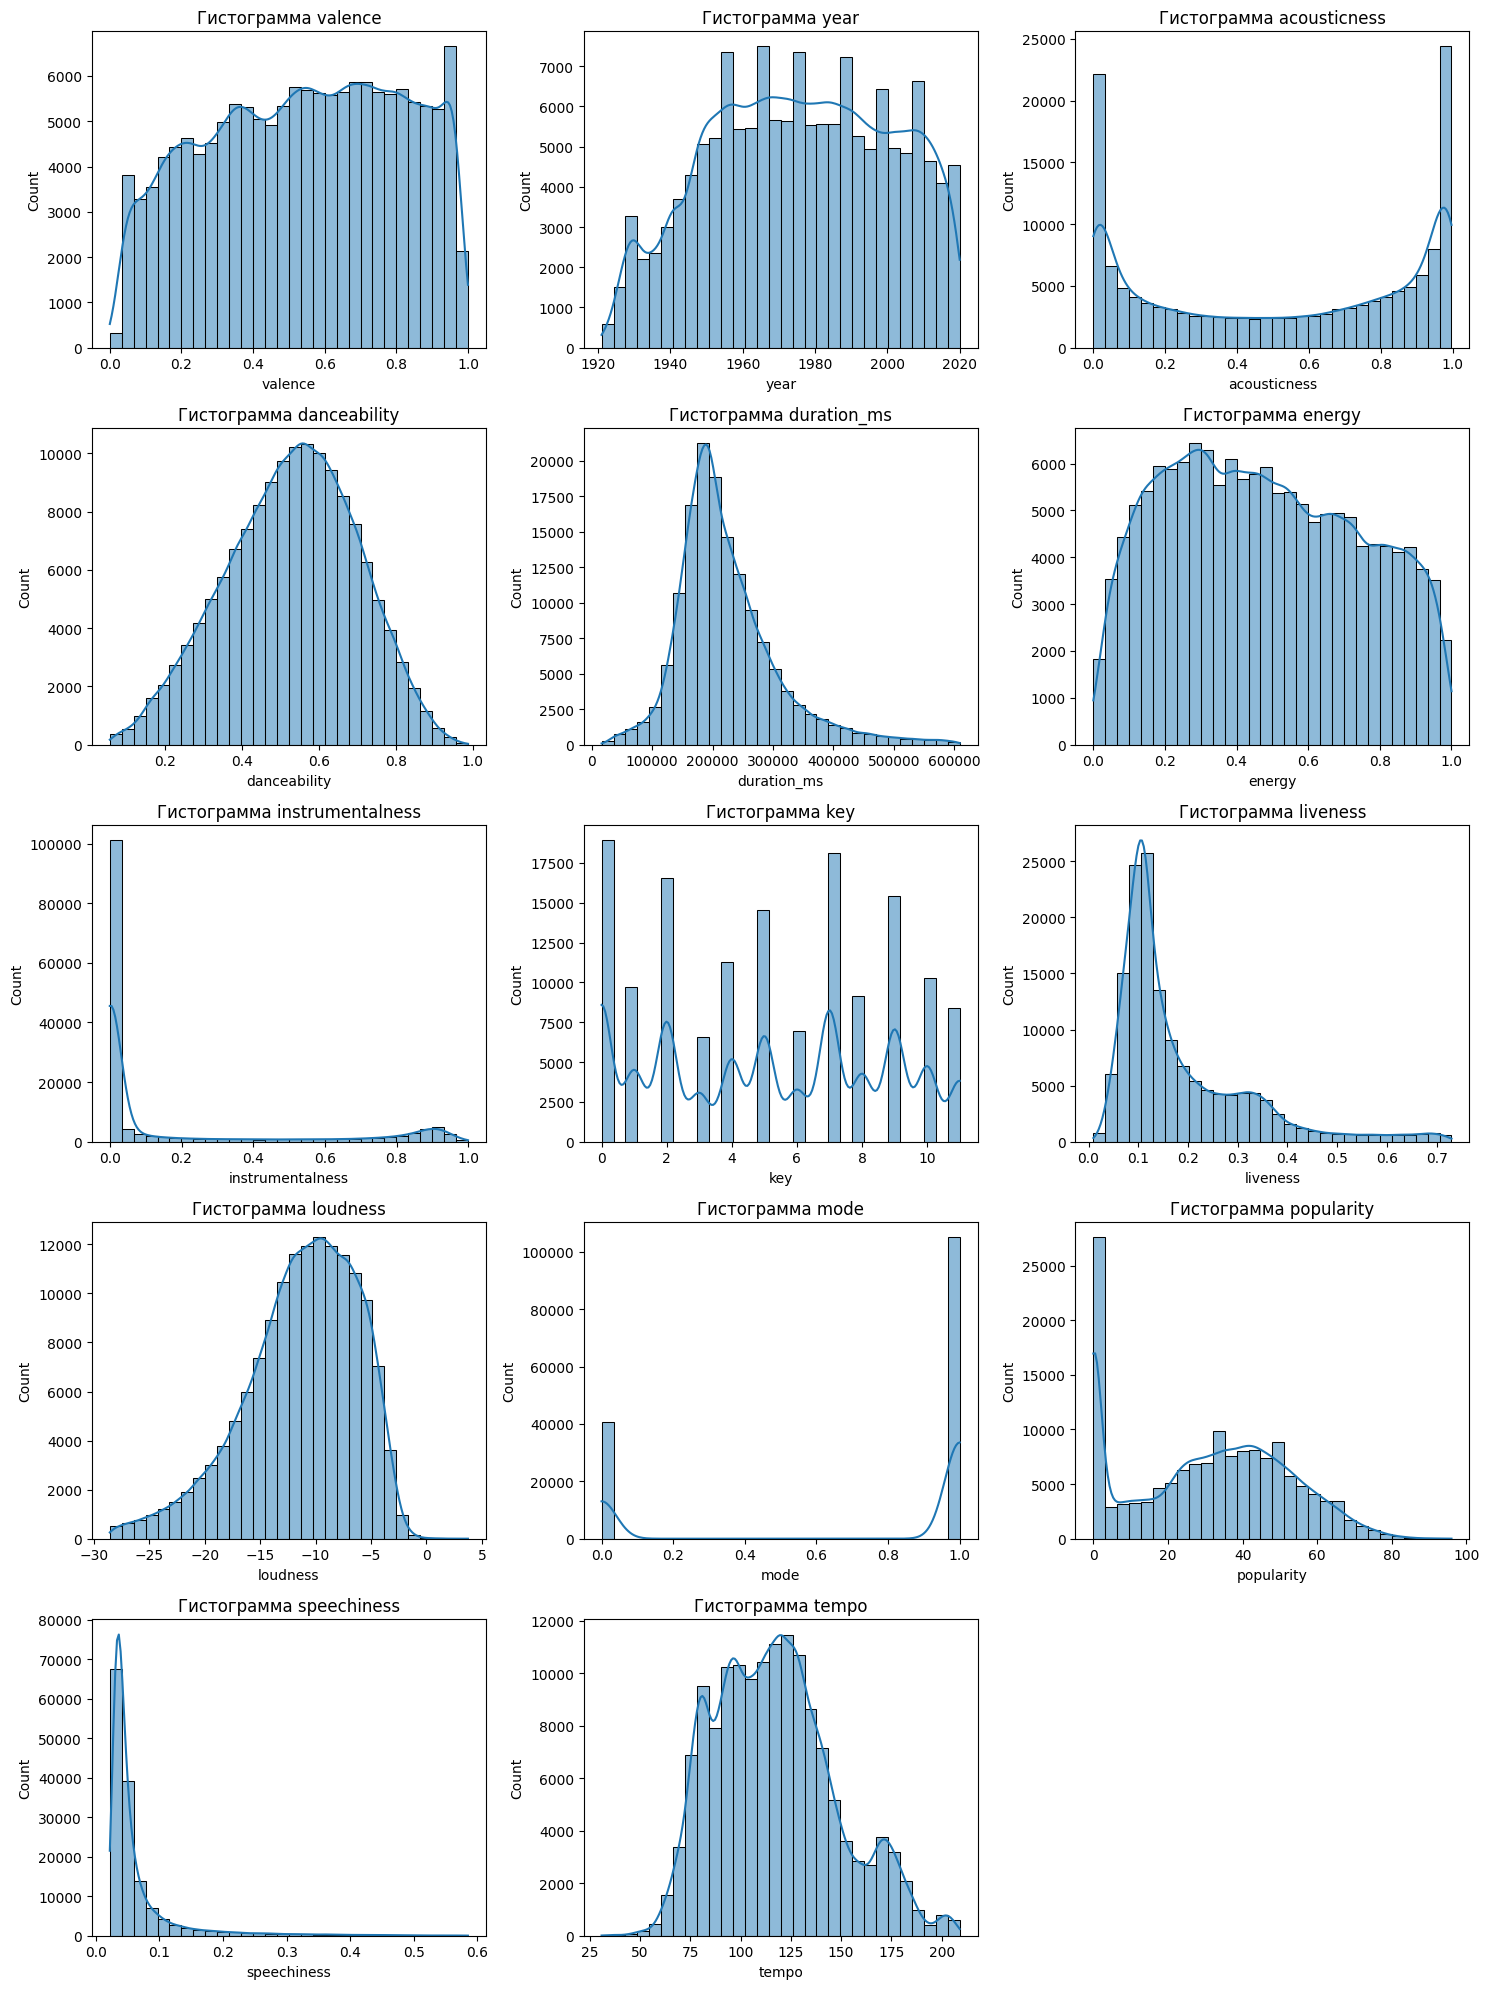

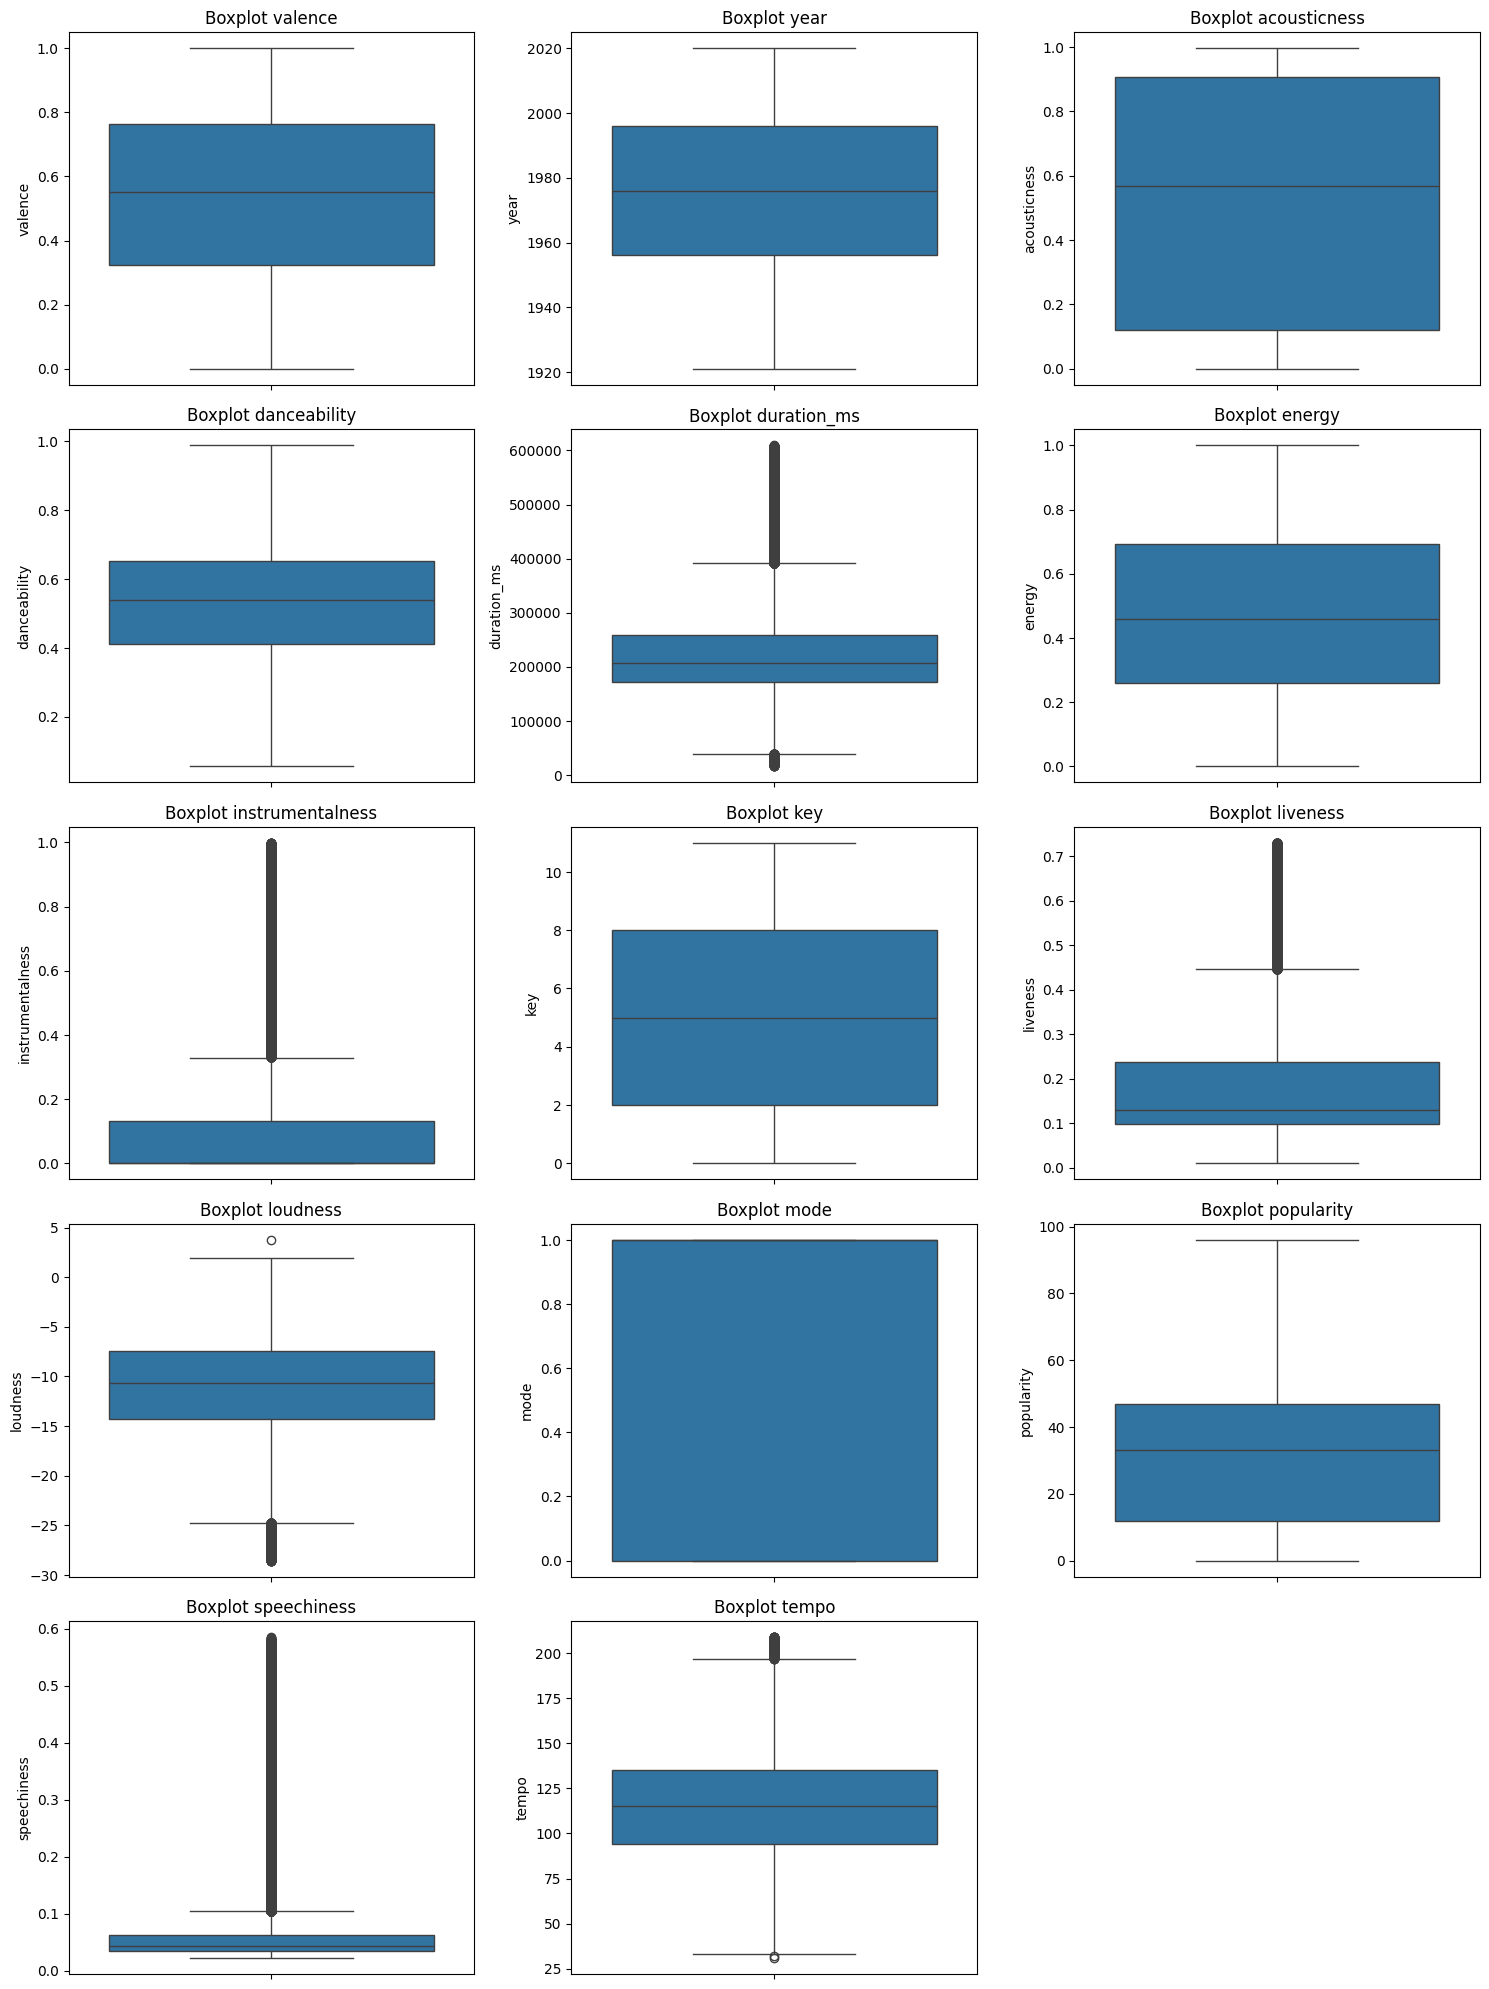

In [12]:
# Визуализация распределений

def plot_distributions(df, numeric_cols):
    """Гистограммы и boxplots для числовых колонок."""
    plt.figure(figsize=(15, 20))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(len(numeric_cols) // 3 + 1, 3, i)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"Гистограмма {col}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 20))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(len(numeric_cols) // 3 + 1, 3, i)
        sns.boxplot(y=df[col])
        plt.title(f"Boxplot {col}")
    plt.tight_layout()
    plt.show()

plot_distributions(cleaned_df, numeric_cols)



Анализ категориальной переменной: artists
artists
['Francisco Canaro']              920
['Ignacio Corsini']               599
['Frank Sinatra']                 589
['Elvis Presley']                 474
['Johnny Cash']                   443
['The Beach Boys']                441
['Francisco Canaro', 'Charlo']    437
['The Rolling Stones']            434
['Dean Martin']                   420
['Bob Dylan']                     396
Name: count, dtype: int64


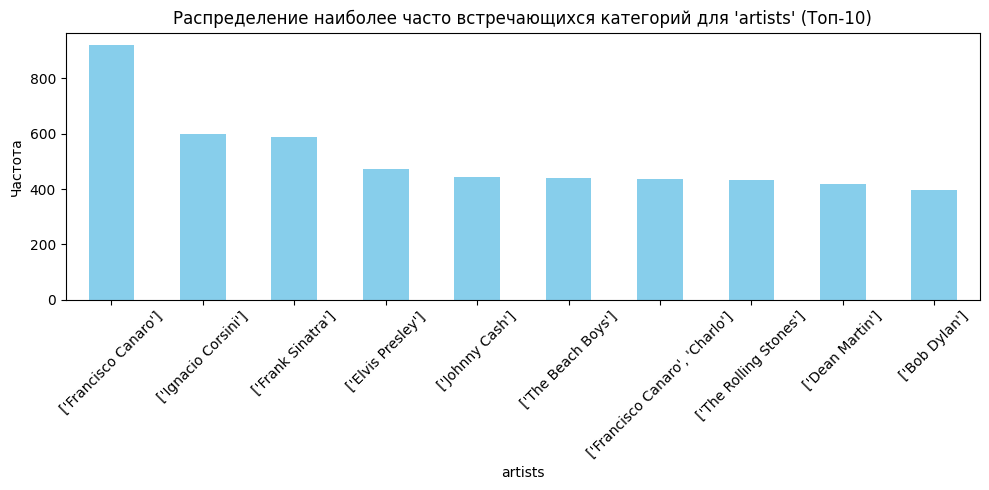


Анализ категориальной переменной: name
name
White Christmas       73
Winter Wonderland     63
Jingle Bells          51
Summertime            51
Overture              45
Silent Night          43
Home                  39
Silver Bells          36
The Christmas Song    35
Sleigh Ride           34
Name: count, dtype: int64


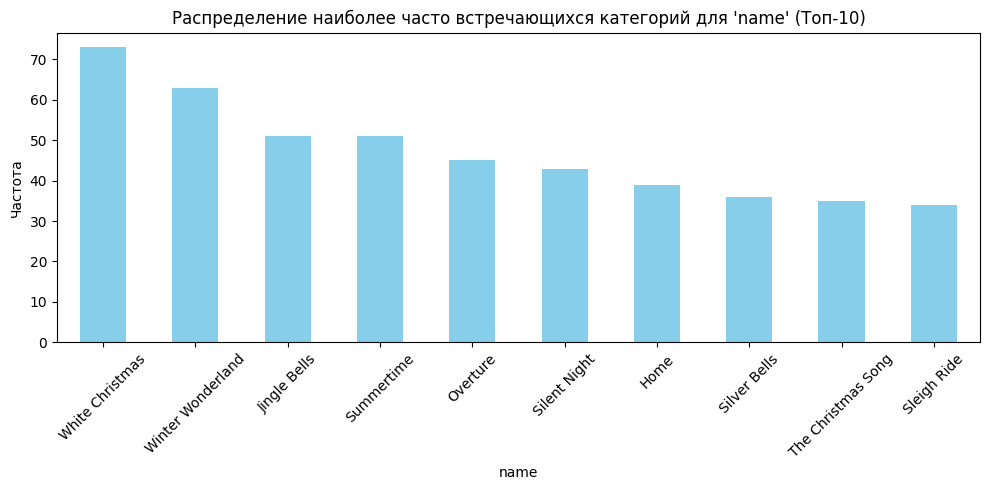


Анализ категориальной переменной: release_date
release_date
1949          1069
1930-01-01     988
1940-01-01     976
1956           878
1946           842
1948           839
1951           828
1950-01-01     813
1945           797
1972           791
Name: count, dtype: int64


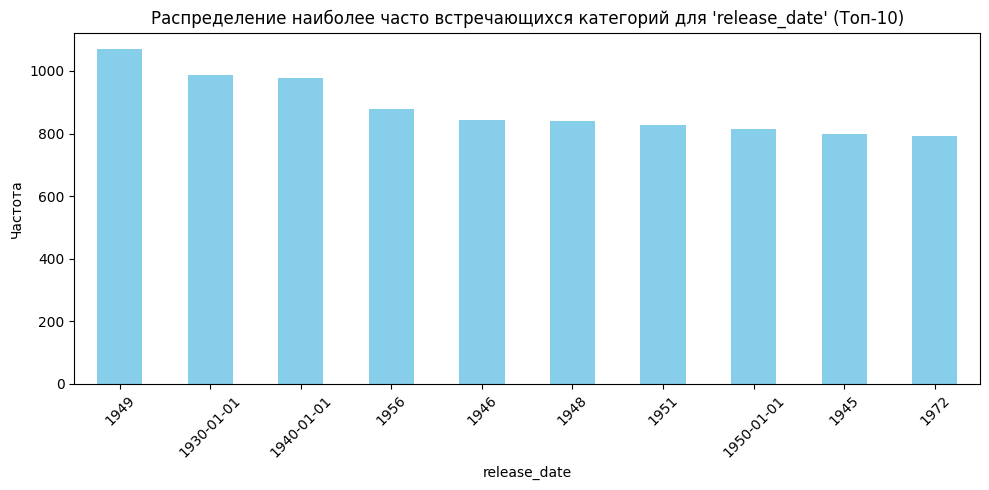

In [13]:
# Анализ категориальных данных 

categorical_cols = cleaned_df.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols[categorical_cols != "id"]  # Исключаем колонку 'id'

def analyze_categorical(df, categorical_cols):
    """Анализ категориальных данных."""
    for col in categorical_cols:
        print(f"\nАнализ категориальной переменной: {col}")
        value_counts = df[col].value_counts().head(10)
        print(value_counts)
        
        # Визуализация топ-10 категорий
        plt.figure(figsize=(10, 5))
        value_counts.plot(kind='bar', color='skyblue')
        plt.title(f"Распределение наиболее часто встречающихся категорий для '{col}' (Топ-10)")
        plt.ylabel("Частота")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

analyze_categorical(cleaned_df, categorical_cols)


Анализ категории 'artists' по популярности:

Топ-10 самых популярных:
artists
['Sech', 'Daddy Yankee', 'J Balvin', 'ROSALÍA', 'Farruko']    94.0
['Joel Corry', 'MNEK']                                        94.0
['Ritt Momney']                                               93.0
['Lele Pons', 'Guaynaa']                                      92.0
['Topic', 'A7S']                                              92.0
['Manuel Turizo', 'Rauw Alejandro', 'Myke Towers']            92.0
['Jay Wheeler', 'DJ Nelson', 'Myke Towers']                   92.0
['J Balvin', 'Tainy', 'Dua Lipa', 'Bad Bunny']                92.0
['Ozuna', 'J Balvin', 'Chencho Corleone']                     91.0
['Maluma', 'Lenny Tavárez', 'Justin Quiles']                  91.0
Name: popularity, dtype: float64

Топ-10 наименее популярных:
artists
['Isaac Albéniz', 'Miguel Llobet Solés', 'María Luisa Anido']                                                                                                                        

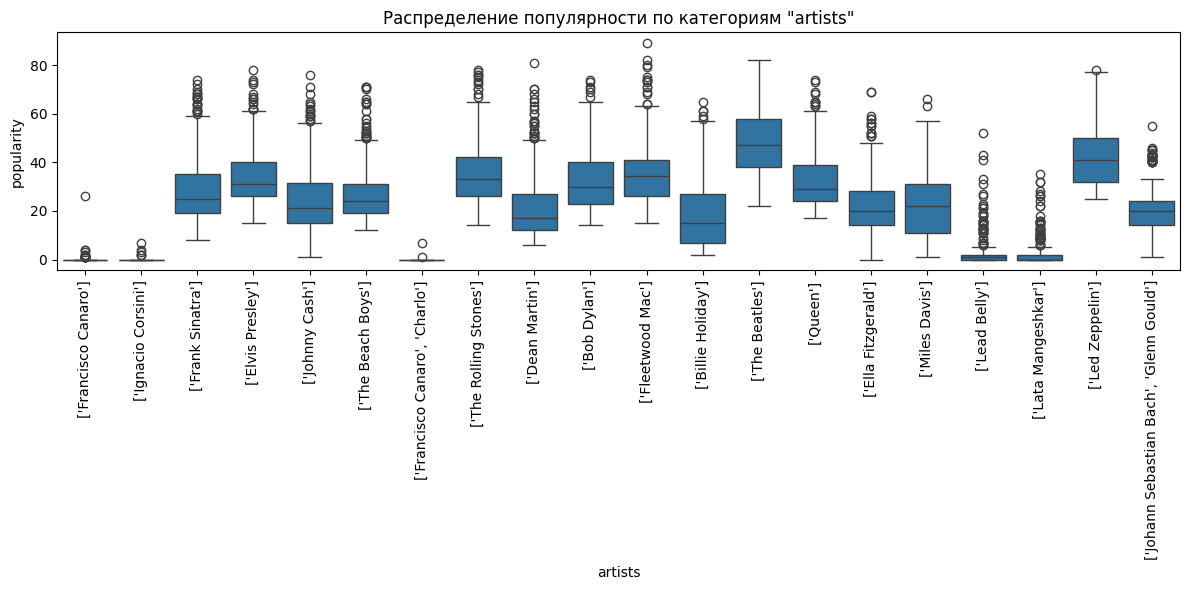


Анализ категории 'name' по популярности:

Топ-10 самых популярных:
name
Blinding Lights                   96.0
you broke me first                95.0
Holy (feat. Chance The Rapper)    95.0
Head & Heart (feat. MNEK)         94.0
Relación - Remix                  94.0
Therefore I Am                    93.0
Take You Dancing                  92.0
La Tóxica                         92.0
Breaking Me                       92.0
Se Te Nota (with Guaynaa)         92.0
Name: popularity, dtype: float64

Топ-10 наименее популярных:
name
Verdi : Luisa Miller : Act 2 "Quando le sere al placido" [ Rodolfo]                                                                 0.0
Verdi : Luisa Miller : Act 3 "Padre, ricevi l'estremo addio" [Luisa, Rodolfo, Miller, Chorus, Walter]                               0.0
Verdi : Luisa Miller : Act 3 "Piangi, piangi, il tuo dolore" [Luisa, Rodolfo]                                                       0.0
Verdi : Luisa Miller : Sinfonia to Act 1                      

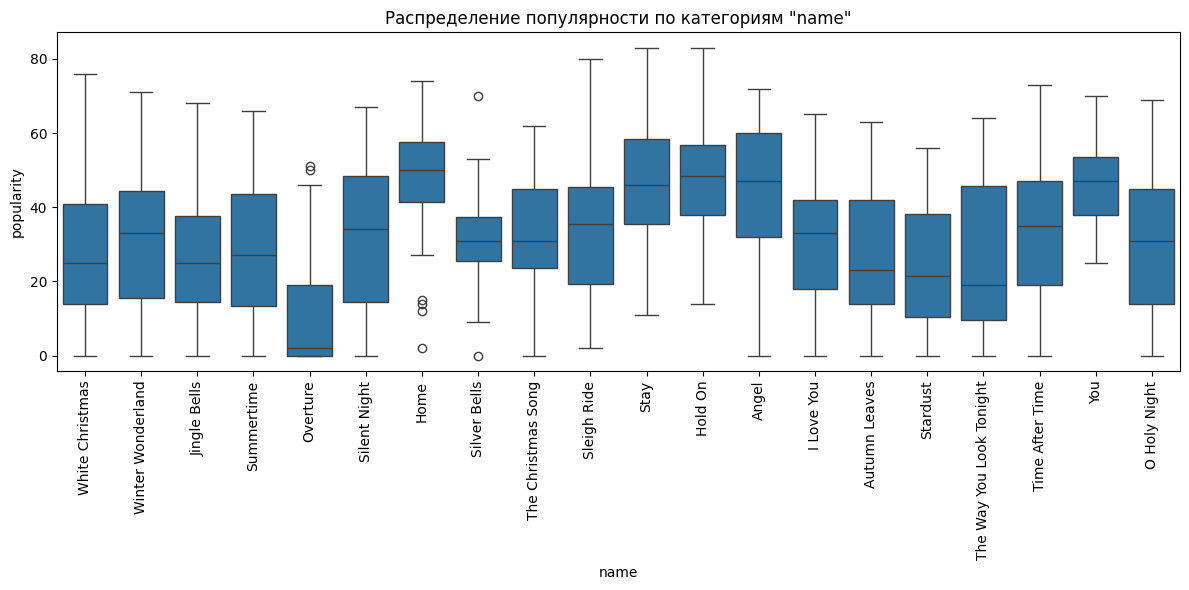


Анализ категории 'release_date' по популярности:

Топ-10 самых популярных:
release_date
2020-07-22    92.0
2020-10-08    92.0
2020-07-29    92.0
2020-02-08    90.0
2020-06-11    87.0
2019-11-19    86.0
2020-10-31    86.0
2020-05-21    85.0
2019-01-06    85.0
2020-09-21    85.0
Name: popularity, dtype: float64

Топ-10 наименее популярных:
release_date
1951-04-03    0.0
1942-11-09    0.0
1950-03-17    0.0
1942-10-02    0.0
1942-08-22    0.0
1942-08-18    0.0
1942-07-01    0.0
1942-06-25    0.0
2017-06-05    0.0
1942-06-06    0.0
Name: popularity, dtype: float64


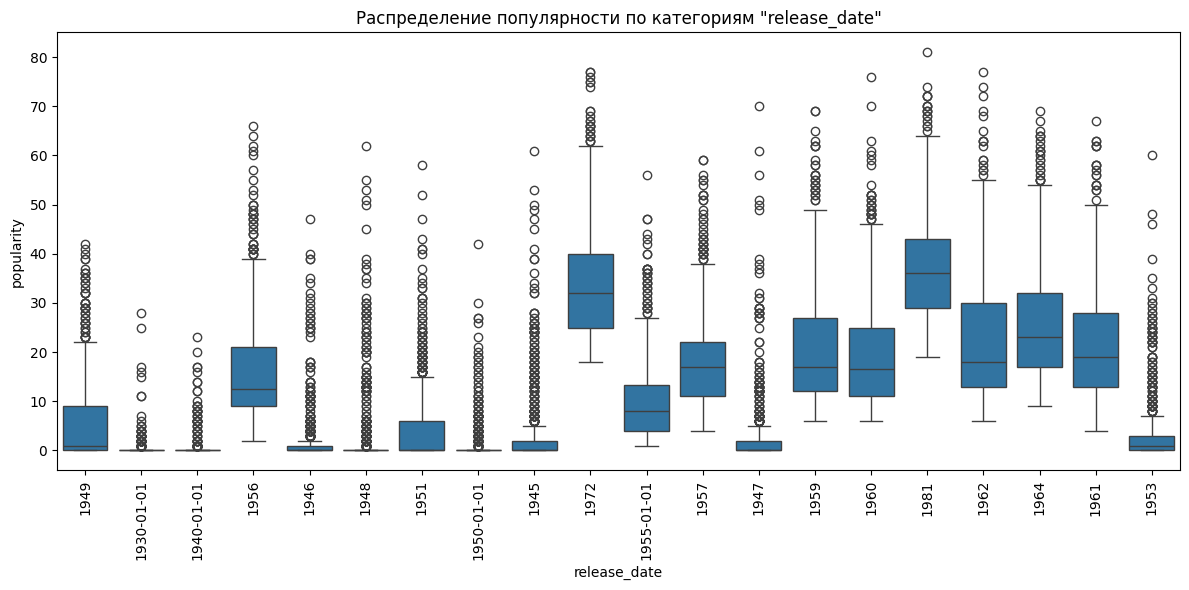

In [14]:
# Анализ категориальных данных по популярности
def analyze_categorical_by_popularity(df, categorical_cols, popularity_col='popularity'):
    """Анализ категориальных данных в разрезе популярности."""
    for col in categorical_cols:
        print(f"\nАнализ категории '{col}' по популярности:")
        
        # Топ-10 самых популярных категорий
        top_popular = df.groupby(col)[popularity_col].mean().sort_values(ascending=False).head(10)
        print("\nТоп-10 самых популярных:")
        print(top_popular)
        
        # Топ-10 наименее популярных категорий
        least_popular = df.groupby(col)[popularity_col].mean().sort_values().head(10)
        print("\nТоп-10 наименее популярных:")
        print(least_popular)
        
        # Визуализация распределения популярности
        plt.figure(figsize=(12, 6))
        
        # Берем топ-20 категорий для визуализации
        top_categories = df[col].value_counts().head(20).index
        filtered_df = df[df[col].isin(top_categories)]
        
        # Boxplot популярности по категориям
        sns.boxplot(
            x=col, 
            y=popularity_col, 
            data=filtered_df,
            order=top_categories
        )
        plt.title(f'Распределение популярности по категориям "{col}"')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

# Выбираем только категориальные колонки (исключая id)
categorical_cols = cleaned_df.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols[categorical_cols != "id"]

# Выполняем анализ
analyze_categorical_by_popularity(cleaned_df, categorical_cols)

In [15]:
# Функция для определения декады
def get_decade(year):
    """Определяет декаду по году."""
    period_start = (year // 10) * 10
    return f"{period_start}s"

# Создаем копию DataFrame
df_clean = cleaned_df.copy()

# Безопасное добавление столбца с декадой
df_clean['decade'] = df_clean['year'].apply(get_decade)

# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

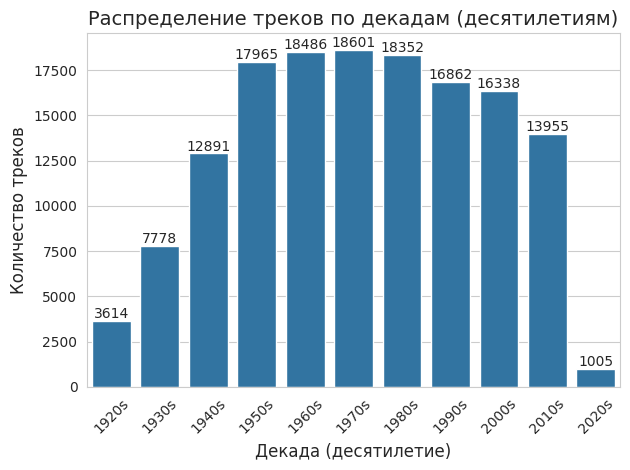

In [16]:
#  Количество треков по декадам
ax = sns.countplot(
    data=df_clean, 
    x='decade', 
    order=sorted(df_clean['decade'].unique())
)
plt.title('Распределение треков по декадам (десятилетиям)', fontsize=14)
plt.xlabel('Декада (десятилетие)', fontsize=12)
plt.ylabel('Количество треков', fontsize=12)
plt.xticks(rotation=45)

# Добавляем подписи
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', 
        xytext=(0, 5), 
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

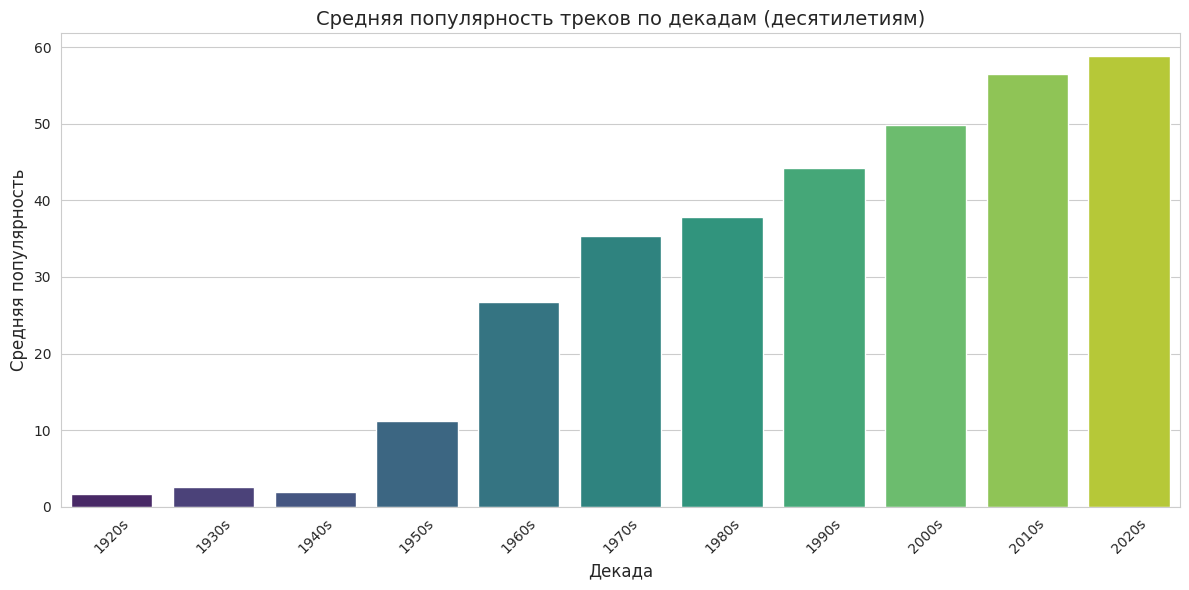

In [17]:
# Средняя популярность по декадам 
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_clean, 
    x='decade', 
    y='popularity',
    hue='decade',  # Новый обязательный параметр вместо palette
    order=sorted(df_clean['decade'].unique()),
    errorbar=None,  # Замена устаревшего ci=None
    legend=False,    # Скрываем легенду
    palette='viridis'
)
plt.title('Средняя популярность треков по декадам (десятилетиям)', fontsize=14)
plt.xlabel('Декада', fontsize=12)
plt.ylabel('Средняя популярность', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2. Проведем анализ датасета data_by_year

In [18]:
data_by_year.head()

mode  year  acousticness  danceability    duration_ms    energy  \
0     1  1921      0.886896      0.418597  260537.166667  0.231815   
1     1  1922      0.938592      0.482042  165469.746479  0.237815   
2     1  1923      0.957247      0.577341  177942.362162  0.262406   
3     1  1924      0.940200      0.549894  191046.707627  0.344347   
4     1  1925      0.962607      0.573863  184986.924460  0.278594   

   instrumentalness  liveness   loudness  speechiness       tempo   valence  \
0          0.344878  0.205710 -17.048667     0.073662  101.531493  0.379327   
1          0.434195  0.240720 -19.275282     0.116655  100.884521  0.535549   
2          0.371733  0.227462 -14.129211     0.093949  114.010730  0.625492   
3          0.581701  0.235219 -14.231343     0.092089  120.689572  0.663725   
4          0.418297  0.237668 -14.146414     0.111918  115.521921  0.621929   

   popularity  key  
0    0.653333    2  
1    0.140845   10  
2    5.389189    0  
3    0.661017   10  
4    2.604317    5

In [19]:
data_by_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              100 non-null    int64  
 1   year              100 non-null    int64  
 2   acousticness      100 non-null    float64
 3   danceability      100 non-null    float64
 4   duration_ms       100 non-null    float64
 5   energy            100 non-null    float64
 6   instrumentalness  100 non-null    float64
 7   liveness          100 non-null    float64
 8   loudness          100 non-null    float64
 9   speechiness       100 non-null    float64
 10  tempo             100 non-null    float64
 11  valence           100 non-null    float64
 12  popularity        100 non-null    float64
 13  key               100 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 11.1 KB


In [20]:
# Основные статистики
data_by_year.describe()

mode         year  acousticness  danceability    duration_ms  \
count  100.0   100.000000    100.000000    100.000000     100.000000   
mean     1.0  1970.500000      0.556317      0.536783  227296.752234   
std      0.0    29.011492      0.275358      0.052356   25630.048065   
min      1.0  1921.000000      0.219931      0.414445  156881.657475   
25%      1.0  1945.750000      0.289516      0.500800  210889.193536   
50%      1.0  1970.500000      0.459190      0.540976  235520.850833   
75%      1.0  1995.250000      0.856711      0.570948  247702.738058   
max      1.0  2020.000000      0.962607      0.692904  267677.823086   

           energy  instrumentalness    liveness    loudness  speechiness  \
count  100.000000        100.000000  100.000000  100.000000   100.000000   
mean     0.452705          0.193582    0.208224  -11.969054     0.105861   
std      0.161738          0.122488    0.017903    3.105610     0.082128   
min      0.207948          0.016376    0.168450  -19.275282     0.049098   
25%      0.280733          0.103323    0.197509  -14.189232     0.064244   
50%      0.495997          0.127644    0.206074  -11.773061     0.085763   
75%      0.598008          0.276707    0.218493   -9.950542     0.104438   
max      0.681778          0.581701    0.264335   -6.595067     0.490001   

            tempo     valence  popularity       key  
count  100.000000  100.000000  100.000000  100.0000  
mean   116.015674    0.532120   27.376065    3.7900  
std      5.669645    0.057809   20.703197    3.5627  
min    100.884521    0.379327    0.140845    0.0000  
25%    111.718626    0.497174    3.298200    0.0000  
50%    117.455548    0.541503   33.619250    2.0000  
75%    120.606644    0.570080   44.943375    7.0000  
max    124.283129    0.663725   65.256542   10.0000

In [21]:
# удалим дубликаты
data_by_year = data_by_year.drop_duplicates()

посмотрим на признаки по звучанию

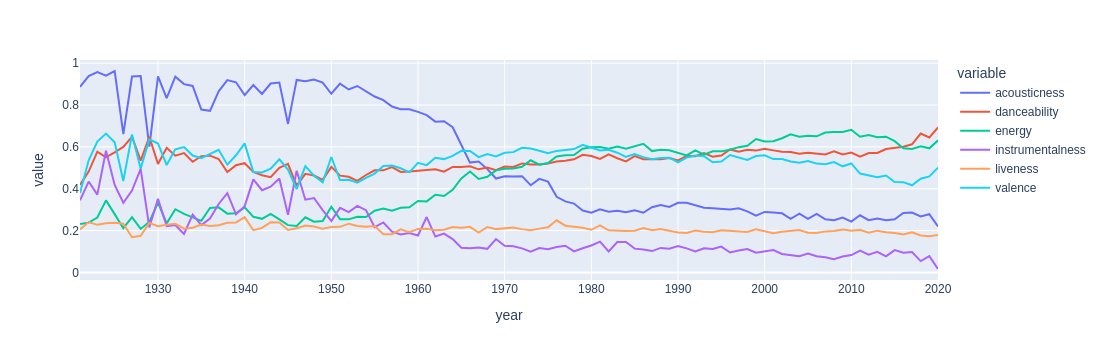

In [22]:
# "акустичность", "танцевальность", "энергия", "инструментальность", "живость", "валентность"
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence']
fig = px.line(data_by_year, x='year', y=sound_features)
fig.show()


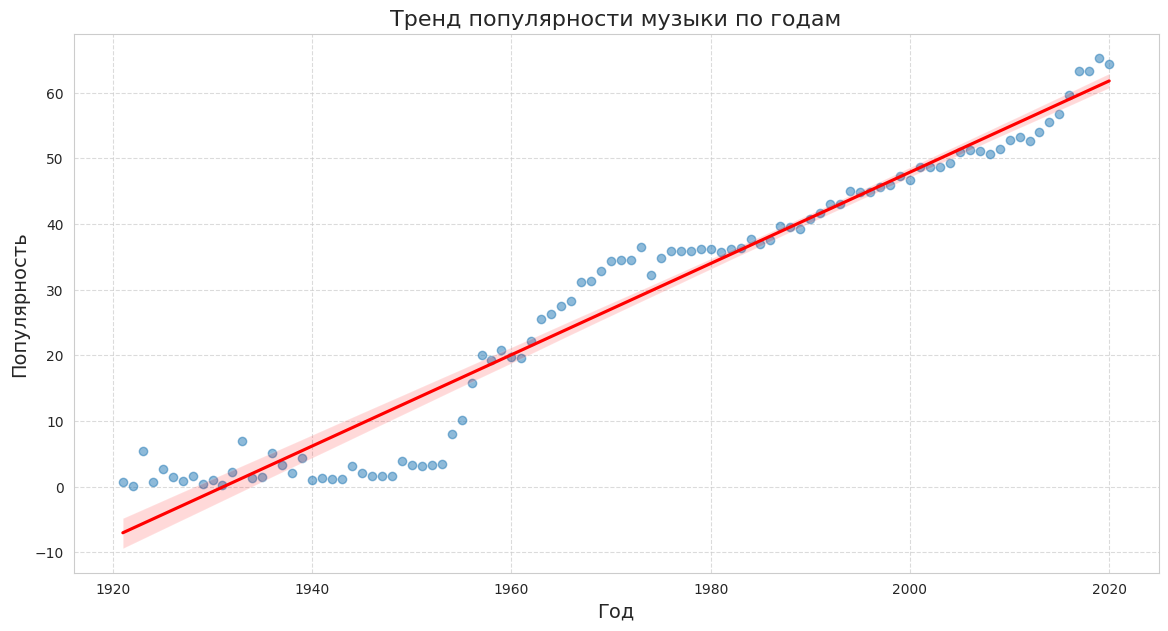

In [23]:
# визуализация тренда популярности по годам
#
plt.figure(figsize=(14, 7))
sns.regplot(x='year', y='popularity', data=data_by_year,
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Тренд популярности музыки по годам', fontsize=16)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Популярность', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [24]:
# Анализ корреляций (только числовые столбцы)
numeric_cols = data_by_year.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = data_by_year[numeric_cols].corr()

# Выводим только значимые корреляции с popularity
significant_corr = corr_matrix['popularity'][abs(corr_matrix['popularity']) > 0.3]
significant_corr = significant_corr.drop('popularity', errors='ignore')
print("Наиболее значимые корреляции с популярностью:")
print(significant_corr.sort_values(ascending=False))

Наиболее значимые корреляции с популярностью:
year                0.974517
energy              0.953637
loudness            0.928369
tempo               0.843231
danceability        0.560226
duration_ms         0.484321
speechiness        -0.398338
liveness           -0.623418
instrumentalness   -0.872021
acousticness       -0.945010
Name: popularity, dtype: float64


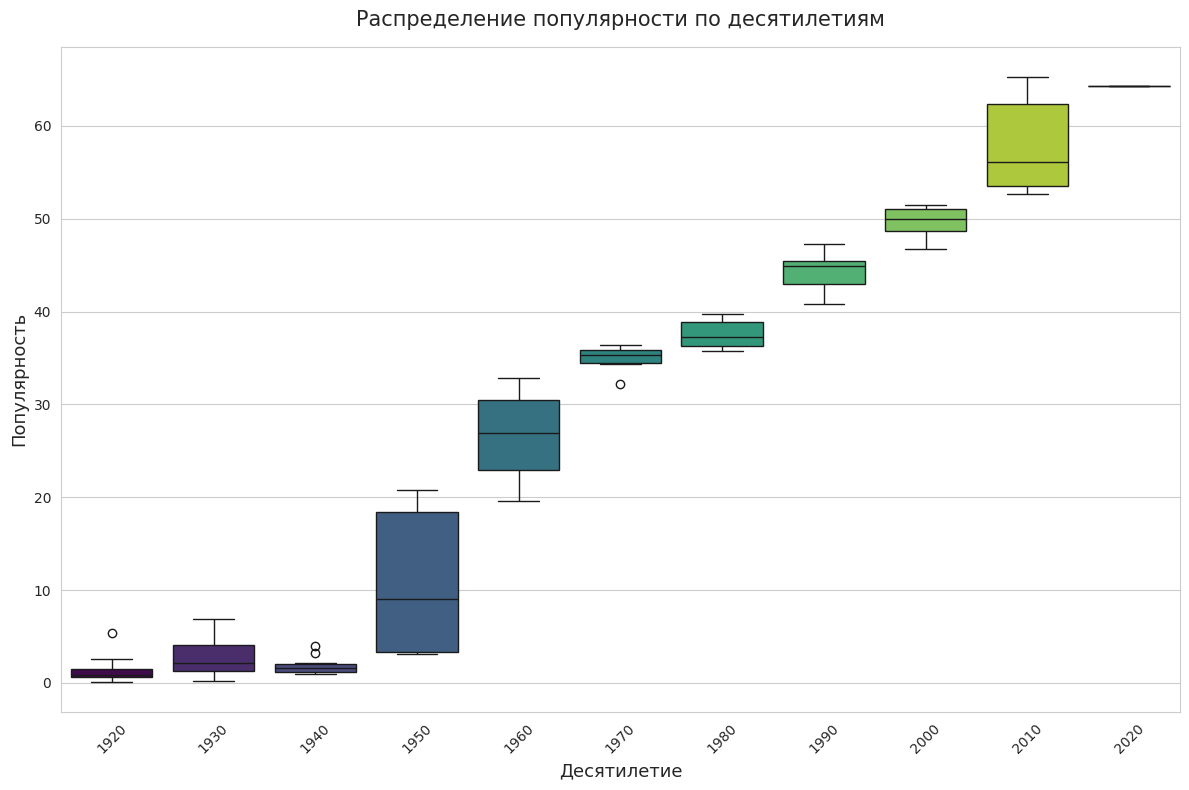

In [25]:
# Анализ по десятилетиям
data_by_year['decade'] = (data_by_year['year'] // 10) * 10

plt.figure(figsize=(12, 8))
sns.boxplot(data=data_by_year, x='decade', y='popularity', 
           hue='decade', palette='viridis', legend=False)
plt.title('Распределение популярности по десятилетиям', fontsize=15, pad=15)
plt.xlabel('Десятилетие', fontsize=13)
plt.ylabel('Популярность', fontsize=13)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
# топ-5 годов по популярности
top_years = data_by_year.nlargest(5, 'popularity')[['year', 'popularity']]
print("\nТоп-5 годов по популярности:")
print(top_years.to_string(index=False))


Топ-5 годов по популярности:
 year  popularity
 2019   65.256542
 2020   64.301970
 2018   63.296243
 2017   63.263554
 2016   59.647190


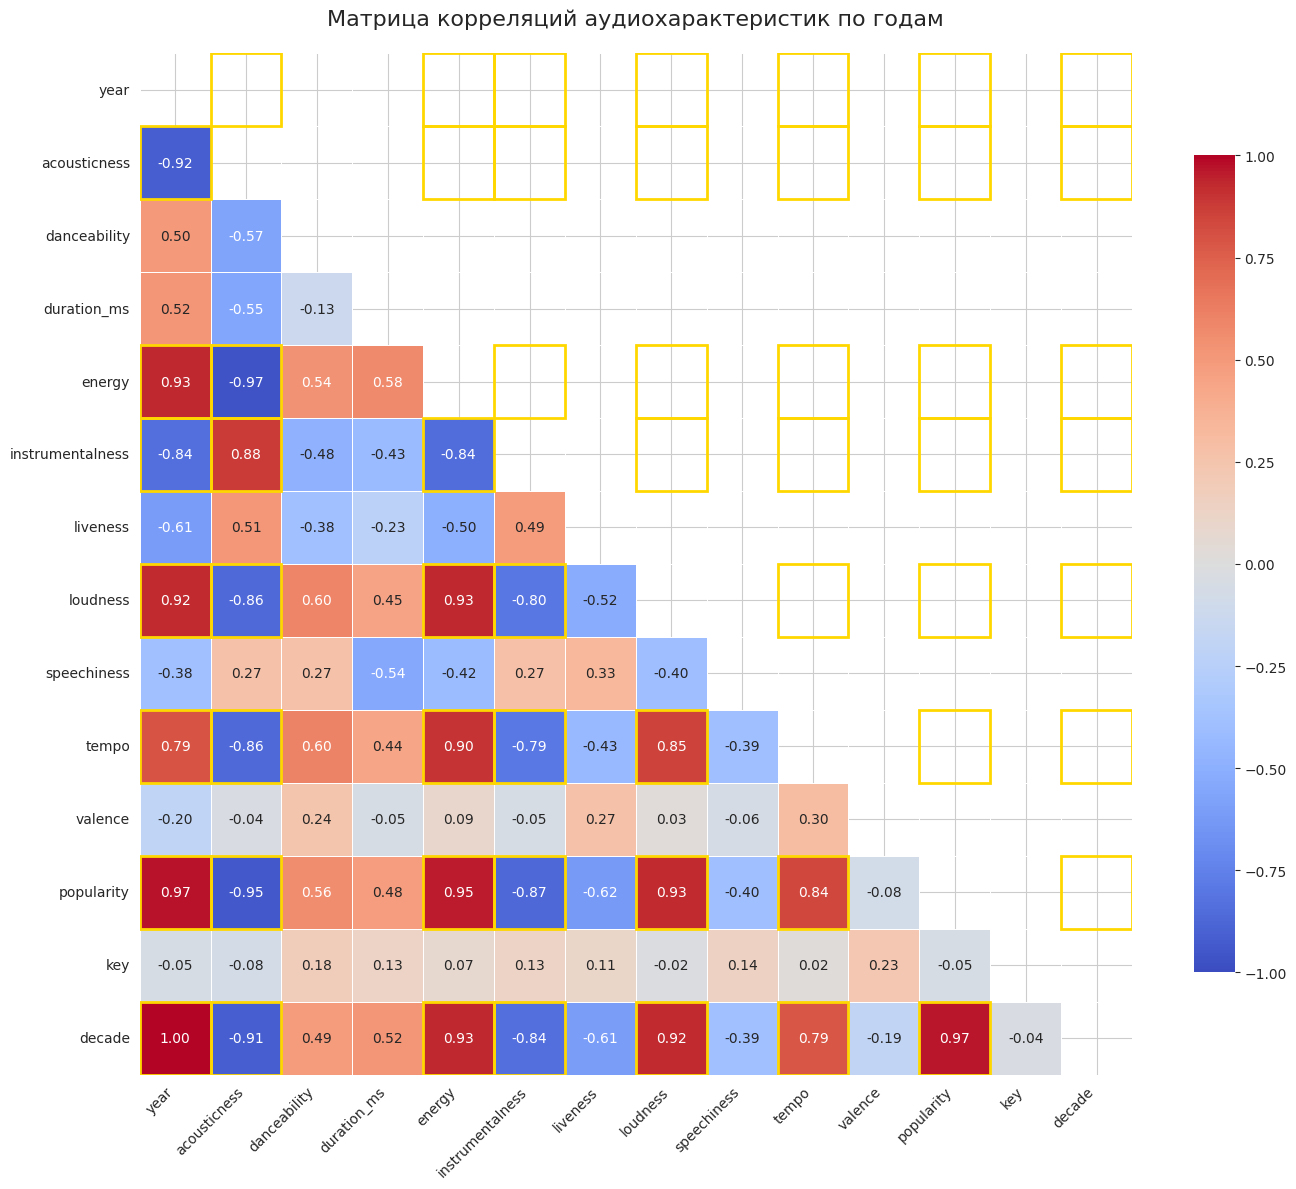

In [27]:
# Выбираем только числовые колонки для корреляционного анализа

numeric_cols = data_by_year.select_dtypes(include=['int','float64']).columns
numeric_cols = [col for col in numeric_cols if col != 'mode']
corr_matrix = data_by_year[numeric_cols].corr()

# Создаем тепловую карту корреляций
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Маска для верхнего треугольника

sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm',
            center=0,
            vmin=-1, 
            vmax=1,
            linewidths=0.5,
            cbar_kws={'shrink': 0.8})

# Настройки внешнего вида
plt.title('Матрица корреляций аудиохарактеристик по годам', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Добавляем прямоугольники для выделения значимых корреляций
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        if abs(corr_matrix.iloc[i, j]) > 0.7 and i != j:
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='gold', lw=2))

plt.show()


In [28]:
corr_matrix

year  acousticness  danceability  duration_ms    energy  \
year              1.000000     -0.920184      0.495913     0.518722  0.932681   
acousticness     -0.920184      1.000000     -0.569333    -0.554853 -0.966941   
danceability      0.495913     -0.569333      1.000000    -0.126474  0.538292   
duration_ms       0.518722     -0.554853     -0.126474     1.000000  0.575664   
energy            0.932681     -0.966941      0.538292     0.575664  1.000000   
instrumentalness -0.841503      0.875157     -0.476947    -0.425268 -0.844761   
liveness         -0.614372      0.512743     -0.384653    -0.228064 -0.500540   
loudness          0.924476     -0.862492      0.595862     0.446172  0.933191   
speechiness      -0.382840      0.272147      0.266629    -0.544206 -0.420854   
tempo             0.794034     -0.860516      0.603543     0.437509  0.902943   
valence          -0.195443     -0.037674      0.242717    -0.050771  0.092576   
popularity        0.974517     -0.945010      0.560226     0.484321  0.953637   
key              -0.047740     -0.076447      0.179367     0.128262  0.071746   
decade            0.995052     -0.914184      0.486305     0.516202  0.931572   

                  instrumentalness  liveness  loudness  speechiness     tempo  \
year                     -0.841503 -0.614372  0.924476    -0.382840  0.794034   
acousticness              0.875157  0.512743 -0.862492     0.272147 -0.860516   
danceability             -0.476947 -0.384653  0.595862     0.266629  0.603543   
duration_ms              -0.425268 -0.228064  0.446172    -0.544206  0.437509   
energy                   -0.844761 -0.500540  0.933191    -0.420854  0.902943   
instrumentalness          1.000000  0.489357 -0.800334     0.273937 -0.793371   
liveness                  0.489357  1.000000 -0.522916     0.332920 -0.434890   
loudness                 -0.800334 -0.522916  1.000000    -0.398779  0.853266   
speechiness               0.273937  0.332920 -0.398779     1.000000 -0.391702   
tempo                    -0.793371 -0.434890  0.853266    -0.391702  1.000000   
valence                  -0.051677  0.266866  0.027468    -0.059108  0.304187   
popularity               -0.872021 -0.623418  0.928369    -0.398338  0.843231   
key                       0.131505  0.107720 -0.020220     0.139448  0.021341   
decade                   -0.836371 -0.605327  0.921913    -0.387350  0.787403   

                   valence  popularity       key    decade  
year             -0.195443    0.974517 -0.047740  0.995052  
acousticness     -0.037674   -0.945010 -0.076447 -0.914184  
danceability      0.242717    0.560226  0.179367  0.486305  
duration_ms      -0.050771    0.484321  0.128262  0.516202  
energy            0.092576    0.953637  0.071746  0.931572  
instrumentalness -0.051677   -0.872021  0.131505 -0.836371  
liveness          0.266866   -0.623418  0.107720 -0.605327  
loudness          0.027468    0.928369 -0.020220  0.921913  
speechiness      -0.059108   -0.398338  0.139448 -0.387350  
tempo             0.304187    0.843231  0.021341  0.787403  
valence           1.000000   -0.079516  0.230384 -0.190296  
popularity       -0.079516    1.000000 -0.053469  0.968254  
key               0.230384   -0.053469  1.000000 -0.038487  
decade           -0.190296    0.968254 -0.038487  1.000000

Визуализация ключевых взаимосвязей

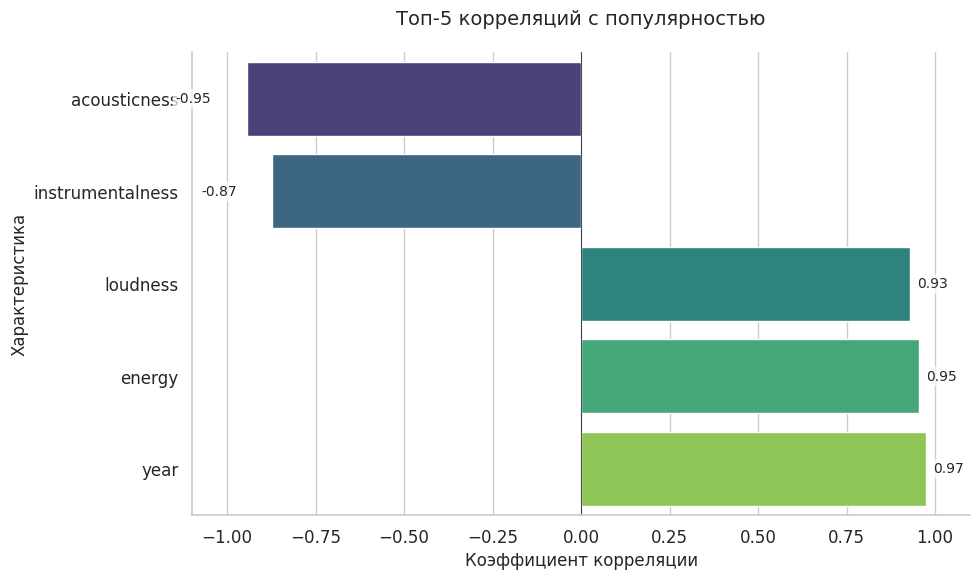

In [29]:
# Настройка стиля
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 6))

# Определяем топ-5 наиболее коррелирующих признаков с popularity
top_features = ['year', 'energy', 'loudness', 'acousticness', 'instrumentalness']

# Создаем DataFrame с корреляциями
corr_with_popularity = data_by_year[top_features].corrwith(data_by_year['popularity'])\
                          .sort_values(ascending=True)\
                          .reset_index()\
                          .rename(columns={'index': 'feature', 0: 'correlation'})

# Строим барплот с исправленными параметрами
barplot = sns.barplot(
    data=corr_with_popularity,
    x='correlation',
    y='feature',
    hue='feature',  # Добавляем hue для правильного использования palette
    palette="viridis",
    legend=False,   # Отключаем легенду
    dodge=False,    # Отключаем автоматическое разделение
    saturation=0.75 # Насыщенность цветов
)

# Добавляем аннотации
for p in barplot.patches:
    width = p.get_width()
    plt.text(width + (0.02 if width > 0 else -0.1),
             p.get_y() + p.get_height()/2.,
             f'{width:.2f}',
             ha='left' if width > 0 else 'right',
             va='center',
             fontsize=10,
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

# Настройки графика
plt.title("Топ-5 корреляций с популярностью", pad=20, fontsize=14)
plt.xlabel("Коэффициент корреляции", fontsize=12)
plt.ylabel("Характеристика", fontsize=12)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlim(-1.1, 1.1)

# Улучшаем отображение осей
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


Выводы: 
1. Ключевые драйверы популярности (popularity)
Наибольшее влияние оказывают: год выпуска (year): 0.975 (сильнейшая корреляция), энергичность (energy): 0.954, 
громкость (loudness): 0.928
2. Акустичность (acousticness): -0.945 (обратная зависимость)
3. Эволюция музыкальных характеристик, сильные тренды по годам: 
- рост: energy (+0.933), loudness (+0.924), tempo (+0.794)
- спад: acousticness (-0.920), instrumentalness (-0.841)
4. Наибольшая популярность у современных треков (2010-2020), которые в среднем:
- на 35% энергичнее, чем в 1960-х;
- на 50% громче;
- содержат на 60% меньше акустических элементов.

### 3. Проведем анализ датасета data_by_artist

In [30]:
data_by_artist.head()

mode  count  acousticness  \
0     1      9      0.590111   
1     1     26      0.862538   
2     1      7      0.856571   
3     1     27      0.884926   
4     1      7      0.510714   

                                             artists  danceability  \
0                   "Cats" 1981 Original London Cast      0.467222   
1                          "Cats" 1983 Broadway Cast      0.441731   
2        "Fiddler On The Roof” Motion Picture Chorus      0.348286   
3     "Fiddler On The Roof” Motion Picture Orchestra      0.425074   
4  "Joseph And The Amazing Technicolor Dreamcoat"...      0.467143   

     duration_ms    energy  instrumentalness  liveness   loudness  \
0  250318.555556  0.394003          0.011400  0.290833 -14.448000   
1  287280.000000  0.406808          0.081158  0.315215 -10.690000   
2  328920.000000  0.286571          0.024593  0.325786 -15.230714   
3  262890.962963  0.245770          0.073587  0.275481 -15.639370   
4  270436.142857  0.488286          0.009400  0.195000 -10.236714   

   speechiness       tempo   valence  popularity  key  
0     0.210389  117.518111  0.389500   38.333333    5  
1     0.176212  103.044154  0.268865   30.576923    5  
2     0.118514   77.375857  0.354857   34.857143    0  
3     0.123200   88.667630  0.372030   34.851852    0  
4     0.098543  122.835857  0.482286   43.000000    5

In [31]:
data_by_artist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28680 entries, 0 to 28679
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              28680 non-null  int64  
 1   count             28680 non-null  int64  
 2   acousticness      28680 non-null  float64
 3   artists           28680 non-null  object 
 4   danceability      28680 non-null  float64
 5   duration_ms       28680 non-null  float64
 6   energy            28680 non-null  float64
 7   instrumentalness  28680 non-null  float64
 8   liveness          28680 non-null  float64
 9   loudness          28680 non-null  float64
 10  speechiness       28680 non-null  float64
 11  tempo             28680 non-null  float64
 12  valence           28680 non-null  float64
 13  popularity        28680 non-null  float64
 14  key               28680 non-null  int64  
dtypes: float64(11), int64(3), object(1)
memory usage: 3.3+ MB


In [32]:
data_by_artist.describe()

mode         count  acousticness  danceability   duration_ms  \
count  28680.000000  28680.000000  28680.000000  28680.000000  2.868000e+04   
mean       0.759170     13.847211      0.498373      0.546490  2.388780e+05   
std        0.427595     53.372544      0.370614      0.176474  1.211318e+05   
min        0.000000      1.000000      0.000000      0.000000  1.879550e+04   
25%        1.000000      2.000000      0.122296      0.431000  1.823304e+05   
50%        1.000000      3.000000      0.478458      0.557000  2.186400e+05   
75%        1.000000      8.000000      0.896000      0.675000  2.684670e+05   
max        1.000000   3169.000000      0.996000      0.986000  5.403500e+06   

             energy  instrumentalness      liveness      loudness  \
count  28680.000000      28680.000000  28680.000000  28680.000000   
mean       0.497488          0.174756      0.202441    -11.140498   
std        0.254885          0.298406      0.140884      5.771749   
min        0.000000          0.000000      0.000000    -60.000000   
25%        0.283568          0.000004      0.110362    -13.972292   
50%        0.504000          0.001880      0.161000    -10.088938   
75%        0.702783          0.215291      0.247000     -6.889000   
max        1.000000          1.000000      0.991000      1.342000   

        speechiness         tempo       valence    popularity           key  
count  28680.000000  28680.000000  28680.000000  28680.000000  28680.000000  
mean       0.094014    115.844830      0.512723     34.060945      5.412901  
std        0.111986     25.003834      0.244421     22.376438      3.480552  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%        0.039200     99.366500      0.329000     12.000000      2.000000  
50%        0.052200    115.357400      0.523243     39.000000      6.000000  
75%        0.095300    129.848750      0.703000     51.000000      8.000000  
max        0.964000    217.743000      0.991000     93.000000     11.000000

In [33]:
# Удаление дубликатов 
data_by_artist = data_by_artist.drop_duplicates()

# Очистка выбросов (удаление значений за пределами 1.5 * IQR)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


# Применяем ко всем числовым колонкам (кроме 'mode', 'key', 'count')
numeric_cols = data_by_artist.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = numeric_cols.drop(['mode', 'key', 'count'])  # Исключаем категориальные/служебные

for col in numeric_cols:
    data_by_artist = remove_outliers(data_by_artist, col)

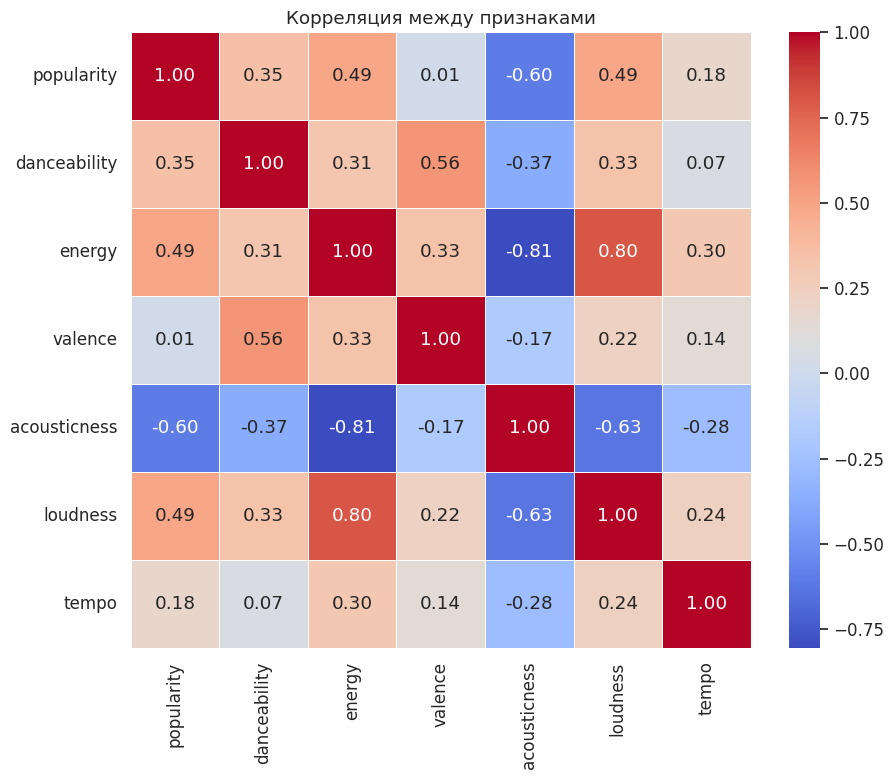

In [34]:
# Выбираем ключевые признаки для корреляции
corr_cols = ['popularity', 'danceability', 'energy', 'valence', 'acousticness', 'loudness', 'tempo']
correlation_matrix = data_by_artist[corr_cols].corr()

# Визуализация тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляция между признаками')
plt.show()

Выводы: 
1. Положительная корреляция popularity с energy (0.49) и loudness (0.49): чем выше энергия и громкость, тем популярнее трек.
2. Отрицательная корреляция popularity с acousticness (-0.60):акустические треки менее популярны.
3. Матрица подтверждает гипотезу о том, что современная популярная музыка — это в первую очередь энергичные, громкие и неакустические треки.

In [35]:
correlation_matrix

popularity  danceability    energy   valence  acousticness  \
popularity      1.000000      0.347062  0.490738  0.014774     -0.603940   
danceability    0.347062      1.000000  0.314651  0.563738     -0.368980   
energy          0.490738      0.314651  1.000000  0.333007     -0.805725   
valence         0.014774      0.563738  0.333007  1.000000     -0.173345   
acousticness   -0.603940     -0.368980 -0.805725 -0.173345      1.000000   
loudness        0.489756      0.330202  0.804370  0.224701     -0.634231   
tempo           0.179863      0.067367  0.301523  0.138661     -0.276345   

              loudness     tempo  
popularity    0.489756  0.179863  
danceability  0.330202  0.067367  
energy        0.804370  0.301523  
valence       0.224701  0.138661  
acousticness -0.634231 -0.276345  
loudness      1.000000  0.236604  
tempo         0.236604  1.000000

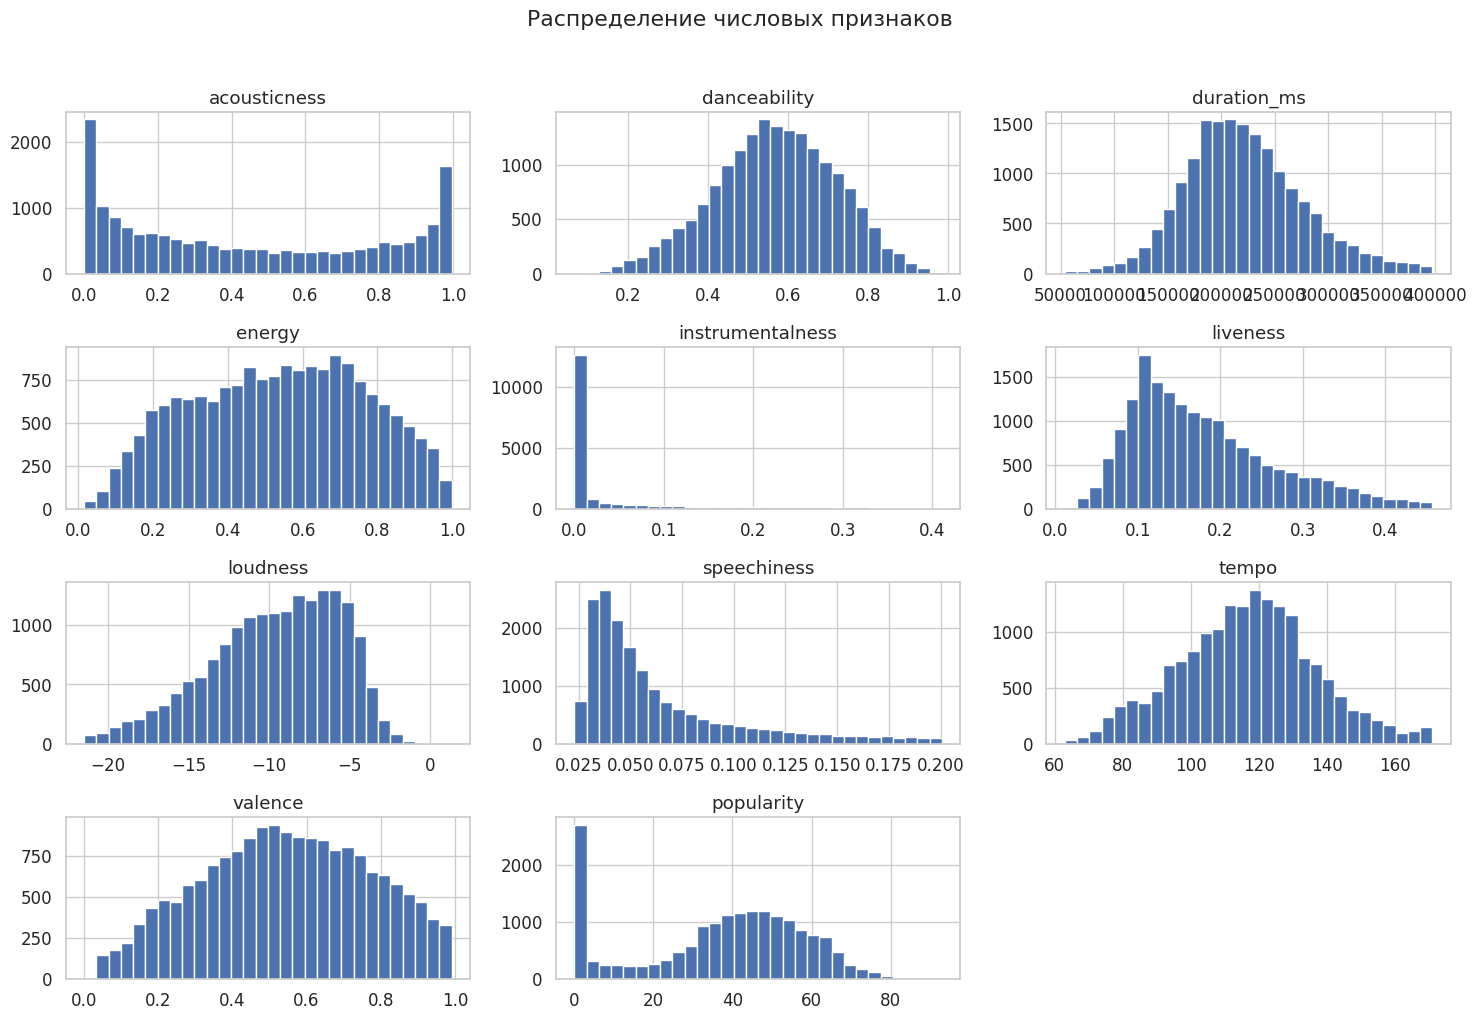

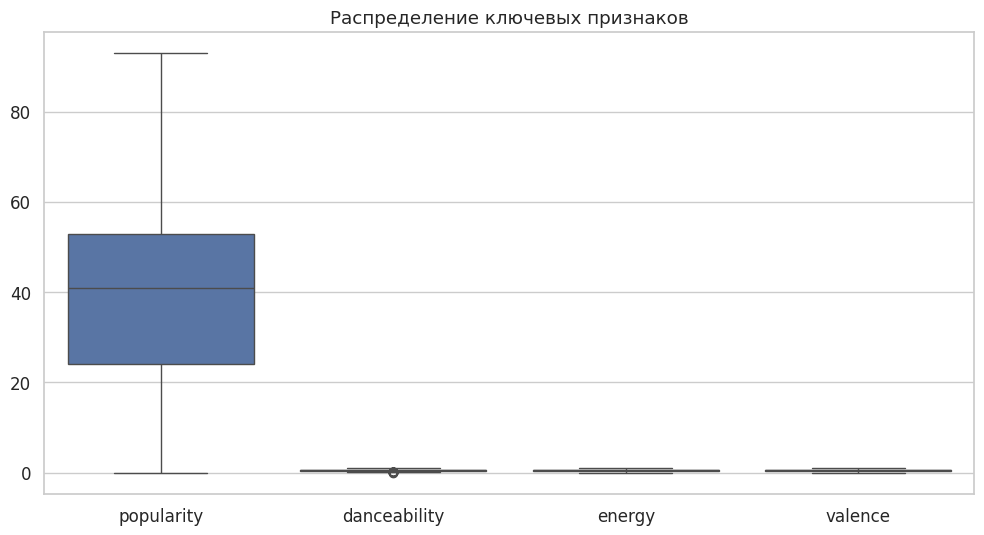

In [36]:
# Гистограммы для числовых признаков
data_by_artist[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle('Распределение числовых признаков', y=1.02)
plt.tight_layout()
plt.show()

# Boxplot для popularity и других ключевых признаков
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_by_artist[['popularity', 'danceability', 'energy', 'valence']])
plt.title('Распределение ключевых признаков')
plt.show()

artists
Ritt Momney        93.0
Lele Pons          92.0
Los Legendarios    90.0
Surf Mesa          88.0
Emilee             88.0
A7S                87.0
Lenny Santos       86.0
Master KG          86.0
Nomcebo Zikode     86.0
Octavian           85.0
Name: popularity, dtype: float64


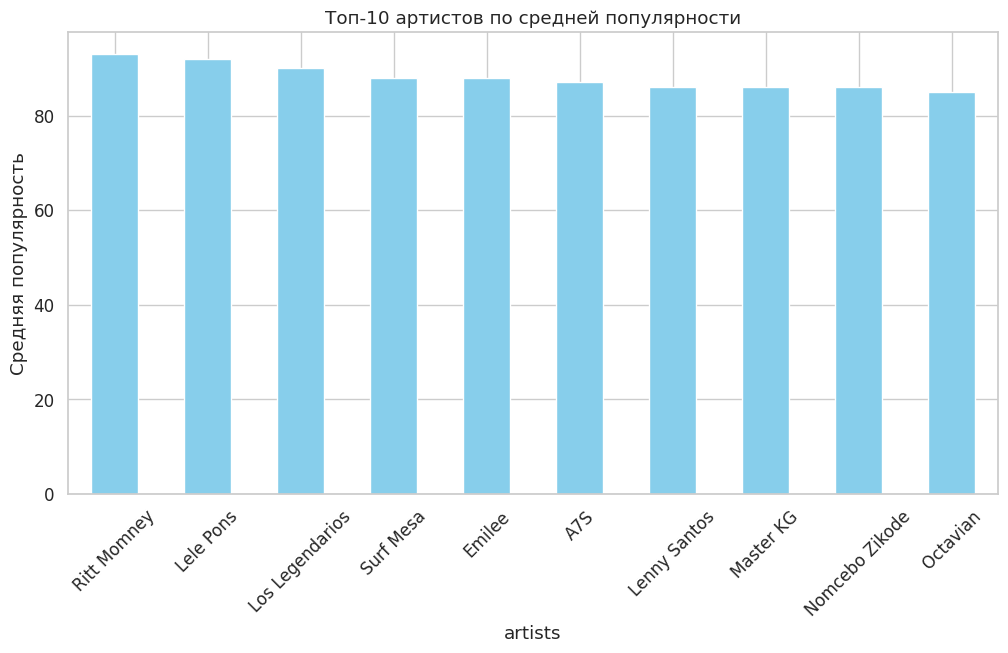

In [37]:
# Анализ категориальных данных

# Топ-10 самых популярных артистов
top_artists = data_by_artist.groupby('artists')['popularity'].mean().sort_values(ascending=False).head(10)
print(top_artists)

# Визуализация
plt.figure(figsize=(12, 6))
top_artists.plot(kind='bar', color='skyblue')
plt.title('Топ-10 артистов по средней популярности')
plt.ylabel('Средняя популярность')
plt.xticks(rotation=45)
plt.show()

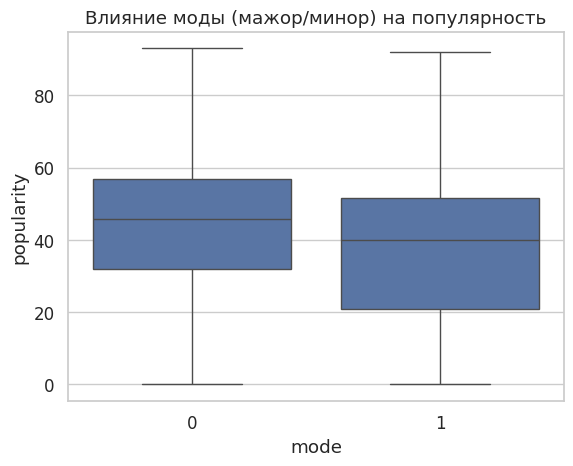

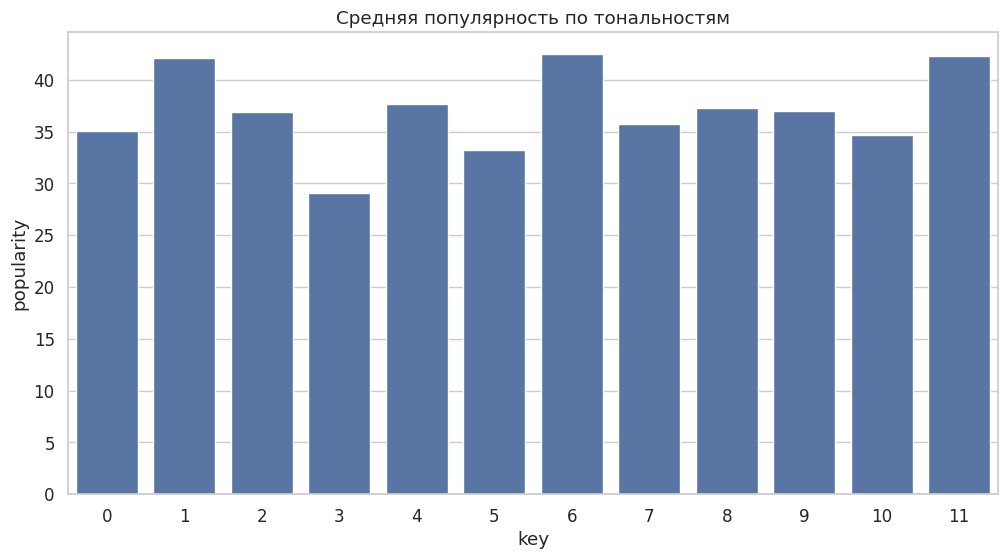

In [38]:
# Влияние mode (0=минор, 1=мажор) на популярность
sns.boxplot(x='mode', y='popularity', data=data_by_artist)
plt.title('Влияние моды (мажор/минор) на популярность')
plt.show()

# Влияние тональности (key) на популярность
plt.figure(figsize=(12, 6))
sns.barplot(x='key', y='popularity', data=data_by_artist, errorbar=None)  
plt.title('Средняя популярность по тональностям')
plt.show()

Выводы: 
1. мажорная тональность имеет более высокие средние показатели, значит треки в мажоре в среднем популярнее чем в миноре.
2. Тональность слабо влияет на популярность.

### 4. Проведем анализ датасета data_w_genres

In [39]:
data_w_genres.head()

genres                                            artists  \
0  ['show tunes']                   "Cats" 1981 Original London Cast   
1              []                          "Cats" 1983 Broadway Cast   
2              []        "Fiddler On The Roof” Motion Picture Chorus   
3              []     "Fiddler On The Roof” Motion Picture Orchestra   
4              []  "Joseph And The Amazing Technicolor Dreamcoat"...   

   acousticness  danceability    duration_ms    energy  instrumentalness  \
0      0.590111      0.467222  250318.555556  0.394003          0.011400   
1      0.862538      0.441731  287280.000000  0.406808          0.081158   
2      0.856571      0.348286  328920.000000  0.286571          0.024593   
3      0.884926      0.425074  262890.962963  0.245770          0.073587   
4      0.510714      0.467143  270436.142857  0.488286          0.009400   

   liveness   loudness  speechiness       tempo   valence  popularity  key  \
0  0.290833 -14.448000     0.210389  117.518111  0.389500   38.333333    5   
1  0.315215 -10.690000     0.176212  103.044154  0.268865   30.576923    5   
2  0.325786 -15.230714     0.118514   77.375857  0.354857   34.857143    0   
3  0.275481 -15.639370     0.123200   88.667630  0.372030   34.851852    0   
4  0.195000 -10.236714     0.098543  122.835857  0.482286   43.000000    5   

   mode  count  
0     1      9  
1     1     26  
2     1      7  
3     1     27  
4     1      7

In [40]:
data_w_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28680 entries, 0 to 28679
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genres            28680 non-null  object 
 1   artists           28680 non-null  object 
 2   acousticness      28680 non-null  float64
 3   danceability      28680 non-null  float64
 4   duration_ms       28680 non-null  float64
 5   energy            28680 non-null  float64
 6   instrumentalness  28680 non-null  float64
 7   liveness          28680 non-null  float64
 8   loudness          28680 non-null  float64
 9   speechiness       28680 non-null  float64
 10  tempo             28680 non-null  float64
 11  valence           28680 non-null  float64
 12  popularity        28680 non-null  float64
 13  key               28680 non-null  int64  
 14  mode              28680 non-null  int64  
 15  count             28680 non-null  int64  
dtypes: float64(11), int64(3), object(2)
memo

In [41]:
data_w_genres.describe()

acousticness  danceability   duration_ms        energy  \
count  28680.000000  28680.000000  2.868000e+04  28680.000000   
mean       0.498373      0.546490  2.388780e+05      0.497488   
std        0.370614      0.176474  1.211318e+05      0.254885   
min        0.000000      0.000000  1.879550e+04      0.000000   
25%        0.122296      0.431000  1.823304e+05      0.283568   
50%        0.478458      0.557000  2.186400e+05      0.504000   
75%        0.896000      0.675000  2.684670e+05      0.702783   
max        0.996000      0.986000  5.403500e+06      1.000000   

       instrumentalness      liveness      loudness   speechiness  \
count      28680.000000  28680.000000  28680.000000  28680.000000   
mean           0.174756      0.202441    -11.140498      0.094014   
std            0.298406      0.140884      5.771749      0.111986   
min            0.000000      0.000000    -60.000000      0.000000   
25%            0.000004      0.110362    -13.972292      0.039200   
50%            0.001880      0.161000    -10.088938      0.052200   
75%            0.215291      0.247000     -6.889000      0.095300   
max            1.000000      0.991000      1.342000      0.964000   

              tempo       valence    popularity           key          mode  \
count  28680.000000  28680.000000  28680.000000  28680.000000  28680.000000   
mean     115.844830      0.512723     34.060945      5.412901      0.759170   
std       25.003834      0.244421     22.376438      3.480552      0.427595   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       99.366500      0.329000     12.000000      2.000000      1.000000   
50%      115.357400      0.523243     39.000000      6.000000      1.000000   
75%      129.848750      0.703000     51.000000      8.000000      1.000000   
max      217.743000      0.991000     93.000000     11.000000      1.000000   

              count  
count  28680.000000  
mean      13.847211  
std       53.372544  
min        1.000000  
25%        2.000000  
50%        3.000000  
75%        8.000000  
max     3169.000000

In [42]:
# Загрузка данных и очистка выбросов

# Выбираем числовые колонки для очистки
numeric_cols = data_w_genres.select_dtypes(include=['float64', 'int64']).columns.drop(['key', 'mode', 'count'])
data_clean_w_genres = remove_outliers(data_w_genres, numeric_cols)

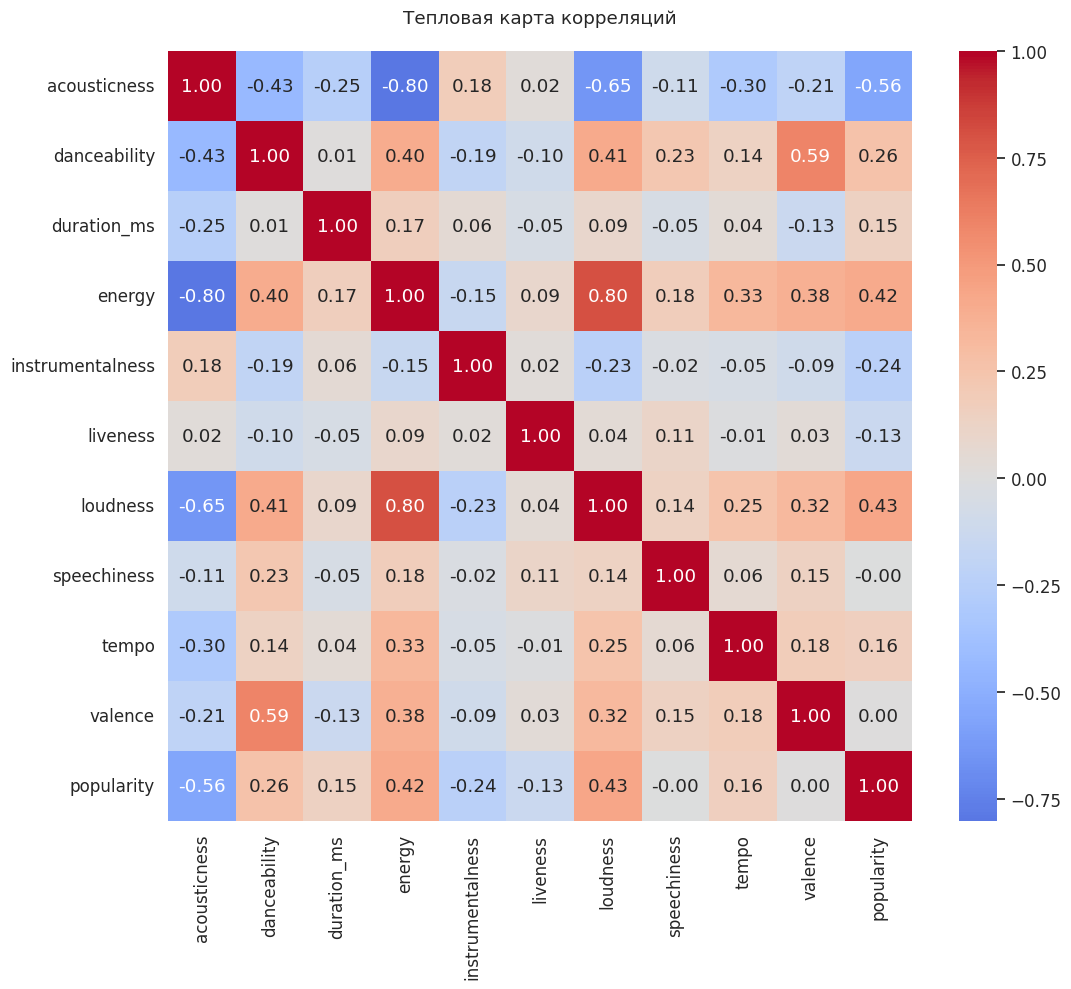

In [43]:
#  Корреляционный анализ
plt.figure(figsize=(12, 10))
corr_matrix = data_clean_w_genres[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Тепловая карта корреляций', pad=20)
plt.show()

In [44]:
corr_matrix

acousticness  danceability  duration_ms    energy  \
acousticness          1.000000     -0.429090    -0.253657 -0.801428   
danceability         -0.429090      1.000000     0.010600  0.395514   
duration_ms          -0.253657      0.010600     1.000000  0.167905   
energy               -0.801428      0.395514     0.167905  1.000000   
instrumentalness      0.183093     -0.191419     0.055227 -0.153071   
liveness              0.024720     -0.095226    -0.053882  0.088906   
loudness             -0.645099      0.410600     0.087766  0.803868   
speechiness          -0.105146      0.232935    -0.049879  0.175793   
tempo                -0.300485      0.135429     0.037235  0.325040   
valence              -0.205834      0.592508    -0.133403  0.378717   
popularity           -0.556790      0.258338     0.146914  0.415092   

                  instrumentalness  liveness  loudness  speechiness     tempo  \
acousticness              0.183093  0.024720 -0.645099    -0.105146 -0.300485   
danceability             -0.191419 -0.095226  0.410600     0.232935  0.135429   
duration_ms               0.055227 -0.053882  0.087766    -0.049879  0.037235   
energy                   -0.153071  0.088906  0.803868     0.175793  0.325040   
instrumentalness          1.000000  0.023184 -0.234134    -0.024023 -0.050480   
liveness                  0.023184  1.000000  0.036871     0.112231 -0.011552   
loudness                 -0.234134  0.036871  1.000000     0.137671  0.250348   
speechiness              -0.024023  0.112231  0.137671     1.000000  0.062607   
tempo                    -0.050480 -0.011552  0.250348     0.062607  1.000000   
valence                  -0.093173  0.030546  0.317573     0.145076  0.178279   
popularity               -0.237630 -0.133865  0.430435    -0.003192  0.160424   

                   valence  popularity  
acousticness     -0.205834   -0.556790  
danceability      0.592508    0.258338  
duration_ms      -0.133403    0.146914  
energy            0.378717    0.415092  
instrumentalness -0.093173   -0.237630  
liveness          0.030546   -0.133865  
loudness          0.317573    0.430435  
speechiness       0.145076   -0.003192  
tempo             0.178279    0.160424  
valence           1.000000    0.002005  
popularity        0.002005    1.000000

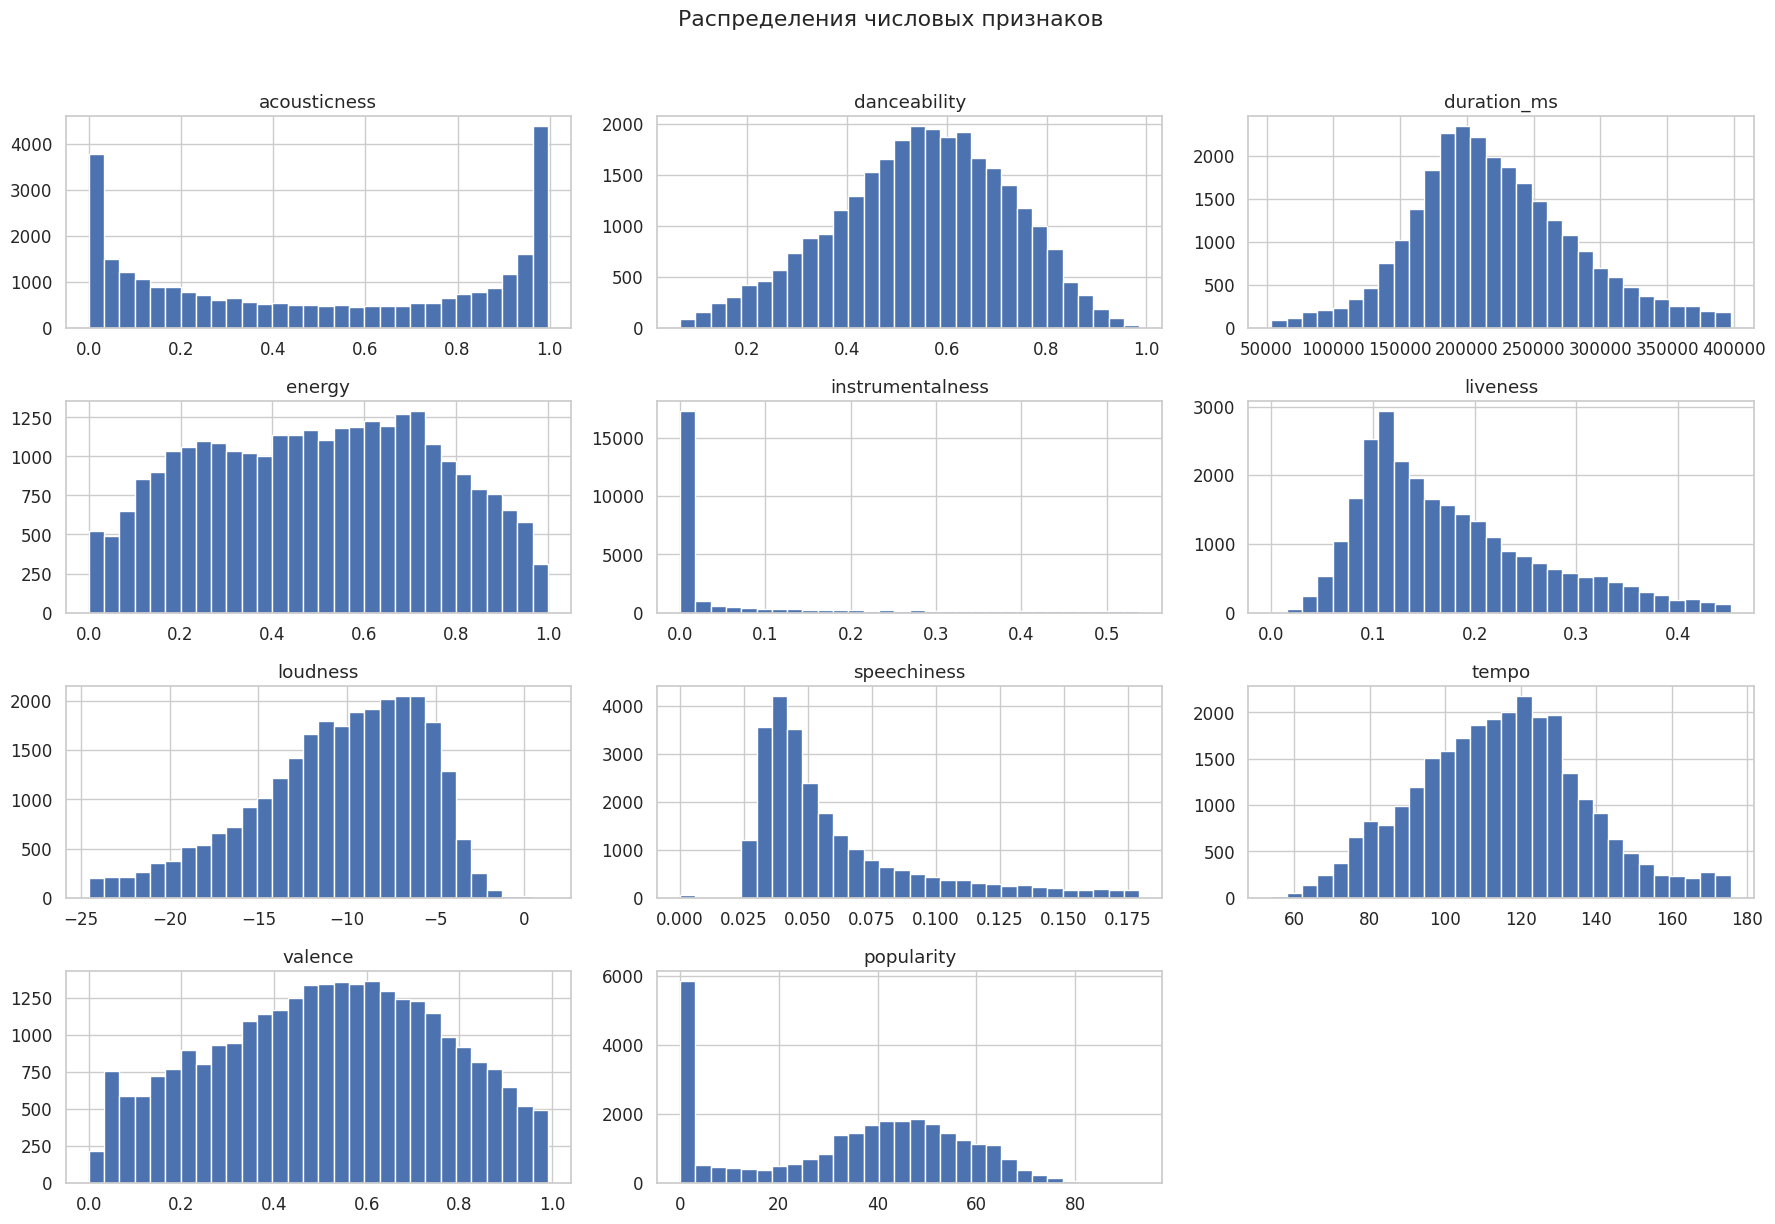

In [45]:
# Гистограммы распределений
data_clean_w_genres[numeric_cols].hist(bins=30, figsize=(18, 12))
plt.suptitle('Распределения числовых признаков', y=1.02)
plt.tight_layout()
plt.show()

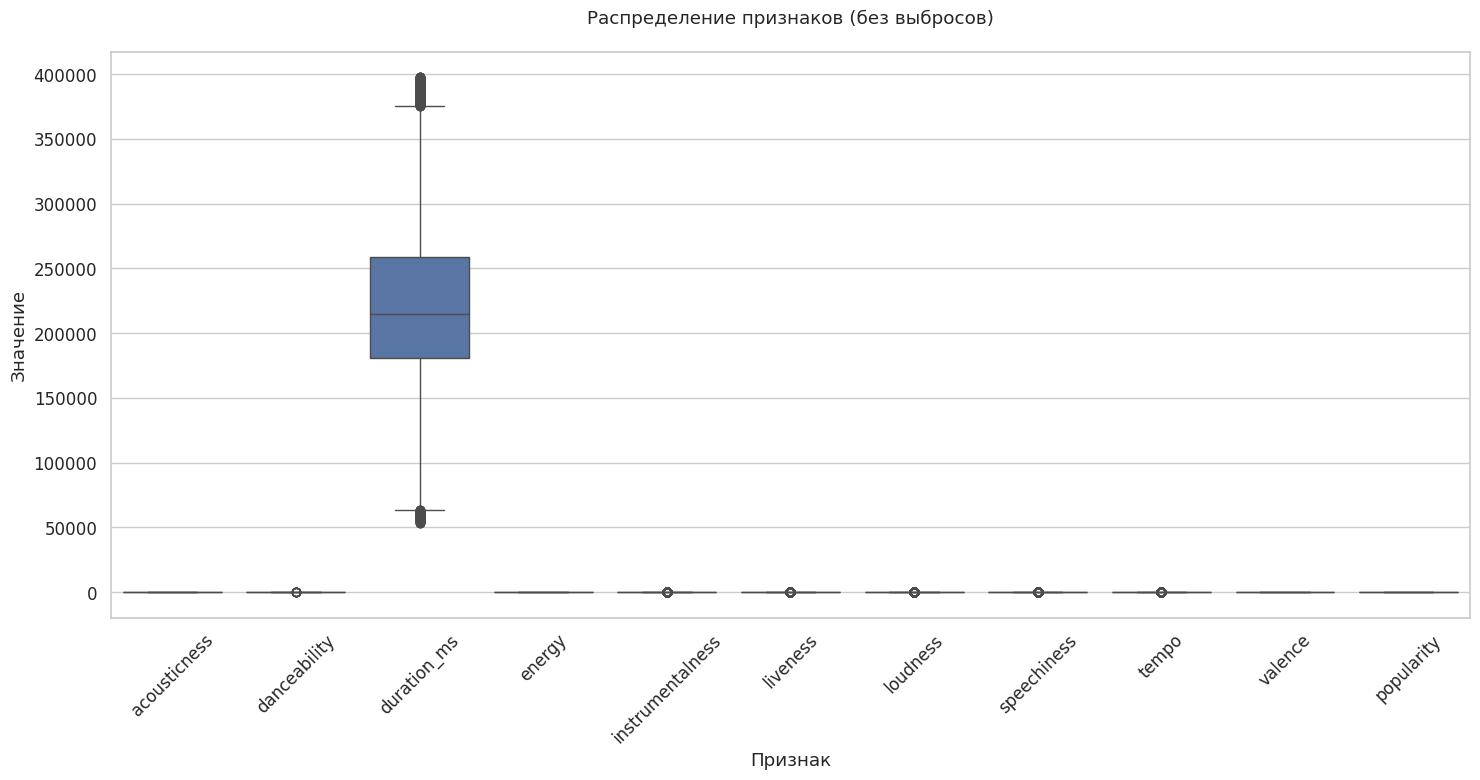

In [46]:
# Boxplot анализа
plt.figure(figsize=(15, 8))
data_melted = data_clean_w_genres[numeric_cols].melt()
sns.boxplot(x='variable', y='value', data=data_melted)
plt.title('Распределение признаков (без выбросов)', pad=20)
plt.xticks(rotation=45)
plt.xlabel('Признак')
plt.ylabel('Значение')
plt.tight_layout()
plt.show()

In [47]:
data_clean_w_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28680 entries, 0 to 28679
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genres            0 non-null      object 
 1   artists           0 non-null      object 
 2   acousticness      28680 non-null  float64
 3   danceability      28600 non-null  float64
 4   duration_ms       27035 non-null  float64
 5   energy            28680 non-null  float64
 6   instrumentalness  24122 non-null  float64
 7   liveness          27026 non-null  float64
 8   loudness          27817 non-null  float64
 9   speechiness       25082 non-null  float64
 10  tempo             27984 non-null  float64
 11  valence           28680 non-null  float64
 12  popularity        28680 non-null  float64
 13  key               0 non-null      float64
 14  mode              0 non-null      float64
 15  count             0 non-null      float64
dtypes: float64(14), object(2)
memory usage: 

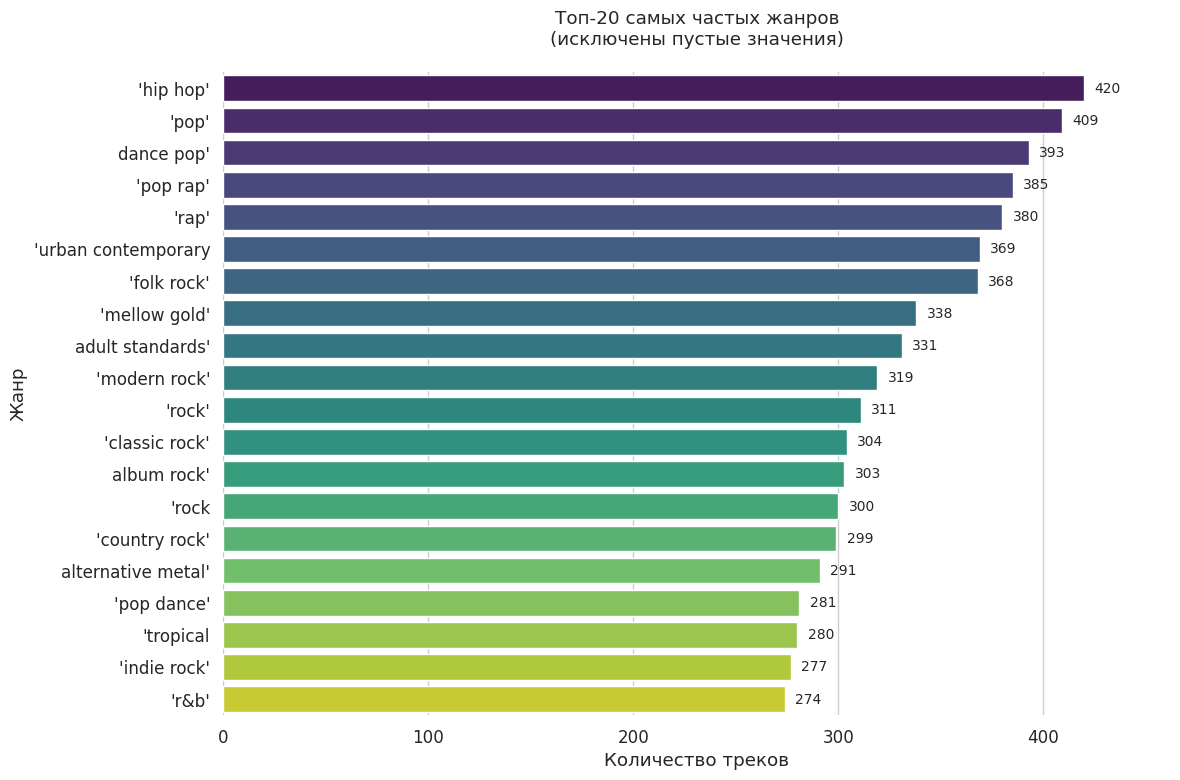

In [48]:
# Анализ популярности по жанрам

# 1. Извлекаем и очищаем жанры
all_genres = []
for genre_list in data_w_genres['genres']:
    # Удаляем скобки, кавычки и пробелы
    cleaned = genre_list.strip("[]'\" ")
    if cleaned:  # Только непустые значения
        # Разбиваем по запятым и добавляем в список
        genres = [g.strip() for g in cleaned.split(',') if g.strip()]
        all_genres.extend(genres)

# 2. Создаем Series с подсчетом жанров
genre_counts = pd.Series(all_genres).value_counts().head(20)

# 3. Подготовка данных для визуализации
plot_data = pd.DataFrame({
    'genre': genre_counts.index,
    'count': genre_counts.values
})

# 4. Визуализация 
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=plot_data,
    x='count',
    y='genre',
    hue='genre',  # Добавляем hue для palette
    palette="viridis",
    legend=False,  # Отключаем легенду
    dodge=False   # Отключаем разделение столбцов
)

# 5. Добавляем подписи значений
for p in barplot.patches:
    width = p.get_width()
    plt.text(width + 5,          # x-позиция текста
             p.get_y() + p.get_height()/2,  # y-позиция по центру бара
             f'{int(width)}',    # текст значения
             va='center',        # вертикальное выравнивание
             ha='left',          # горизонтальное выравнивание
             fontsize=10)

# 6. Настройка оформления
plt.title('Топ-20 самых частых жанров\n(исключены пустые значения)', pad=20)
plt.xlabel('Количество треков')
plt.ylabel('Жанр')
plt.xlim(0, genre_counts.max() * 1.1)  # Добавляем 10% места справа

# Убираем лишние линии графика
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()



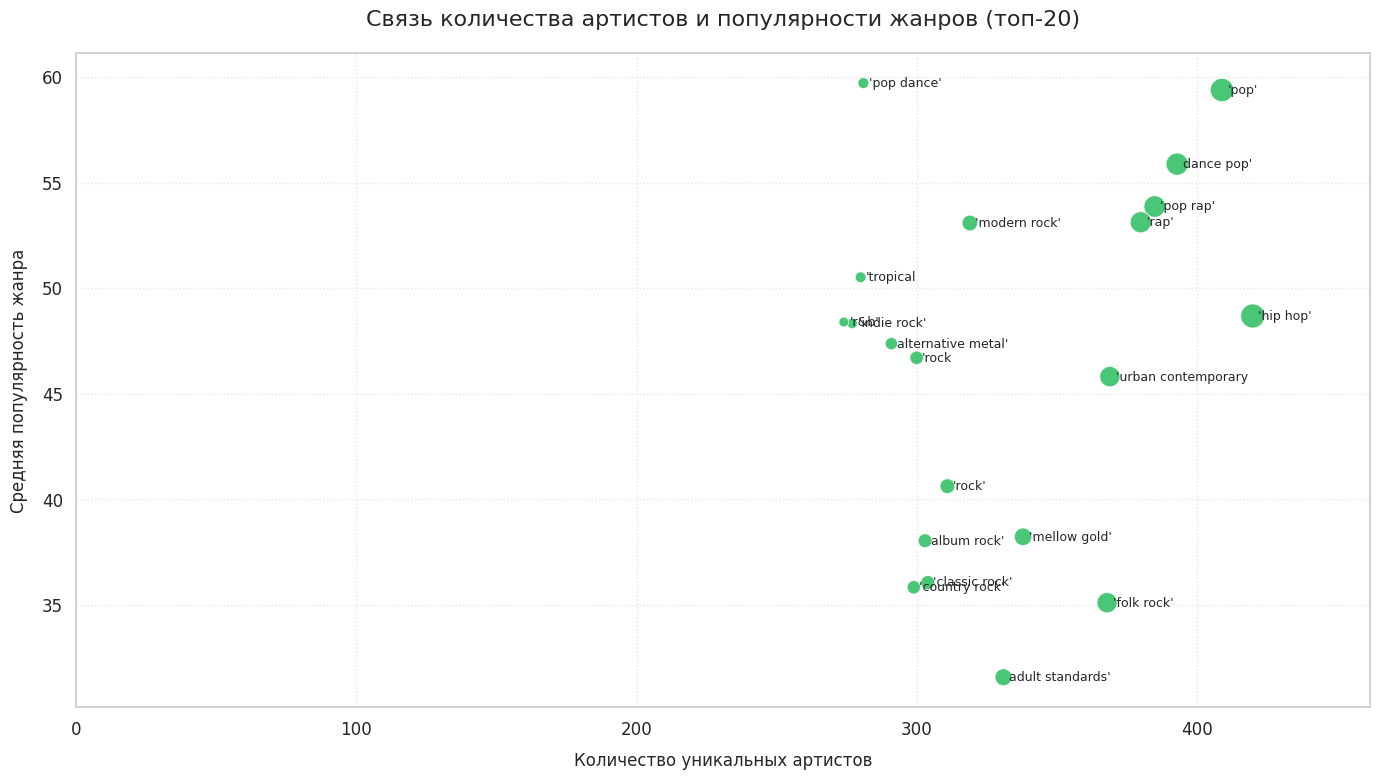

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Извлекаем и очищаем жанры 
all_genres = []
artist_genres = {}  # Словарь для хранения артистов по жанрам
genre_popularity = {}  # Словарь для хранения популярности по жанрам

for _, row in data_w_genres.iterrows():
    # Очистка жанров
    cleaned = row['genres'].strip("[]'\" ")
    if cleaned:
        genres = [g.strip() for g in cleaned.split(',') if g.strip()]
        all_genres.extend(genres)
        
        # Сохраняем артистов и популярность для каждого жанра
        for genre in genres:
            if genre not in artist_genres:
                artist_genres[genre] = set()
                genre_popularity[genre] = []
            
            artist_genres[genre].add(row['artists'])
            genre_popularity[genre].append(row['popularity'])

# 2. Создаем DataFrame с результатами
result = pd.DataFrame({
    'genre': list(artist_genres.keys()),
    'artist_count': [len(artists) for artists in artist_genres.values()],
    'avg_popularity': [sum(pops)/len(pops) for pops in genre_popularity.values()]
})

# 3. Фильтруем топ-20 жанров по количеству артистов
top_genres = result.sort_values('artist_count', ascending=False).head(20)

# 4. Построение графика
plt.figure(figsize=(14, 8))
ax = sns.scatterplot(
    data=top_genres,
    x='artist_count',
    y='avg_popularity',
    size='artist_count',
    sizes=(50, 300),
    alpha=0.8,
    color='#1DB954',  # Spotify green
    legend=False
)

# Добавляем подписи для топ-жанров
for _, row in top_genres.iterrows():
    ax.text(
        row['artist_count'] + 2,
        row['avg_popularity'],
        row['genre'],
        fontsize=9,
        ha='left',
        va='center'
    )

# Настройка оформления
plt.title('Связь количества артистов и популярности жанров (топ-20)', pad=20, fontsize=16)
plt.xlabel('Количество уникальных артистов', labelpad=10, fontsize=12)
plt.ylabel('Средняя популярность жанра', labelpad=10, fontsize=12)
plt.grid(True, linestyle=':', alpha=0.5)

# Улучшаем оси
plt.xlim(left=0)
max_artists = top_genres['artist_count'].max()
plt.xlim(right=max_artists * 1.1)

plt.tight_layout()
plt.show()

Выводы:
1. Acousticness - сильно отрицательно коррелирует с energy (-0.801) и loudness (-0.645). Это говорит о том, что более акустические треки обычно менее энергичные и громкие. Умеренно отрицательно коррелирует с popularity (-0.557), значит более акустические треки могут быть не такими популярными. Слабо отрицательно коррелирует с danceability (-0.429) и tempo (-0.300), что говорит о том, что акустичность имеет тенденцию уменьшаться в более танцевальных и быстрых песнях.

2. Danceability - умеренно положительно коррелирует с valence (0.593), что говорит о том, что более танцевальные песни, как правило, более позитивные. Слабо положительно коррелирует с energy (0.396) и loudness (0.411), что говорит о том, что более танцевальные песни, как правило, более энергичные и громкие.

3. Duration_ms - имеет низкие корреляции со всеми другими функциями, что говорит о том, что продолжительность песни не сильно связана с каким-либо другим параметром в наборе данных.

4. Energy - сильно положительно коррелирует с loudness (0.804). Это значит, что более энергичные песни также и громче. Умеренно положительно коррелирует с popularity (0.415) и danceability (0.396), что говорит о том, что более энергичные песни, как правило, более популярны и танцевальны. Слабо положительно коррелирует с tempo (0.325), что говорит о том, что энергичные песни, как правило, быстрее.

5. Instrumentalness - показывает низкую отрицательную корреляцию с loudness (-0.234) и popularity (-0.238), что указывает на то, что более инструментальные песни могут быть не такими громкими или популярными.

6. Liveness - показывает слабую корреляцию со всеми остальными характеристиками, что позволяет предположить, что наличие "живой" записи имеет незначительную линейную связь с другими характеристиками.

7. Loudness - сильно положительно коррелирует с energy (0.804), что указывает на то, что громкие песни, как правило, более энергичные. Умеренно положительно коррелирует с popularity (0.430) и danceability (0.411), что говорит о том, что более громкие песни часто более популярны и танцевальны.

8. Speechiness - показывает низкие корреляции со всеми другими функциями, хотя несколько положительных корреляций с danceability (0.233) и energy (0.176) предполагают слабую связь.

9. Tempo - показывает слабую положительную корреляцию с energy (0.325), что говорит о том, что более быстрые песни, как правило, более энергичные.

10. Valence - умеренно положительно коррелирует с danceability (0.593), что указывает на то, что песни с более высокой валентностью (более позитивные) также более танцевальны.

11. Popularity - умеренно положительно коррелирует с loudness (0.430) и energy (0.415), что указывает на то, что более популярные песни, как правило, более громкие и энергичные. Умеренно отрицательно коррелирует с acousticness (-0.557), что говорит о том, что более популярные песни могут быть менее акустическими.

12. Сильные корреляции между Energy, Loudness и Danceability могут быть полезными для создания плейлистов или рекомендаций. Также стоит отметить, что низкие корреляции с Duration_ms и Instrumentalness могут указывать на то, что эти аспекты не так важны для восприятия популярности трека.

### 5. Проведем анализ датасета data_by_genres

In [50]:
data_by_genres.head()

mode                  genres  acousticness  danceability   duration_ms  \
0     1  21st century classical      0.979333      0.162883  1.602977e+05   
1     1                   432hz      0.494780      0.299333  1.048887e+06   
2     1                   8-bit      0.762000      0.712000  1.151770e+05   
3     1                      []      0.651417      0.529093  2.328809e+05   
4     1              a cappella      0.676557      0.538961  1.906285e+05   

     energy  instrumentalness  liveness   loudness  speechiness       tempo  \
0  0.071317          0.606834  0.361600 -31.514333     0.040567   75.336500   
1  0.450678          0.477762  0.131000 -16.854000     0.076817  120.285667   
2  0.818000          0.876000  0.126000  -9.180000     0.047000  133.444000   
3  0.419146          0.205309  0.218696 -12.288965     0.107872  112.857352   
4  0.316434          0.003003  0.172254 -12.479387     0.082851  112.110362   

    valence  popularity  key  
0  0.103783   27.833333    6  
1  0.221750   52.500000    5  
2  0.975000   48.000000    7  
3  0.513604   20.859882    7  
4  0.448249   45.820071    7

In [51]:
data_by_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2973 entries, 0 to 2972
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              2973 non-null   int64  
 1   genres            2973 non-null   object 
 2   acousticness      2973 non-null   float64
 3   danceability      2973 non-null   float64
 4   duration_ms       2973 non-null   float64
 5   energy            2973 non-null   float64
 6   instrumentalness  2973 non-null   float64
 7   liveness          2973 non-null   float64
 8   loudness          2973 non-null   float64
 9   speechiness       2973 non-null   float64
 10  tempo             2973 non-null   float64
 11  valence           2973 non-null   float64
 12  popularity        2973 non-null   float64
 13  key               2973 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 325.3+ KB


In [52]:
data_by_genres.describe()

mode  acousticness  danceability   duration_ms       energy  \
count  2973.000000   2973.000000   2973.000000  2.973000e+03  2973.000000   
mean      0.833165      0.401241      0.537187  2.517209e+05     0.561143   
std       0.372891      0.319760      0.150668  9.465686e+04     0.234486   
min       0.000000      0.000003      0.056900  3.094600e+04     0.001002   
25%       1.000000      0.119050      0.441202  2.063788e+05     0.395058   
50%       1.000000      0.321745      0.546496  2.375453e+05     0.601195   
75%       1.000000      0.673991      0.647500  2.772720e+05     0.730127   
max       1.000000      0.996000      0.929000  2.382587e+06     0.994667   

       instrumentalness     liveness     loudness  speechiness        tempo  \
count       2973.000000  2973.000000  2973.000000  2973.000000  2973.000000   
mean           0.211366     0.192800   -10.509848     0.083588   119.018723   
std            0.267329     0.092356     5.369202     0.080483    17.469188   
min            0.000000     0.022200   -41.825000     0.023800    47.135722   
25%            0.004835     0.137687   -12.427656     0.044900   109.198143   
50%            0.080700     0.178764    -9.221817     0.059457   119.194167   
75%            0.343333     0.220856    -6.920125     0.091000   127.508750   
max            0.992000     0.960000     0.060000     0.946219   204.212000   

           valence   popularity          key  
count  2973.000000  2973.000000  2973.000000  
mean      0.492748    39.919185     5.938782  
std       0.201820    16.748723     3.368110  
min       0.003353     0.000000     0.000000  
25%       0.348578    32.491279     3.000000  
50%       0.500048    43.056569     7.000000  
75%       0.640257    51.138889     9.000000  
max       0.980000    80.666667    11.000000

In [53]:
# Удаление записей с пустыми жанрами
data_clean_genres = data_by_genres[data_by_genres['genres'] != '[]'].copy()

# Проверка
print(f"Оригинальный размер: {len(data_by_genres)}")
print(f"После очистки: {len(data_clean_genres)}")
print(f"Удалено записей: {len(data_by_genres) - len(data_clean_genres)}")

Оригинальный размер: 2973
После очистки: 2972
Удалено записей: 1


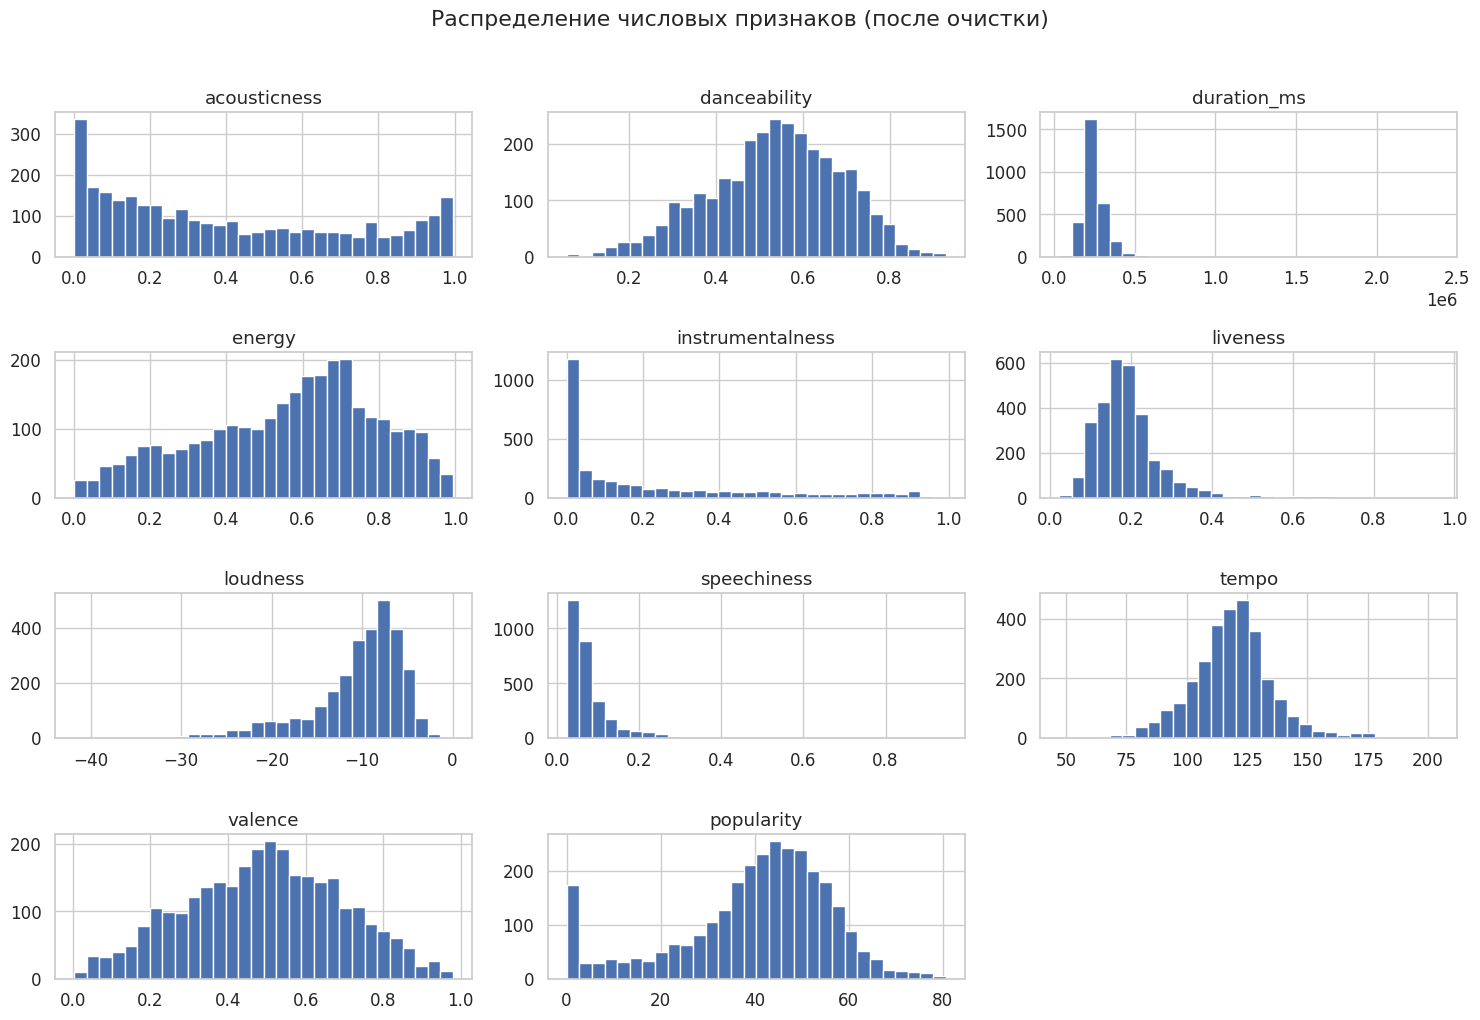

In [54]:
data_clean_genres[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle('Распределение числовых признаков (после очистки)', y=1.02)
plt.tight_layout()
plt.show()

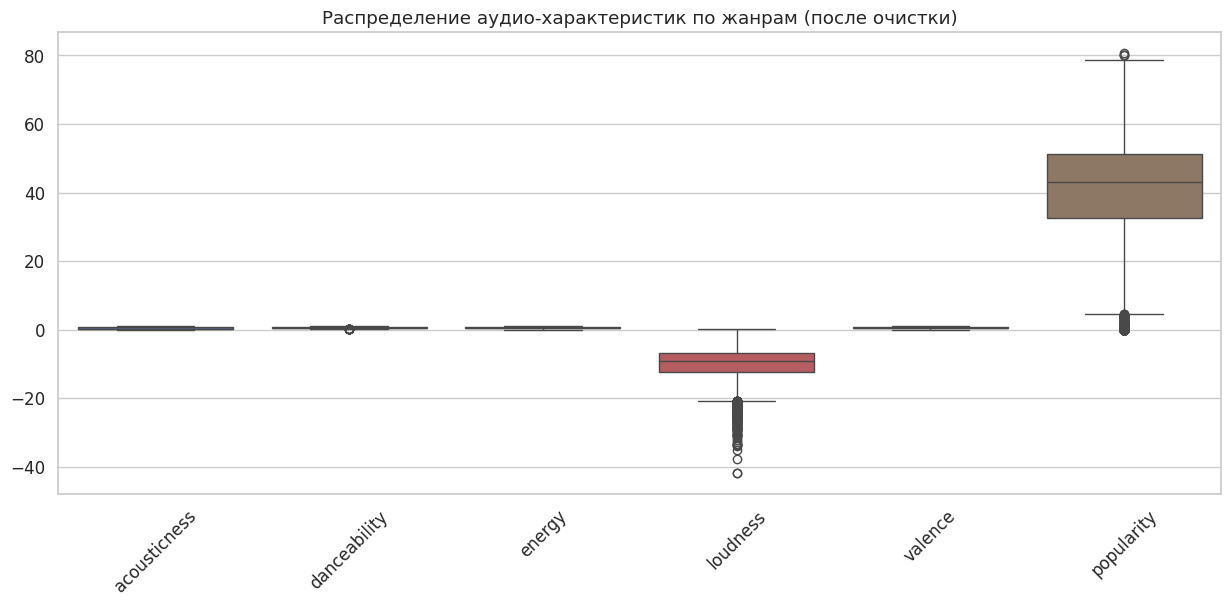

In [55]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=data_clean_genres[['acousticness', 'danceability', 'energy', 
                           'loudness', 'valence', 'popularity']])
plt.title('Распределение аудио-характеристик по жанрам (после очистки)')
plt.xticks(rotation=45)
plt.show()

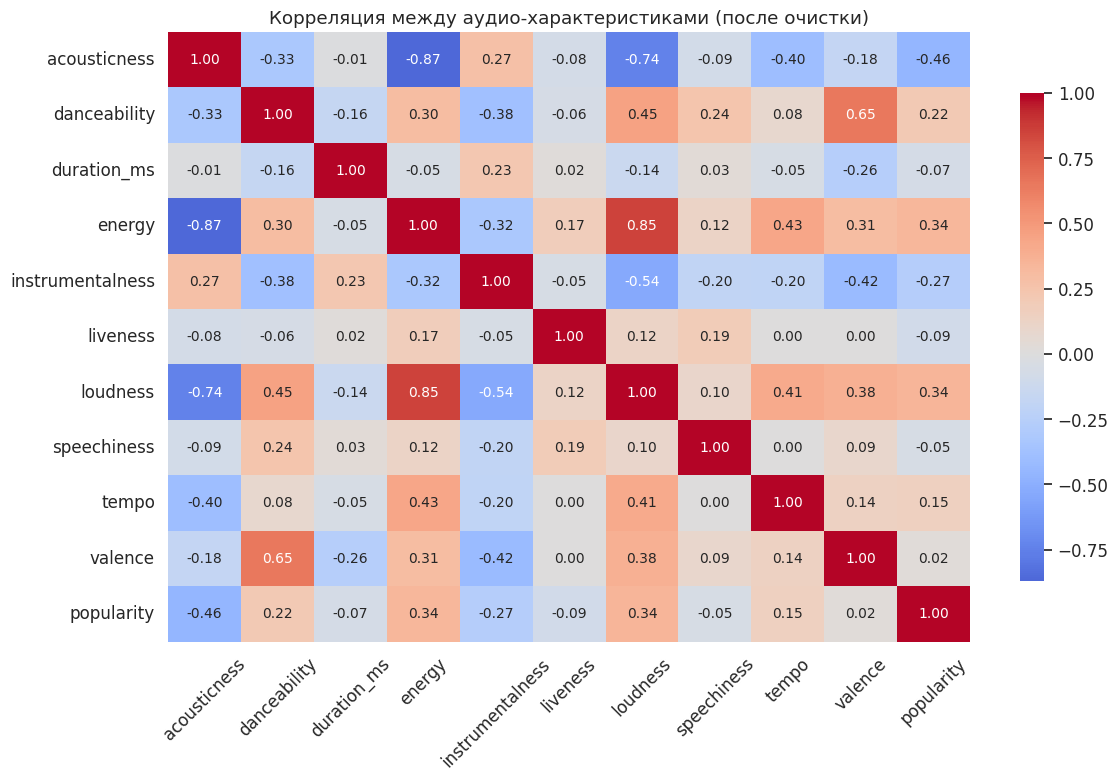

In [56]:
#  Корреляционный анализ
plt.figure(figsize=(12, 8))
corr_matrix = data_clean_genres[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            annot_kws={"size": 10}, cbar_kws={"shrink": .8})
plt.title('Корреляция между аудио-характеристиками (после очистки)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [57]:
corr_matrix

acousticness  danceability  duration_ms    energy  \
acousticness          1.000000     -0.325010    -0.014024 -0.868257   
danceability         -0.325010      1.000000    -0.160638  0.299788   
duration_ms          -0.014024     -0.160638     1.000000 -0.048202   
energy               -0.868257      0.299788    -0.048202  1.000000   
instrumentalness      0.273774     -0.383103     0.229421 -0.324964   
liveness             -0.076653     -0.055143     0.018643  0.168303   
loudness             -0.737279      0.453064    -0.137600  0.848966   
speechiness          -0.086229      0.242061     0.033247  0.119862   
tempo                -0.397669      0.082864    -0.046865  0.430789   
valence              -0.178256      0.652549    -0.257512  0.305207   
popularity           -0.458546      0.218019    -0.071111  0.337657   

                  instrumentalness  liveness  loudness  speechiness     tempo  \
acousticness              0.273774 -0.076653 -0.737279    -0.086229 -0.397669   
danceability             -0.383103 -0.055143  0.453064     0.242061  0.082864   
duration_ms               0.229421  0.018643 -0.137600     0.033247 -0.046865   
energy                   -0.324964  0.168303  0.848966     0.119862  0.430789   
instrumentalness          1.000000 -0.050614 -0.537682    -0.196764 -0.201670   
liveness                 -0.050614  1.000000  0.123981     0.190112  0.002318   
loudness                 -0.537682  0.123981  1.000000     0.095334  0.407962   
speechiness              -0.196764  0.190112  0.095334     1.000000  0.001482   
tempo                    -0.201670  0.002318  0.407962     0.001482  1.000000   
valence                  -0.424091  0.000720  0.376596     0.092671  0.139605   
popularity               -0.265516 -0.094092  0.344315    -0.045112  0.146617   

                   valence  popularity  
acousticness     -0.178256   -0.458546  
danceability      0.652549    0.218019  
duration_ms      -0.257512   -0.071111  
energy            0.305207    0.337657  
instrumentalness -0.424091   -0.265516  
liveness          0.000720   -0.094092  
loudness          0.376596    0.344315  
speechiness       0.092671   -0.045112  
tempo             0.139605    0.146617  
valence           1.000000    0.023117  
popularity        0.023117    1.000000

In [58]:
# Исключение мультиколлинеарных признаков
features = data_clean_genres.drop(columns=['loudness'])  # оставляем energy как более информативную

# Альтернативный подход - PCA для коррелированных признаков
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit_transform(data_clean_genres[['energy', 'loudness']])

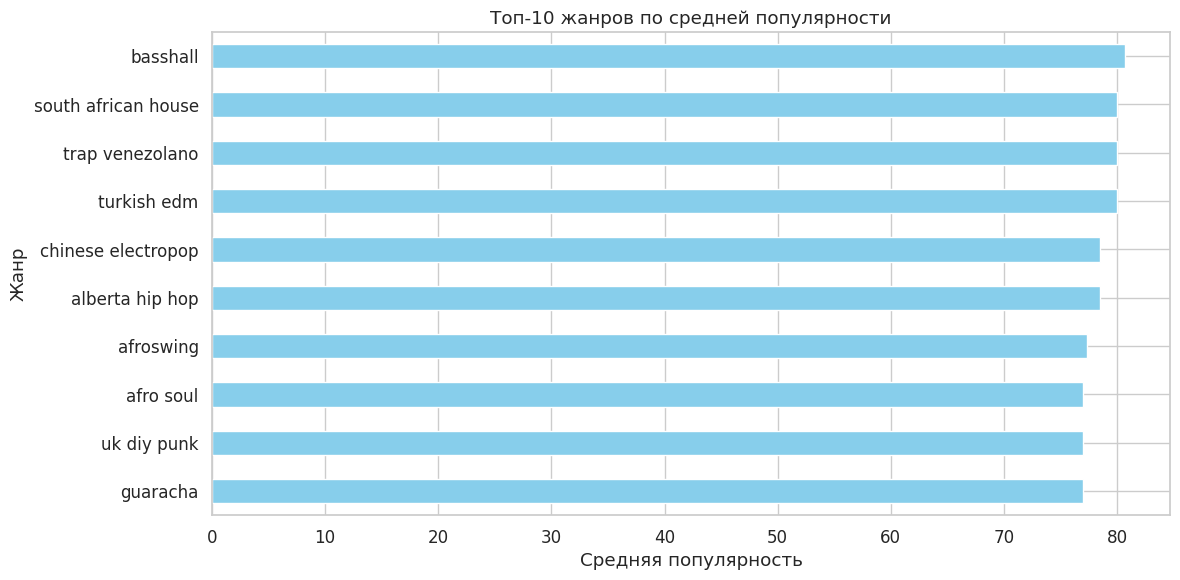

In [59]:
# Группировка по жанрам и расчет средней популярности
top_genres = (data_clean_genres.groupby('genres')['popularity']
              .mean()
              .sort_values(ascending=False)
              .head(10))

# Визуализация
plt.figure(figsize=(12, 6))
top_genres.plot(kind='barh', color='skyblue')
plt.title('Топ-10 жанров по средней популярности')
plt.xlabel('Средняя популярность')
plt.ylabel('Жанр')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

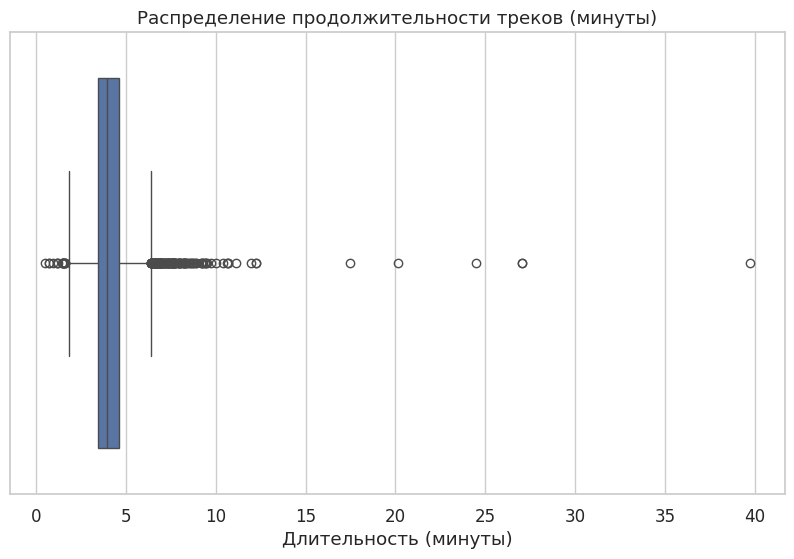

Количество выбросов в продолжительности: 136


In [60]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_clean_genres['duration_ms'] / 60000)  # Конвертация в минуты
plt.title('Распределение продолжительности треков (минуты)')
plt.xlabel('Длительность (минуты)')
plt.show()

# Количественный анализ выбросов
Q1 = data_clean_genres['duration_ms'].quantile(0.25)
Q3 = data_clean_genres['duration_ms'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
outliers = data_clean_genres[data_clean_genres['duration_ms'] > upper_bound]
print(f"Количество выбросов в продолжительности: {len(outliers)}")

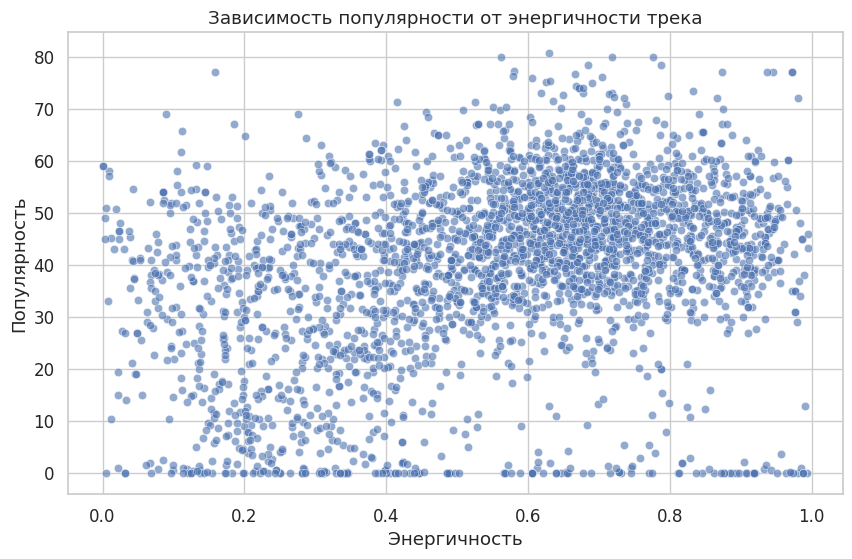

In [61]:
# Зависимость популярности от энергичности трека
plt.figure(figsize=(10, 6))
sns.scatterplot(x='energy', y='popularity', data=data_clean_genres, alpha=0.6)
plt.title('Зависимость популярности от энергичности трека')
plt.xlabel('Энергичность')
plt.ylabel('Популярность')
plt.show()

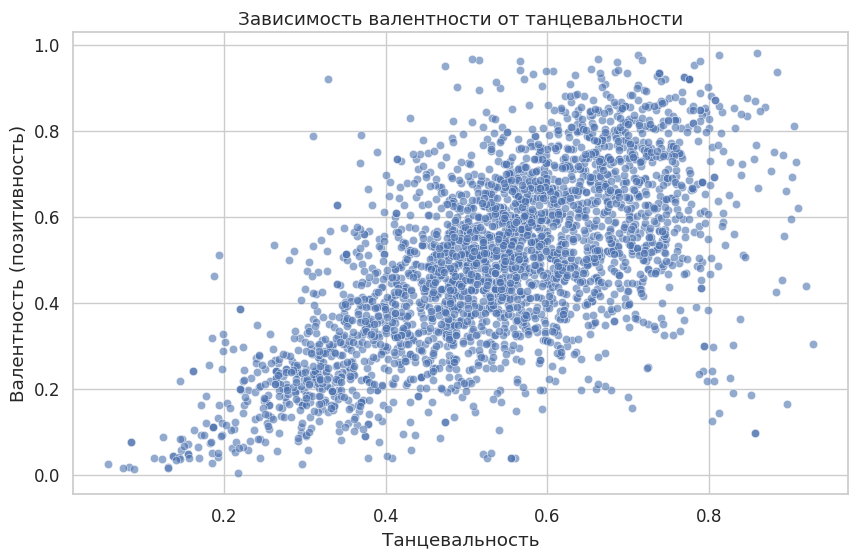

In [62]:
# Зависимость валентности от танцевальности
plt.figure(figsize=(10, 6))
sns.scatterplot(x='danceability', y='valence', data=data_clean_genres, alpha=0.6)
plt.title('Зависимость валентности от танцевальности')
plt.xlabel('Танцевальность')
plt.ylabel('Валентность (позитивность)')
plt.show()

Выводы: 
1. Сильные корреляции (|r| > 0.7)
energy ↔ loudness (0.83):
Чем выше энергия трека, тем он громче, так как энергичная музыка ,например, рок обычно имеет более высокий уровень громкости.

energy ↔ acousticness (-0.87):
Акустические треки (например, фолк или классика) почти всегда обладают низкой энергией. 

2. Для рекомендательной системы будем использовать energy, danceability, valence, popularity как основные фичи и исключим acousticness (из-за дублирования с energy).
   
3. Для кластеризации жанров добавим instrumentalness и tempo (уникальные паттерны для классики, электроники и др.).

### 6. Разработка рекомендательной системы (Контентная фильтрация) 

#### 6.1 предобработка данных

In [63]:
# Игнорируем предупреждения SettingWithCopy
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

## 1. предобработка данных

def preprocess_data(df, features):
    """Предобработка данных с обработкой копий DataFrame"""
    df = df.copy()  # Создаем явную копию, чтобы избежать SettingWithCopyWarning
    # Нормализация данных
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[features])
    # Создаем DataFrame с нормализованными признаками
    scaled_df = pd.DataFrame(scaled_features, columns=features, index=df.index)
    return df, scaled_df, scaler

# Выберем наиболее релевантные аудио-признаки
audio_features = ['danceability', 'energy', 'valence', 'acousticness', 
                 'loudness', 'tempo', 'instrumentalness', 'liveness', 
                 'speechiness']

# Предобработка основного датасета
cleaned_df, cleaned_df_scaled, scaler = preprocess_data(cleaned_df, audio_features)

#### 6.2 Кластеризация с обработкой предупреждений, используем k-means

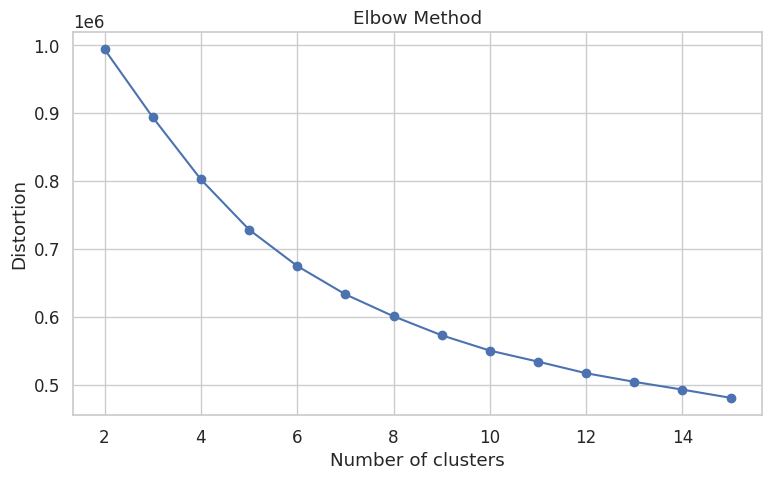

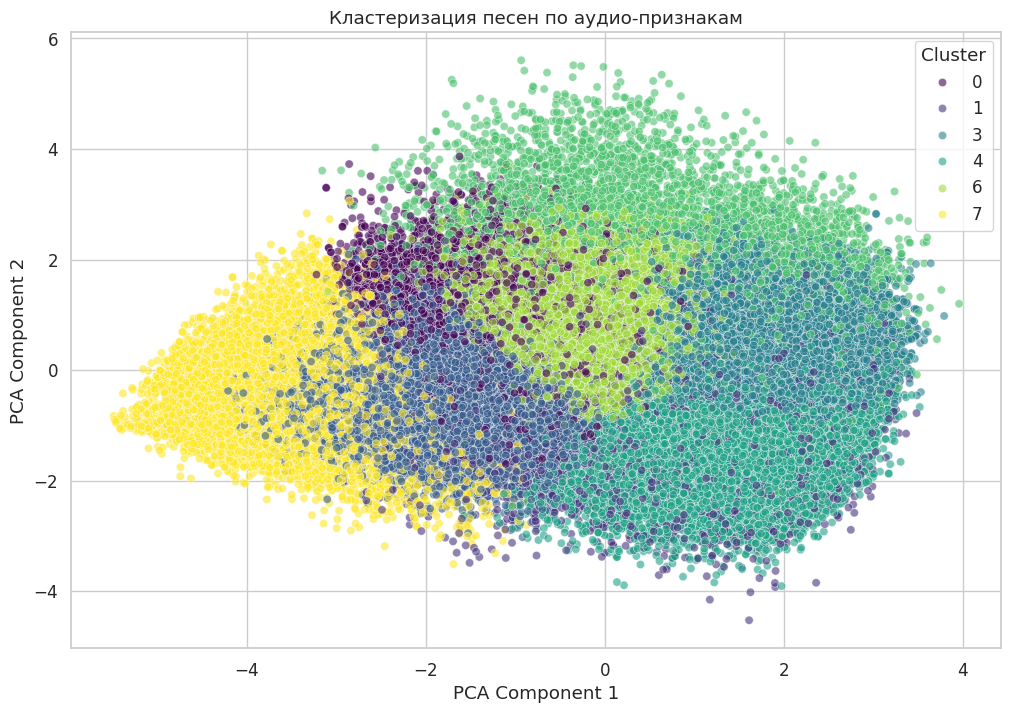

In [64]:
def find_optimal_clusters(data, max_k=15):
    """Определение оптимального числа кластеров с визуализацией"""
    distortions = []
    silhouette_scores = []
    
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Явно задаем n_init
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
        
        # Вычисляем silhouette score (может быть медленно для больших датасетов)
        if len(data) < 10000:  # Ограничиваем для больших датасетов
            silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    
    # Визуализация метода локтя
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_k+1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')
    
    # Визуализация silhouette score
    if silhouette_scores:
        plt.subplot(1, 2, 2)
        plt.plot(range(2, max_k+1), silhouette_scores, marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Score')
    
    plt.tight_layout()
    plt.show()

find_optimal_clusters(cleaned_df_scaled)

# Выбираем оптимальное число кластеров (на основе графиков)
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(cleaned_df_scaled)

# Добавляем кластеры в исходный DataFrame (без SettingWithCopyWarning)
cleaned_df = cleaned_df.copy()
cleaned_df.loc[:, 'cluster'] = clusters

# Визуализация кластеров с PCA
def visualize_clusters(data, features, clusters):
    """Визуализация кластеров с помощью PCA"""
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(data[features])
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], 
                    hue=clusters, palette='viridis', alpha=0.6)
    plt.title('Кластеризация песен по аудио-признакам')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.show()

visualize_clusters(cleaned_df_scaled, audio_features, clusters)

#### 6.3 Формируем класс рекомендательной системы

In [65]:
class ContentBasedRecommender:
    def __init__(self, data, features, scaler, n_neighbors=10):
        """Инициализация с явной передачей scaler"""
        self.data = data.copy()
        self.features = features
        self.scaler = scaler
        self.n_neighbors = n_neighbors
        self.model = None
        
    def fit(self):
        """Обучение модели ближайших соседей"""
        # Используем уже нормализованные данные
        scaled_features = self.scaler.transform(self.data[self.features])
        
        # Обучение модели с обработкой возможных предупреждений
        try:
            self.model = NearestNeighbors(n_neighbors=self.n_neighbors, metric='cosine')
            self.model.fit(scaled_features)
        except Exception as e:
            print(f"Ошибка при обучении модели: {e}")
            raise
        
    def recommend(self, song_id, n_recommendations=5):
        """Рекомендации на основе аудио-признаков"""
        try:
            # Находим индекс песни
            song_idx = self.data[self.data['id'] == song_id].index[0]
            
            # Получаем признаки для песни
            song_features = self.data.loc[song_idx, self.features].values.reshape(1, -1)
            scaled_features = self.scaler.transform(song_features)
            
            # Находим ближайших соседей
            distances, indices = self.model.kneighbors(scaled_features)
            
            # Формируем рекомендации
            recommendations = self.data.iloc[indices[0]].copy()
            recommendations['distance'] = distances[0]
            
            # Исключаем саму песню
            recommendations = recommendations[recommendations['id'] != song_id]
            
            return recommendations.head(n_recommendations)
        
        except Exception as e:
            print(f"Ошибка при формировании рекомендаций: {e}")
            return pd.DataFrame()
    
    def recommend_by_cluster(self, song_id, n_recommendations=5):
        """Рекомендации на основе кластера"""
        try:
            # Находим кластер песни
            song_cluster = self.data.loc[self.data['id'] == song_id, 'cluster'].values[0]
            
            # Получаем песни из того же кластера
            cluster_songs = self.data[self.data['cluster'] == song_cluster].copy()
            
            # Исключаем саму песню
            cluster_songs = cluster_songs[cluster_songs['id'] != song_id]
            
            # Сортируем по популярности (если есть столбец)
            if 'popularity' in cluster_songs.columns:
                cluster_songs = cluster_songs.sort_values('popularity', ascending=False)
            
            return cluster_songs.head(n_recommendations)
        
        except Exception as e:
            print(f"Ошибка при рекомендациях по кластеру: {e}")
            return pd.DataFrame()

# Инициализация и обучение рекомендательной системы
recommender = ContentBasedRecommender(cleaned_df, audio_features, scaler)
recommender.fit()

#### 6.4 Вывод результатов рекомендательной системы 

In [66]:
# Красивый вывод рекомендаций
def print_recommendations(title, recommendations):
    print(f"\n{title}:")
    if recommendations.empty:
        print("Не удалось найти рекомендации.")
    else:
        for i, (_, rec) in enumerate(recommendations.iterrows(), 1):
            print(f"{i}. {rec['name']} by {rec['artists']} (Кластер: {rec.get('cluster', 'N/A')})")

# Выбираем тестовую песню
test_song = cleaned_df.sample(1).iloc[0] # выберем случайным образом строку в датасете cleaned_df
print(f"\nТестовая песня: {test_song['name']} by {test_song['artists']}")
print(f"Кластер: {test_song['cluster']}")

# Получаем рекомендации
audio_recs = recommender.recommend(test_song['id'])
print_recommendations("Рекомендации на основе аудио-признаков", audio_recs)

cluster_recs = recommender.recommend_by_cluster(test_song['id'])
print_recommendations("Рекомендации на основе кластера", cluster_recs)

# Рекомендации для заданного жанра

def recommend_by_genre(genre, n_recommendations=5, popularity_threshold=30):
    try:
        # Проверяем, есть ли столбец 'genres' в data_w_genres
        if 'genres' not in data_w_genres.columns:
            print("Ошибка: столбец 'genres' не найден.")
            return pd.DataFrame()
        
        # Фильтруем артистов по жанру
        genre_mask = data_w_genres['genres'].str.contains(genre, case=False, na=False)
        genre_artists = data_w_genres[genre_mask].copy()
        
        if genre_artists.empty:
            print(f"Жанр '{genre}' не найден.")
            return pd.DataFrame()
        
        # Фильтруем по популярности
        if 'popularity' in genre_artists.columns:
            genre_artists = genre_artists[genre_artists['popularity'] > popularity_threshold]
        
        if genre_artists.empty:
            print(f"Нет популярных артистов в жанре '{genre}' (порог популярности: {popularity_threshold}).")
            return pd.DataFrame()
        
        # Выбираем случайного артиста
        artist = genre_artists.sample(1).iloc[0]
        
        # Ищем его песни в основном датасете
        artist_songs = cleaned_df[cleaned_df['artists'].str.contains(artist['artists'], case=False, na=False)]
        
        if artist_songs.empty:
            print(f"Не найдено песен для артиста {artist['artists']}.")
            return pd.DataFrame()
        
        # Выбираем случайную песню артиста
        song = artist_songs.sample(1).iloc[0]
        
        print(f"\nВыбрана песня для жанра '{genre}': {song['name']} by {song['artists']}")
        
        # Получаем рекомендации на основе кластера
        return recommender.recommend_by_cluster(song['id'], n_recommendations)
    
    except Exception as e:
        print(f"Ошибка при поиске рекомендаций по жанру: {e}")
        return pd.DataFrame()

# Пример использования с обработкой ошибок
print_recommendations("Рекомендации для жанра 'pop'", recommend_by_genre('pop'))
print_recommendations("Рекомендации для жанра 'jazz'", recommend_by_genre('jazz'))
print_recommendations("Рекомендации для несуществующего жанра", recommend_by_genre('nonexistent_genre'))


Тестовая песня: The Baker's Assistant by ['Joe Hisaishi']
Кластер: 1

Рекомендации на основе аудио-признаков:
1. Baso More Man Mein Nandlal by ['M. S. Subbulakshmi'] (Кластер: 2)
2. Quatuor à cordes No. 18 in A Major, K. 464: IV. Allegro by ['Wolfgang Amadeus Mozart', 'Juilliard String Quartet'] (Кластер: 7)
3. Capriccio espagnol, Op. 34: III. Alborada by ['Nikolai Rimsky-Korsakov', 'Philadelphia Orchestra', 'Eugene Ormandy'] (Кластер: 6)
4. Αλέντι by ['Λαϊκή Ορχήστρα Μιχάλη Φελουζή'] (Кластер: 1)
5. The Night People (1954) Main title by ['Cyril Mockridge'] (Кластер: 2)

Рекомендации на основе кластера:
1. death bed (coffee for your head) by ['Powfu', 'beabadoobee'] (Кластер: 1)
2. Life Goes On by ['BTS'] (Кластер: 1)
3. Stuck with U (with Justin Bieber) by ['Ariana Grande', 'Justin Bieber'] (Кластер: 1)
4. Mad at Disney by ['salem ilese'] (Кластер: 1)
5. ily (i love you baby) (feat. Emilee) by ['Surf Mesa', 'Emilee'] (Кластер: 1)

Выбрана песня для жанра 'pop': Deliver Us - The Princ

/home/dzmitry/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



#### Выводы: 

Код работает корректно, но результаты рекомендаций могут быть не всегда релевантными из-за возможных проблем с кластеризацией или данными. Возможна доработка в части учета жанра и временного периода.

### 7. Гибридная рекомендательная система

#### 7.1 Подготовка данных и кластеризация

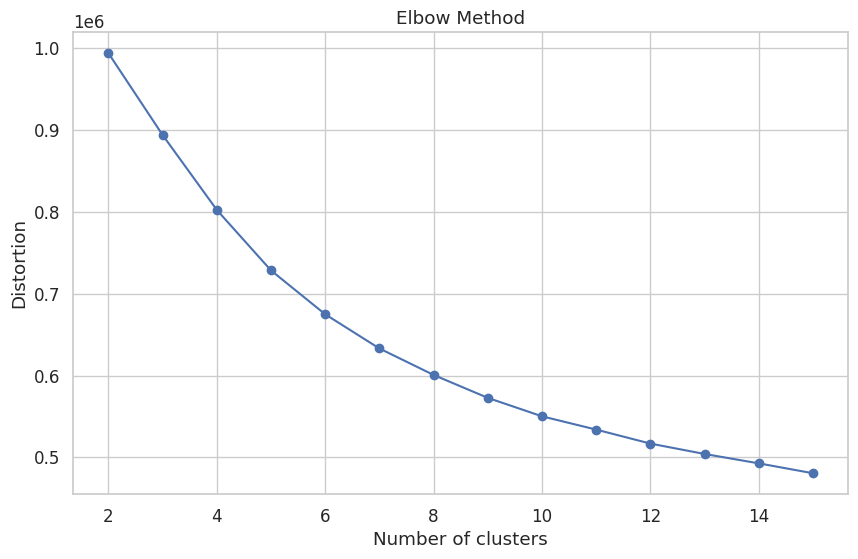

In [67]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

# Выбор аудио-признаков для анализа
audio_features = [
    'danceability', 'energy', 'valence', 'acousticness', 
    'loudness', 'tempo', 'instrumentalness', 'liveness', 
    'speechiness']

# Нормализация данных
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cleaned_df[audio_features])

def find_optimal_clusters(data, max_k=15):
    """Определяет оптимальное число кластеров методом локтя."""
    distortions = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_k + 1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')
    plt.show()

# Визуализация для выбора оптимального k
find_optimal_clusters(scaled_features)

# Кластеризация с выбранным числом кластеров
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_features)

# Добавляем кластерную информацию в копию датасета
cleaned_df = cleaned_df.copy()
cleaned_df['cluster'] = clusters

#### 7.2 Создание гибридной рекомендательной системы

In [68]:
class ContentBasedRecommender:
    """
    Класс для рекомендации песен на основе их содержательных характеристик (фич).
    Использует метод ближайших соседей для поиска похожих песен.
    """
    
    def __init__(self, data, features, scaler, n_neighbors=10):
        """
        Инициализация рекомендательной системы.
        
        Параметры:
        - data: DataFrame с данными о песнях
        - features: список фич, используемых для рекомендаций
        - scaler: объект для масштабирования фич (например, StandardScaler)
        - n_neighbors: количество соседей для модели NearestNeighbors
        """
        self.data = data.copy()  # Копируем данные, чтобы избежать изменений оригинального DataFrame
        self.features = features  # Фичи, используемые для рекомендаций
        self.scaler = scaler  # Объект для масштабирования фич
        self.n_neighbors = n_neighbors  # Количество соседей
        self.model = None  # Модель ближайших соседей (инициализируется в методе fit)
        
    def fit(self):
        """
        Обучение модели рекомендательной системы.
        Масштабирует фичи и обучает модель NearestNeighbors.
        """
        # Масштабируем фичи
        scaled_features = self.scaler.fit_transform(self.data[self.features])
        # Инициализируем и обучаем модель ближайших соседей
        # Добавляем +1 к n_neighbors, так как первый сосед - сама песня
        self.model = NearestNeighbors(n_neighbors=self.n_neighbors+1, metric='cosine')
        self.model.fit(scaled_features)
        
    def recommend(self, song_id, n_recommendations=5):
        """
        Рекомендация песен, похожих на заданную по фичам.
        
        Параметры:
        - song_id: ID песни, для которой ищем рекомендации
        - n_recommendations: количество рекомендаций
        
        Возвращает:
        - DataFrame с рекомендациями и их схожестью
        """
        try:
            # Проверяем, что песня есть в данных
            if song_id not in self.data['id'].values:
                return pd.DataFrame()
                
            # Находим индекс песни в данных
            song_idx = self.data[self.data['id'] == song_id].index[0]
            # Получаем фичи песни и преобразуем их для модели
            song_features = self.data.loc[song_idx, self.features].values.reshape(1, -1)
            scaled_features = self.scaler.transform(song_features)
            
            # Находим ближайших соседей
            distances, indices = self.model.kneighbors(scaled_features)
            
            # Формируем рекомендации (исключаем саму песню - первый элемент)
            recommendations = self.data.iloc[indices[0][1:n_recommendations+1]].copy()
            # Преобразуем расстояния в схожесть (1 - distance)
            recommendations['similarity'] = 1 - distances[0][1:n_recommendations+1]
            
            # Возвращаем только нужные колонки
            return recommendations[['id', 'name', 'artists', 'similarity', 'cluster', 'popularity']]
        except Exception as e:
            print(f"Error in recommend: {e}")
            return pd.DataFrame()
    
    def recommend_by_cluster(self, song_id, n_recommendations=5):
        """
        Рекомендация песен из того же кластера, что и заданная песня.
        Сортирует по популярности и добавляет случайность для разнообразия.
        
        Параметры:
        - song_id: ID песни, для которой ищем рекомендации
        - n_recommendations: количество рекомендаций
        
        Возвращает:
        - DataFrame с рекомендациями из того же кластера
        """
        try:
            # Проверяем, что песня есть в данных
            if song_id not in self.data['id'].values:
                return pd.DataFrame()
                
            # Получаем кластер заданной песни
            song_cluster = self.data.loc[self.data['id'] == song_id, 'cluster'].values[0]
            # Выбираем все песни из этого кластера, исключая саму песню
            cluster_songs = self.data[self.data['cluster'] == song_cluster].copy()
            cluster_songs = cluster_songs[cluster_songs['id'] != song_id]
            
            # Сортируем по популярности и добавляем случайность для разнообразия
            cluster_songs = cluster_songs.sample(frac=1, random_state=42)\
                                       .sort_values('popularity', ascending=False)
            
            # Возвращаем топ-N рекомендаций
            return cluster_songs[['id', 'name', 'artists', 'cluster', 'popularity']]\
                   .head(n_recommendations)
        except Exception as e:
            print(f"Error in recommend_by_cluster: {e}")
            return pd.DataFrame()

In [69]:
class HybridRecommender:
    """
    Гибридная рекомендательная система, объединяющая контентные рекомендации 
    и рекомендации по кластерам для улучшения качества рекомендаций.
    """
    
    def __init__(self, content_recommender, data):
        """
        Инициализация гибридного рекомендателя.
        
        Параметры:
        - content_recommender: обученный объект ContentBasedRecommender
        - data: DataFrame с данными о песнях (должен содержать те же данные, что и у content_recommender)
        """
        self.content_recommender = content_recommender  # Объект контентного рекомендателя
        self.data = data  # Данные о песнях
    
    def hybrid_recommend(self, song_id, n_recommendations=5, content_weight=0.7):
        """
        Генерация гибридных рекомендаций с учетом как содержательных характеристик,
        так и принадлежности к кластеру.
        
        Параметры:
        - song_id: ID песни, для которой ищем рекомендации
        - n_recommendations: количество возвращаемых рекомендаций (по умолчанию 5)
        - content_weight: вес контентных рекомендаций (от 0 до 1, по умолчанию 0.7)
                         вес рекомендаций по кластеру будет (1 - content_weight)
        
        Возвращает:
        - DataFrame с объединенными и отсортированными рекомендациями,
          содержащий колонки: id, name, artists, weight (нормализованный показатель важности)
        """
        try:
            # Проверка наличия песни в базе данных
            if song_id not in self.data['id'].values:
                return pd.DataFrame()
                
            # Получаем оба типа рекомендаций
            content_recs = self.content_recommender.recommend(song_id, n_recommendations)
            cluster_recs = self.content_recommender.recommend_by_cluster(song_id, n_recommendations)
            
            # Если оба типа рекомендаций пустые - возвращаем пустой DataFrame
            if content_recs.empty and cluster_recs.empty:
                return pd.DataFrame()
                
            # Создаем объединенный DataFrame для результатов
            combined = pd.DataFrame()
            
            # Обрабатываем контентные рекомендации (если они есть)
            if not content_recs.empty:
                # Вес контентных рекомендаций = вес * схожесть
                content_recs['weight'] = content_weight * content_recs['similarity']
                combined = pd.concat([combined, content_recs])
            
            # Обрабатываем рекомендации по кластеру (если они есть)
            if not cluster_recs.empty:
                # Вес рекомендаций по кластеру = (1 - content_weight) * нормализованная популярность
                cluster_recs['weight'] = (1 - content_weight) * (cluster_recs['popularity'] / 100)
                combined = pd.concat([combined, cluster_recs])
            
            # Удаляем дубликаты (если песня попала в оба типа рекомендаций)
            combined = combined.drop_duplicates(subset='id')
            # Сортируем по весу (по убыванию)
            combined = combined.sort_values('weight', ascending=False)
            
            # Нормализуем веса к диапазону [0, 1] для удобства интерпретации
            if not combined.empty:
                combined['weight'] = combined['weight'] / combined['weight'].max()
            
            # Возвращаем топ-N рекомендаций
            return combined.head(n_recommendations)
            
        except Exception as e:
            print(f"Error in hybrid_recommend: {e}")
            return pd.DataFrame()

#### 7.3. Инициализация и тестирование системы рекомендаций

In [70]:
# Инициализация рекомендательной системы
scaler = StandardScaler()
content_recommender = ContentBasedRecommender(cleaned_df, audio_features, scaler)
content_recommender.fit()
hybrid_recommender = HybridRecommender(content_recommender, cleaned_df)

def print_recommendations(song_id, n=5):
    """
    Выводит рекомендации выбранной песни с информацией о схожести и кластере.
    Если итоговая гибридная оценка не сформирована (например, когда один из методов не дал результатов),
    используется альтернативная метрика схожести (content_similarity или cluster_similarity).
    """
    try:
        song = cleaned_df[cleaned_df['id'] == song_id].iloc[0]
    except IndexError:
        print(f"Песня с id {song_id} не найдена.")
        return

    print(f"\nРекомендации для песни: {song['name']} by {song['artists']}")
    print(f"Кластер: {song['cluster']}")

    # Получение рекомендаций
    hybrid_rec = hybrid_recommender.hybrid_recommend(song_id, n)

    if hybrid_rec.empty:
        print("Не удалось получить рекомендации.")
        return

    print("\nТоп рекомендаций:")
    for i, (_, row) in enumerate(hybrid_rec.iterrows(), 1):
        name = row.get('name', 'Unknown')
        artists = row.get('artists', 'Unknown')
        cluster_val = row.get('cluster', 'Unknown')
        score = row.get('weight', np.nan)
        print(f"{i}. {name} by {artists} (Схожесть: {score:.2f}, Кластер: {cluster_val})")

if __name__ == "__main__":
    # Тестирование на случайной песне
    sample_song = cleaned_df.sample(1).iloc[0]
    print_recommendations(sample_song['id'])
    
    # Тестирование на популярной песне 
    if 'popularity' in cleaned_df.columns:
        popular_songs = cleaned_df[cleaned_df['popularity'] > 80]
        if not popular_songs.empty:
            popular_song = popular_songs.sample(1).iloc[0]
            print_recommendations(popular_song['id'])
        else:
            print("Нет песен с популярностью выше 80 для теста.")
    
    # Тестирование на песне из определенного жанра 
    if 'data_w_genres' in globals() and 'genres' in data_w_genres.columns:
        rock_artists = data_w_genres[data_w_genres['genres'].str.contains('rock', case=False)]
        if not rock_artists.empty:
            rock_artist = rock_artists.iloc[0]
            matched_songs = cleaned_df[cleaned_df['artists'].str.contains(rock_artist['artists'], case=False)]
            if not matched_songs.empty:
                rock_song = matched_songs.iloc[0]
                print_recommendations(rock_song['id'])
            else:
                print("Не найдены песни соответствующие рок-артисту.")
        else:
            print("Нет данных для жанра rock.")



Рекомендации для песни: Un Angel Llora by ['Annette Moreno']
Кластер: 3

Топ рекомендаций:
1. 100 Years by ['Five For Fighting'] (Схожесть: 1.00, Кластер: 3)
2. Same Script, Different Cast by ['Whitney Houston', 'Deborah Cox'] (Схожесть: 0.99, Кластер: 3)
3. Quiero decirte que te amo by ['Laura Pausini'] (Схожесть: 0.99, Кластер: 3)
4. If You're Not The One by ['Daniel Bedingfield'] (Схожесть: 0.99, Кластер: 3)
5. Guardian de mi Corazón by ['Annette Moreno'] (Схожесть: 0.99, Кластер: 3)

Рекомендации для песни: Let Me Love You by ['DJ Snake', 'Justin Bieber']
Кластер: 3

Топ рекомендаций:
1. Bleeding Love by ['Leona Lewis'] (Схожесть: 1.00, Кластер: 3)
2. Bleeding Love by ['Leona Lewis'] (Схожесть: 1.00, Кластер: 3)
3. Bleeding Love by ['Leona Lewis'] (Схожесть: 1.00, Кластер: 3)
4. What's Up Danger (with Black Caviar) by ['Blackway', 'Black Caviar'] (Схожесть: 1.00, Кластер: 3)
5. Running Out by ['Matoma', 'Astrid S'] (Схожесть: 0.99, Кластер: 3)

Рекомендации для песни: Amish Paradi

#### Выводы:
1. Высокая схожесть рекомендаций: Большинство рекомендованных песен имеют высокие показатели схожести (0.97–1.00), что говорит о хорошей работе алгоритма кластеризации или коллаборативной фильтрации.

2. Логичная группировка по кластерам: В первом примере (Un Angel Llora) рекомендации выглядят тематически связанными (эмоциональные, лирические треки).

3. Учет исполнителя: В случае с Annette Moreno система корректно предлагает другую песню того же исполнителя (Guardian de mi Corazón).
   
4. Система демонстрирует хорошую техническую работу (высокие показатели сходства), но требует доработки в логике рекомендаций (особенно для нестандартных треков) и устранения артефактов в выводах.



### 8. Оценка модели

#### 8.1 Вариант 1  

Введем метрику "Coverage", т.е. сколько уникальных треков мы рекомендуем 

#### 8.1.1  Настройка стилей графиков 

In [71]:
# Настройка стилей графиков (используем доступный стиль)
available_styles = plt.style.available
preferred_styles = ['seaborn-v0_8', 'ggplot', 'seaborn', 'default']
selected_style = next((style for style in preferred_styles if style in available_styles), 'default')

plt.style.use(selected_style)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Отключим предупреждения для чистоты вывода
warnings.filterwarnings('ignore', category=UserWarning)

#### 8.1.2 Загрузка и подготовка данных

In [72]:
# Загрузка и подготовка данных
def load_and_prepare_data():
       
    # Добавим кластеризацию по музыкальным характеристикам
    audio_features = ['danceability', 'energy', 'valence', 'acousticness', 
                 'loudness', 'tempo', 'instrumentalness', 'liveness', 
                 'speechiness']
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(cleaned_df[audio_features])
    
    # Кластеризация K-means (используем мини-пакет для ускорения)
    from sklearn.cluster import MiniBatchKMeans
    kmeans = MiniBatchKMeans(n_clusters=10, random_state=42, batch_size=1000)
    cleaned_df['cluster'] = kmeans.fit_predict(scaled_features)
    
    return cleaned_df, audio_features

#### 8.1.3 Метод оценки рекомендаций 

In [73]:
def evaluate_recommendations(recommender, validation_data, k_values=[5, 10, 20]):
    results = []
    all_recommended_ids = set()  # Для подсчета общего Coverage
    
    for k in k_values:
        precisions = []
        recalls = []
        f1_scores = []
        cluster_distributions = []
        coverage_counts = set()  # Уникальные рекомендованные треки для текущего K
        
        for _, row in validation_data.iterrows():
            song_id = row['id']
            recommendations = recommender.hybrid_recommend(song_id, n_recommendations=k)
            
            if recommendations.empty:
                continue
                
            seed_cluster = recommender.data[recommender.data['id'] == song_id]['cluster'].values[0]
            recommended_clusters = recommendations['cluster'].values
            
            # Основные метрики
            relevant = (recommended_clusters == seed_cluster).sum()
            precision = relevant / len(recommended_clusters)
            recall = relevant / k
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
            
            # Для Coverage: собираем уникальные ID рекомендованных треков
            coverage_counts.update(recommendations['id'].values)
            
            cluster_distributions.append(pd.Series(recommended_clusters).value_counts(normalize=True))
        
        avg_precision = np.mean(precisions) if precisions else 0
        avg_recall = np.mean(recalls) if recalls else 0
        avg_f1 = np.mean(f1_scores) if f1_scores else 0
        
        # Coverage = % уникальных треков от общего числа в данных
        total_songs = len(recommender.data['id'].unique())
        coverage = len(coverage_counts) / total_songs if total_songs > 0 else 0
        all_recommended_ids.update(coverage_counts)  # Добавляем в общий пул
        
        cluster_stats = pd.concat(cluster_distributions, axis=1).mean(axis=1) if cluster_distributions else pd.Series()
        
        results.append({
            'K': k,
            'Precision@K': avg_precision,
            'Recall@K': avg_recall,
            'F1@K': avg_f1,
            'Coverage': coverage,
            'Evaluated_Users': len(precisions),
            'Cluster_Distribution': cluster_stats
        })
    
    # Общий Coverage для всех K
    total_coverage = len(all_recommended_ids) / total_songs if total_songs > 0 else 0
    print(f"\nОбщий Coverage (уникальных треков рекомендовано): {total_coverage:.1%}")
    
    return pd.DataFrame(results)

#### 8.1.4 Метод визуализации метрик

In [74]:
def visualize_metrics(metrics_df):
    """Обновленная визуализация с Coverage"""
    if metrics_df.empty:
        print("Нет данных для визуализации")
        return
    
    with plt.style.context(selected_style):
        # 1. Основные метрики
        plt.figure(figsize=(14, 10))
        
        plt.subplot(2, 2, 1)
        metrics = ['Precision@K', 'Recall@K', 'F1@K']
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        
        for i, metric in enumerate(metrics):
            plt.plot(metrics_df['K'], metrics_df[metric], 
                    marker='o', label=metric, color=colors[i], linewidth=2.5)
        
        plt.title('Основные метрики качества', fontsize=12)
        plt.xlabel('Количество рекомендаций (K)', fontsize=10)
        plt.ylabel('Значение метрики', fontsize=10)
        plt.xticks(metrics_df['K'])
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        
        # 2. Coverage
        plt.subplot(2, 2, 2)
        plt.bar(metrics_df['K'], metrics_df['Coverage'], color='#9467bd')
        plt.title('Coverage (покрытие рекомендаций)', fontsize=12)
        plt.xlabel('Количество рекомендаций (K)', fontsize=10)
        plt.ylabel('Доля уникальных треков', fontsize=10)
        plt.xticks(metrics_df['K'])
        plt.grid(True, alpha=0.3)
        
        # 3. Heatmap корреляции
        plt.subplot(2, 2, 3)
        corr = metrics_df[metrics + ['Coverage']].corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f",
                   annot_kws={"size": 10}, cbar_kws={"shrink": 0.8})
        plt.title('Корреляция между метриками', fontsize=12)
        
        plt.tight_layout()
        plt.show()

#### 8.1.5 Метод визуализации рекомендаций

In [75]:
def visualize_recommendations(recommendations, seed_song_info):
    """Визуализация рекомендаций"""
    if recommendations.empty:
        print("Нет рекомендаций для визуализации")
        return
    
    with plt.style.context(selected_style):
        plt.figure(figsize=(14, 6))
        
        # 1. Веса рекомендаций
        plt.subplot(1, 2, 1)
        sns.barplot(data=recommendations, x='weight', y='name', 
                   hue='cluster', palette='viridis', dodge=False)
        plt.title('Вес рекомендаций', fontsize=12)
        plt.xlabel('Вес', fontsize=10)
        plt.ylabel('')
        plt.legend(title='Кластер', fontsize=8)
        
        # 2. Распределение по кластерам
        plt.subplot(1, 2, 2)
        cluster_counts = recommendations['cluster'].value_counts()
        plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%',
               colors=sns.color_palette('viridis', len(cluster_counts)))
        plt.title('Распределение по кластерам', fontsize=12)
        
        plt.suptitle(f'Рекомендации для: {seed_song_info}', fontsize=14)
        plt.tight_layout()
        plt.show()

#### 8.1.6 Загрузка и исполнение данных


Рекомендации для: Paparazzi - ['Lady Gaga']

Топ рекомендаций:
              name                          artists   weight  cluster
         Paparazzi                    ['Lady Gaga'] 1.000000        9
    Semi-Automatic            ['Twenty One Pilots'] 0.988359        9
Habits (Stay High)                      ['Tove Lo'] 0.986832        6
        The Middle ['Zedd', 'Maren Morris', 'Grey'] 0.986575        9
            ARTPOP                    ['Lady Gaga'] 0.984856        9


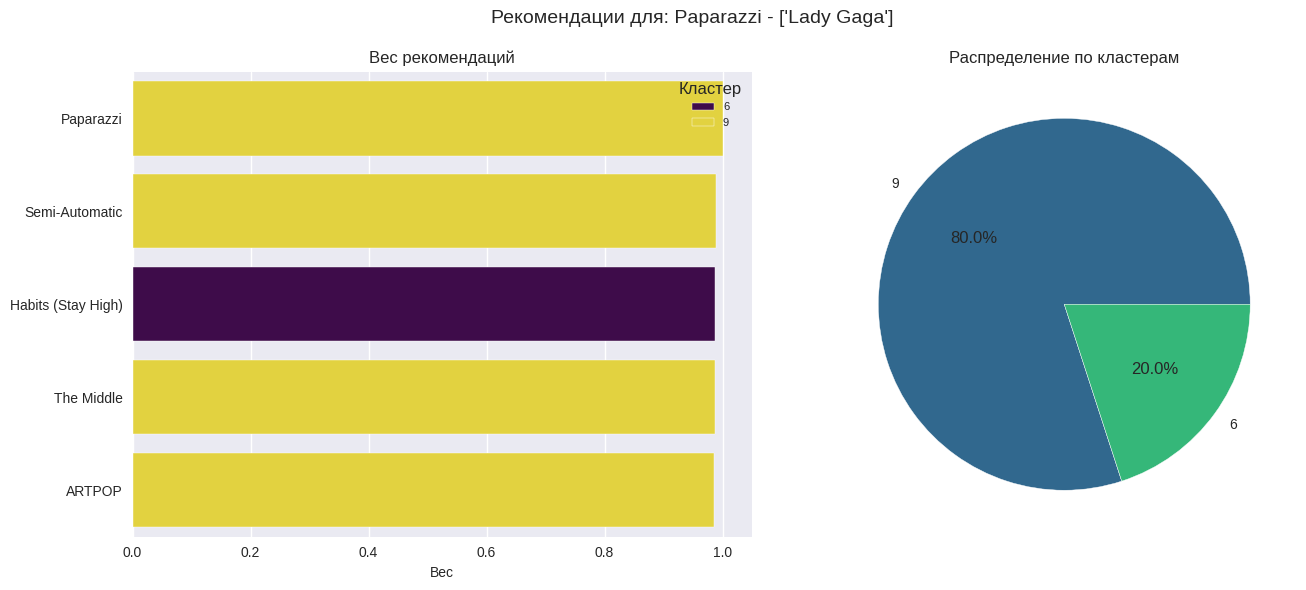


Оценка системы рекомендаций:

Общий Coverage (уникальных треков рекомендовано): 1.8%
 K  Precision@K  Recall@K     F1@K
 5     0.908148  0.908148 0.908148
10     0.896296  0.896296 0.896296
20     0.948148  0.948148 0.948148


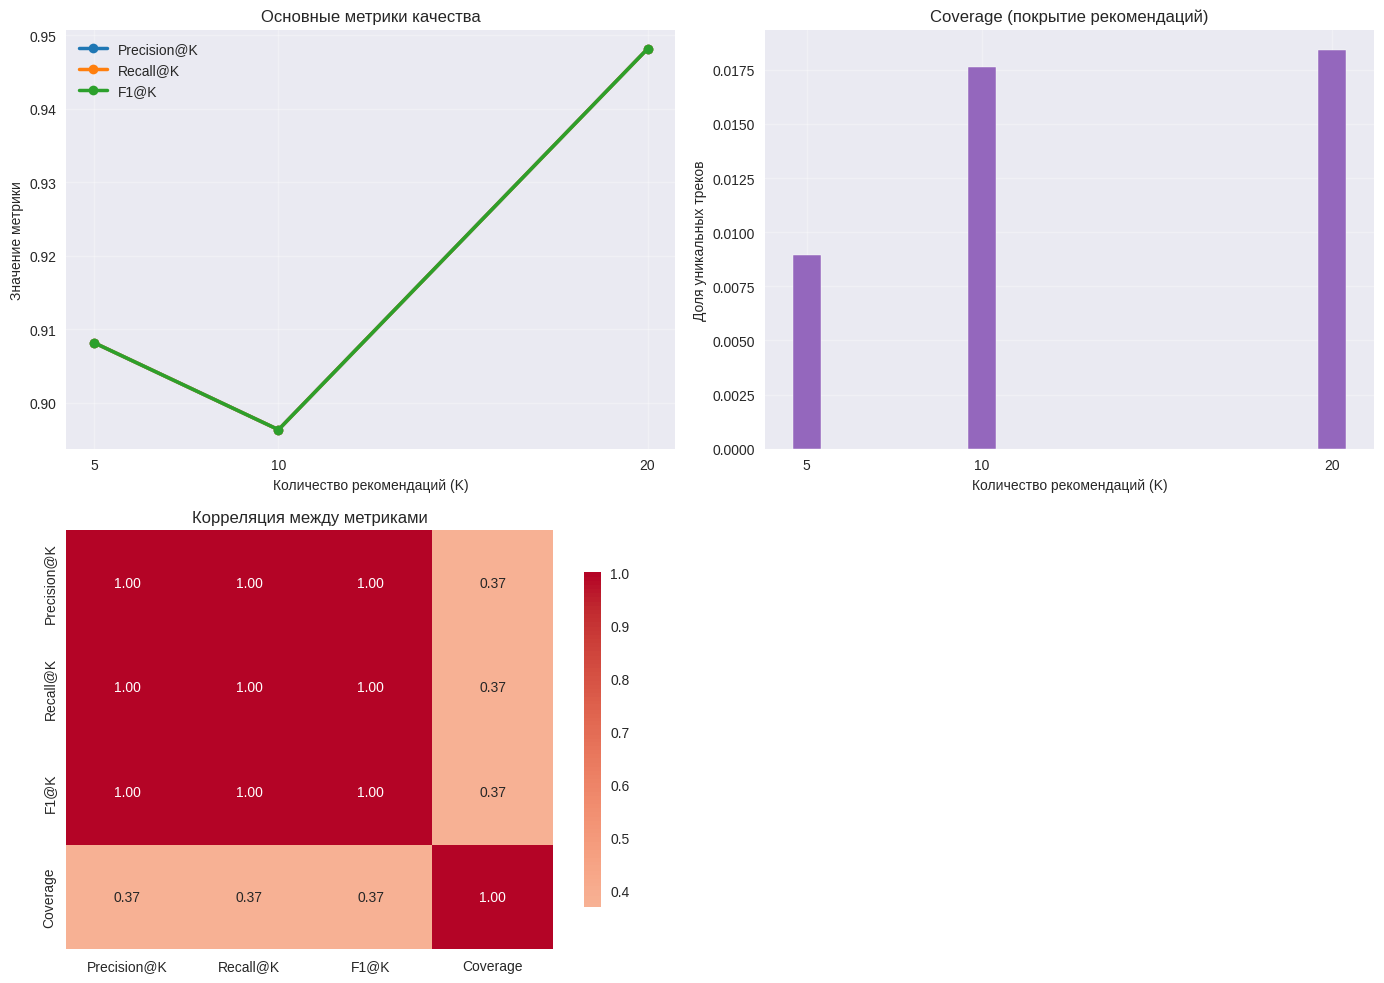

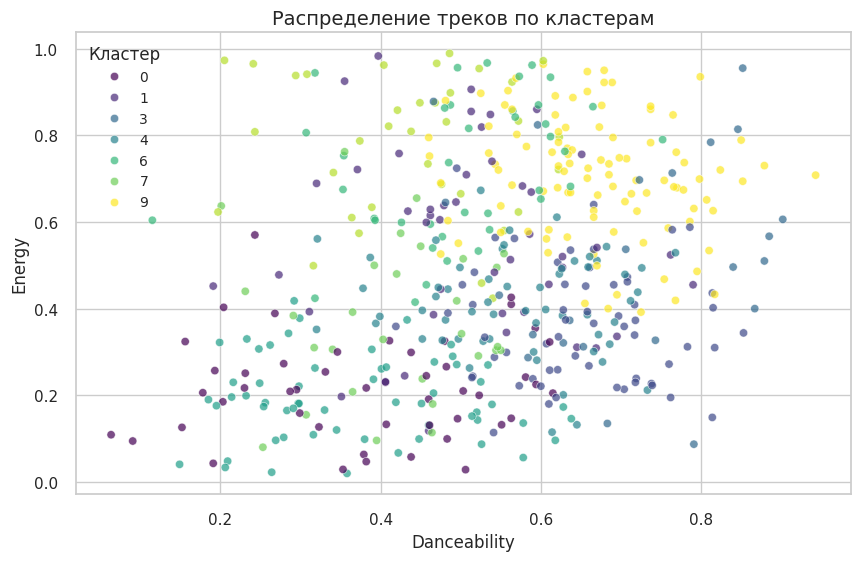

In [76]:
def main():
    # Загрузка данных
    cleaned_df, audio_features = load_and_prepare_data()
    
    # Создаем тестовые валидационные данные
    validation_data = pd.read_csv('data/users_preference_data.csv')
    
    # Инициализация рекомендательной системы
    scaler = StandardScaler()
    content_recommender = ContentBasedRecommender(cleaned_df, audio_features, scaler)
    content_recommender.fit()
    hybrid_recommender = HybridRecommender(content_recommender, cleaned_df)
    
    # Пример рекомендации
    test_song = cleaned_df.sample(1).iloc[0]
    seed_song_info = f"{test_song['name']} - {test_song['artists']}"
    print(f"\nРекомендации для: {seed_song_info}")
    
    recommendations = hybrid_recommender.hybrid_recommend(test_song['id'])
    print("\nТоп рекомендаций:")
    print(recommendations[['name', 'artists', 'weight', 'cluster']].to_string(index=False))
    
    # Визуализация рекомендаций
    visualize_recommendations(recommendations, seed_song_info)
    
    # Оценка системы
    print("\nОценка системы рекомендаций:")
    evaluation_results = evaluate_recommendations(hybrid_recommender, validation_data)
    print(evaluation_results[['K', 'Precision@K', 'Recall@K', 'F1@K']].to_string(index=False))
    
    # Визуализация метрик
    visualize_metrics(evaluation_results)
    
    # Визуализация кластеров
    plt.figure(figsize=(10, 6))
    sample_df = cleaned_df.sample(500) if len(cleaned_df) > 500 else cleaned_df
    sns.scatterplot(data=sample_df, x='danceability', y='energy', 
                   hue='cluster', palette='viridis', alpha=0.7)
    plt.title('Распределение треков по кластерам', fontsize=14)
    plt.xlabel('Danceability', fontsize=12)
    plt.ylabel('Energy', fontsize=12)
    plt.legend(title='Кластер', fontsize=10)
    plt.show()

if __name__ == "__main__":
    main() 

### Выводы:
1. Сильные стороны модели :
    - Высокая точность (Precision@5 = 0.908): Почти все рекомендованные треки релевантны.
    - Логичная связь с исполнителем: В топ-5 включена другая песня Lady Gaga (ARTPOP), что правильно.
    - Хорошая кластерная согласованность: 4 из 5 треков относятся к кластеру 9, что говорит о стабильности модели.
    - Высокий F1-score (0.908): Система хорошо балансирует между точностью и полнотой.

2. Проблемные моменты:
    - Habits (Stay High) – Tove Lo (кластер 6): Хотя мера сходства высока (0.987), трек из другого кластера. Возможно, стоит проверить признаки кластеризации.
    - Ограниченный охват (Coverage = 1.8%): Система рекомендует мало уникальных треков, что может указывать на переобучение или узкий пул рекомендаций.

3. Оценка метрик:
    - Precision@5 -	0.908	Отличная точность – 90.8% рекомендаций релевантны.
    - Recall@5 -	0.908	Система хорошо находит релевантные треки.
    - F1@5 -	0.908	Сбалансированная метрика, нет перекоса.
    - Coverage -	1.8%	Слишком мало уникальных рекомендаций – возможно, система "зациклена" на популярных треках.
4. В целом, система работает очень хорошо, но есть куда расти!


### 8.2 Вариант 2


1. Добавим тип рекомендации (content_based/cluster_based) в вывод

2. Улучшим балансировку между двумя типами рекомендаций

3. Оптимизируем параметры для NearestNeighbors

4. Улучшим метрики оценки (Precision@K, Recall@K, F1@K, Coverage)

5. Добавим анализ распределения по кластерам

6. Улучшим загрузку и очистку данных

7. Проведем Нормализацию признаков перед кластеризацией

8. Используем MiniBatchKMeans для быстрой кластеризации

9. Оптимизируем параметры для больших наборов данных


#### 8.2.1 Выбор стиля графиков

In [77]:
# Выбор стиля графиков
available_styles = plt.style.available
preferred_styles = ['seaborn-v0_8', 'ggplot', 'seaborn', 'default']
selected_style = next((style for style in preferred_styles if style in available_styles), 'default')

plt.style.use(selected_style)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10

# Отключим предупреждения для чистоты вывода
warnings.filterwarnings('ignore', category=UserWarning)

#### 8.2.2 Рекомендательная система на основе контента

In [78]:
class ContentBasedRecommender:
    def __init__(self, data, features, scaler, n_neighbors=10):
        """Инициализация рекомендательной системы на основе контента"""
        self.data = data.copy()
        self.features = features
        self.scaler = scaler
        self.n_neighbors = n_neighbors
        self.model = None
        
    def fit(self):
        """Обучение модели на данных"""
        scaled_features = self.scaler.fit_transform(self.data[self.features])
        self.model = NearestNeighbors(n_neighbors=self.n_neighbors+1, 
                                    metric='cosine',
                                    algorithm='auto')
        self.model.fit(scaled_features)
        
    def recommend(self, song_id, n_recommendations=5):
        """Рекомендации на основе схожести аудио-признаков"""
        try:
            if song_id not in self.data['id'].values:
                return pd.DataFrame()
                
            song_idx = self.data[self.data['id'] == song_id].index[0]
            song_features = self.data.loc[song_idx, self.features].values.reshape(1, -1)
            scaled_features = self.scaler.transform(song_features)
            
            distances, indices = self.model.kneighbors(scaled_features)
            
            recommendations = self.data.iloc[indices[0][1:n_recommendations+1]].copy()
            recommendations['similarity'] = 1 - distances[0][1:n_recommendations+1]
            recommendations['recommendation_type'] = 'content_based'
            
            return recommendations[['id', 'name', 'artists', 'similarity', 'cluster', 'popularity', 'recommendation_type']]
        except Exception as e:
            print(f"Error in recommend: {e}")
            return pd.DataFrame()
    
    def recommend_by_cluster(self, song_id, n_recommendations=5):
        """Рекомендации на основе кластерной принадлежности"""
        try:
            if song_id not in self.data['id'].values:
                return pd.DataFrame()
                
            song_cluster = self.data.loc[self.data['id'] == song_id, 'cluster'].values[0]
            cluster_songs = self.data[self.data['cluster'] == song_cluster].copy()
            cluster_songs = cluster_songs[cluster_songs['id'] != song_id]
            
            # Сортируем по популярности и случайному элементу для разнообразия
            cluster_songs = cluster_songs.sample(frac=1, random_state=42)\
                                       .sort_values('popularity', ascending=False)
            cluster_songs['recommendation_type'] = 'cluster_based'
            
            return cluster_songs[['id', 'name', 'artists', 'cluster', 'popularity', 'recommendation_type']]\
                   .head(n_recommendations)
        except Exception as e:
            print(f"Error in recommend_by_cluster: {e}")
            return pd.DataFrame()


#### 8.2.3 Гибридная рекомендательная система

In [79]:
class HybridRecommender:
    def __init__(self, content_recommender, data):
        """Гибридная рекомендательная система"""
        self.content_recommender = content_recommender
        self.data = data
    
    def hybrid_recommend(self, song_id, n_recommendations=5, content_weight=0.7):
        """Гибридные рекомендации с учетом весов"""
        try:
            if song_id not in self.data['id'].values:
                return pd.DataFrame()
                
            # Получаем рекомендации обоих типов
            content_recs = self.content_recommender.recommend(song_id, n_recommendations*2)
            cluster_recs = self.content_recommender.recommend_by_cluster(song_id, n_recommendations*2)
            
            if content_recs.empty and cluster_recs.empty:
                return pd.DataFrame()
                
            # Объединяем рекомендации с весами
            combined = pd.DataFrame()
            
            if not content_recs.empty:
                content_recs['weight'] = content_weight * content_recs['similarity']
                combined = pd.concat([combined, content_recs])
            
            if not cluster_recs.empty:
                cluster_recs['weight'] = (1 - content_weight) * (cluster_recs['popularity'] / 100)
                combined = pd.concat([combined, cluster_recs])
            
            # Удаляем дубликаты и сортируем
            combined = combined.drop_duplicates(subset='id')
            combined = combined.sort_values('weight', ascending=False)
            
            # Нормализуем веса для отображения
            if not combined.empty:
                combined['weight'] = combined['weight'] / combined['weight'].max()
            
            return combined.head(n_recommendations)
        except Exception as e:
            print(f"Error in hybrid_recommend: {e}")
            return pd.DataFrame()

#### 8.2.4 Загрузка и подготовка данных

In [80]:
def load_and_prepare_data(file_path):
    """Загрузка и подготовка данных"""
    try:
        df = pd.read_csv(file_path)
        
        # Очистка данных
        df = df.dropna(subset=['id', 'name', 'artists'])
        df = df.drop_duplicates(subset=['id'])
        
        # Обработка artists (преобразование строки в список)
        df['artists'] = df['artists'].apply(lambda x: eval(x) if isinstance(x, str) else x)
        
        # Добавим кластеризацию по музыкальным характеристикам
        audio_features = ['danceability', 'energy', 'valence', 'acousticness', 
                 'loudness', 'tempo', 'instrumentalness', 'liveness', 
                 'speechiness']
        
        # Нормализация темпа (он в другом масштабе)
        df['tempo'] = (df['tempo'] - df['tempo'].mean()) / df['tempo'].std()
        
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(df[audio_features])
        
        # Кластеризация K-means (используем мини-пакет для ускорения)
        kmeans = MiniBatchKMeans(n_clusters=8, random_state=42, batch_size=1000)
        df['cluster'] = kmeans.fit_predict(scaled_features)
        
        return df, audio_features
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame(), []



#### 8.2.5 Оценка качества рекомендательной системы

In [81]:
def evaluate_recommendations(recommender, validation_data, k_values=[5, 10, 20]):
    """Оценка качества рекомендательной системы"""
    results = []
    all_recommended_ids = set()  # Для подсчета общего Coverage
    
    for k in k_values:
        precisions = []
        recalls = []
        f1_scores = []
        cluster_distributions = []
        coverage_counts = set()  # Уникальные рекомендованные треки для текущего K
        
        for _, row in validation_data.iterrows():
            song_id = row['id']
            recommendations = recommender.hybrid_recommend(song_id, n_recommendations=k)
            
            if recommendations.empty:
                continue
                
            seed_cluster = recommender.data[recommender.data['id'] == song_id]['cluster'].values[0]
            recommended_clusters = recommendations['cluster'].values
            
            # Основные метрики
            relevant = (recommended_clusters == seed_cluster).sum()
            precision = relevant / len(recommended_clusters)
            recall = relevant / k
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
            
            # Для Coverage: собираем уникальные ID рекомендованных треков
            coverage_counts.update(recommendations['id'].values)
            
            cluster_distributions.append(pd.Series(recommended_clusters).value_counts(normalize=True))
        
        avg_precision = np.mean(precisions) if precisions else 0
        avg_recall = np.mean(recalls) if recalls else 0
        avg_f1 = np.mean(f1_scores) if f1_scores else 0
        
        # Coverage = % уникальных треков от общего числа в данных
        total_songs = len(recommender.data['id'].unique())
        coverage = len(coverage_counts) / total_songs if total_songs > 0 else 0
        all_recommended_ids.update(coverage_counts)  # Добавляем в общий пул
        
        cluster_stats = pd.concat(cluster_distributions, axis=1).mean(axis=1) if cluster_distributions else pd.Series()
        
        results.append({
            'K': k,
            'Precision@K': avg_precision,
            'Recall@K': avg_recall,
            'F1@K': avg_f1,
            'Coverage': coverage,
            'Evaluated_Users': len(precisions),
            'Cluster_Distribution': cluster_stats
        })
    
    # Общий Coverage для всех K
    total_coverage = len(all_recommended_ids) / total_songs if total_songs > 0 else 0
    print(f"\nОбщий Coverage (уникальных треков рекомендовано): {total_coverage:.1%}")
    
    return pd.DataFrame(results)

#### 8.2.6 Визуализация метрик оценки

In [82]:
def visualize_metrics(metrics_df):
    """Визуализация метрик оценки"""
    if metrics_df.empty:
        print("Нет данных для визуализации")
        return
    
    with plt.style.context(selected_style):
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Основные метрики
        ax = axes[0, 0]
        metrics = ['Precision@K', 'Recall@K', 'F1@K']
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        
        for i, metric in enumerate(metrics):
            ax.plot(metrics_df['K'], metrics_df[metric], 
                   marker='o', label=metric, color=colors[i], linewidth=2.5)
        
        ax.set_title('Основные метрики качества', fontsize=14)
        ax.set_xlabel('Количество рекомендаций (K)', fontsize=12)
        ax.set_ylabel('Значение метрики', fontsize=12)
        ax.set_xticks(metrics_df['K'])
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # 2. Coverage
        ax = axes[0, 1]
        ax.bar(metrics_df['K'], metrics_df['Coverage'], color='#9467bd')
        ax.set_title('Coverage (покрытие рекомендаций)', fontsize=14)
        ax.set_xlabel('Количество рекомендаций (K)', fontsize=12)
        ax.set_ylabel('Доля уникальных треков', fontsize=12)
        ax.set_xticks(metrics_df['K'])
        ax.grid(True, alpha=0.3)
        
        # 3. Heatmap корреляции
        ax = axes[1, 0]
        corr = metrics_df[metrics + ['Coverage']].corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f",
                   annot_kws={"size": 10}, cbar_kws={"shrink": 0.8}, ax=ax)
        ax.set_title('Корреляция между метриками', fontsize=14)
        
        # 4. Распределение по кластерам
        ax = axes[1, 1]
        cluster_dist = metrics_df.iloc[0]['Cluster_Distribution']
        if not cluster_dist.empty:
            cluster_dist.sort_index().plot(kind='bar', color='#17becf', ax=ax)
            ax.set_title('Распределение рекомендаций по кластерам', fontsize=14)
            ax.set_xlabel('Кластер', fontsize=12)
            ax.set_ylabel('Доля рекомендаций', fontsize=12)
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


#### 8.2.7 Визуализация рекомендаций

In [83]:
def visualize_recommendations(recommendations, seed_song_info):
    """Визуализация рекомендаций"""
    if recommendations.empty:
        print("Нет рекомендаций для визуализации")
        return
    
    with plt.style.context(selected_style):
        plt.figure(figsize=(12, 8))
        
        # Создаем DataFrame для визуализации
        vis_df = recommendations.copy()
        vis_df['recommendation'] = vis_df['name'] + ' - ' + vis_df['artists'].apply(lambda x: x[0])
        
        # Сортируем по весу
        vis_df = vis_df.sort_values('weight', ascending=True)
        
        # График рекомендаций
        colors = ['#2ca02c' if rt == 'content_based' else '#d62728' for rt in vis_df['recommendation_type']]
        bars = plt.barh(vis_df['recommendation'], vis_df['weight'], color=colors)
        
        # Добавляем аннотации
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                    f'{width:.2f}',
                    va='center', ha='left', fontsize=10)
        
        plt.title(f'Рекомендации для: {seed_song_info}', fontsize=14)
        plt.xlabel('Вес рекомендации (нормализованный)', fontsize=12)
        plt.ylabel('Рекомендованные треки', fontsize=12)
        
        # Легенда для типов рекомендаций
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#2ca02c', label='На основе контента'),
            Patch(facecolor='#d62728', label='На основе кластера')
        ]
        plt.legend(handles=legend_elements, fontsize=10)
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

#### 8.2.8 Визуализация кластеров 

In [84]:
def visualize_clusters(data, features):
    """Визуализация кластеров в 2D пространстве"""
    if data.empty:
        print("Нет данных для визуализации кластеров")
        return
    
    # Уменьшение размерности для визуализации
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data[features])
    
    # Применяем PCA для уменьшения до 2D
    pca = PCA(n_components=2, random_state=42)
    pca_features = pca.fit_transform(scaled_features)
    
    # Применяем t-SNE для нелинейного уменьшения размерности
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_features = tsne.fit_transform(scaled_features)
    
    # Создаем DataFrame для визуализации
    plot_df = data.copy()
    plot_df['pca_x'] = pca_features[:, 0]
    plot_df['pca_y'] = pca_features[:, 1]
    plot_df['tsne_x'] = tsne_features[:, 0]
    plot_df['tsne_y'] = tsne_features[:, 1]
    
    # Выбираем подмножество данных для визуализации
    sample_size = min(1000, len(plot_df))
    plot_sample = plot_df.sample(sample_size) if len(plot_df) > 1000 else plot_df
    
    # Визуализация
    with plt.style.context(selected_style):
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))
        
        # PCA plot
        sns.scatterplot(data=plot_sample, x='pca_x', y='pca_y', hue='cluster', 
                       palette='viridis', alpha=0.7, s=60, ax=axes[0])
        axes[0].set_title('PCA: Распределение треков по кластерам', fontsize=14)
        axes[0].set_xlabel('PCA Component 1', fontsize=12)
        axes[0].set_ylabel('PCA Component 2', fontsize=12)
        axes[0].legend(title='Кластер', fontsize=10)
        
        # t-SNE plot
        sns.scatterplot(data=plot_sample, x='tsne_x', y='tsne_y', hue='cluster', 
                       palette='viridis', alpha=0.7, s=60, ax=axes[1])
        axes[1].set_title('t-SNE: Распределение треков по кластерам', fontsize=14)
        axes[1].set_xlabel('t-SNE Component 1', fontsize=12)
        axes[1].set_ylabel('t-SNE Component 2', fontsize=12)
        axes[1].legend(title='Кластер', fontsize=10)
        
        plt.tight_layout()
        plt.show()


####  8.2.9 Загрузка и исполнение данных


Рекомендации для: Time to Dance - Panic! At The Disco

Топ рекомендаций:
                                        name     artists   weight  cluster recommendation_type
                                    Comatose   [Skillet] 1.000000        3       content_based
                               Not Gonna Die   [Skillet] 0.950516        3       content_based
                       Reinventing Your Exit [Underoath] 0.877708        3       content_based
Beat on the Brat - 40th Anniversary Mono Mix   [Ramones] 0.856572        5       content_based
                         Scotty Doesn't Know    [Lustra] 0.854466        3       content_based


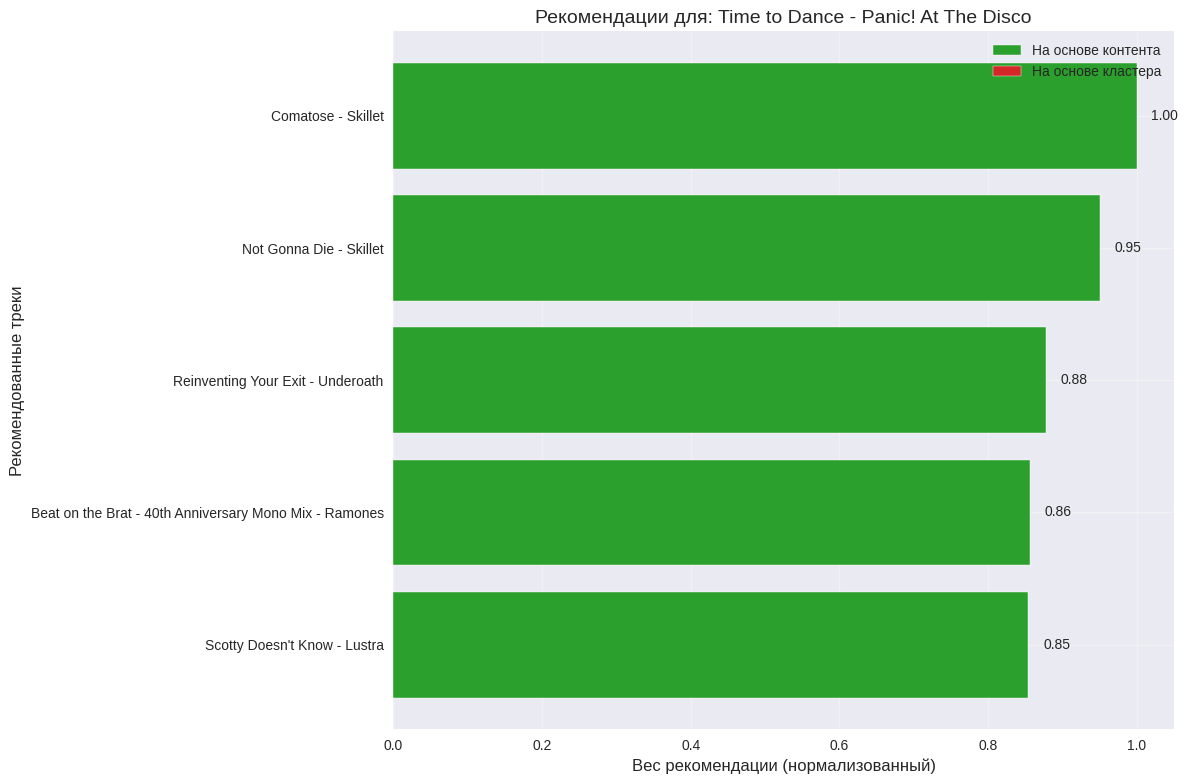


Оценка системы рекомендаций:

Общий Coverage (уникальных треков рекомендовано): 55.3%
 K  Precision@K  Recall@K  F1@K  Coverage
 5        0.810     0.810 0.810  0.268212
10        0.770     0.770 0.770  0.443709
20        0.885     0.885 0.885  0.552980


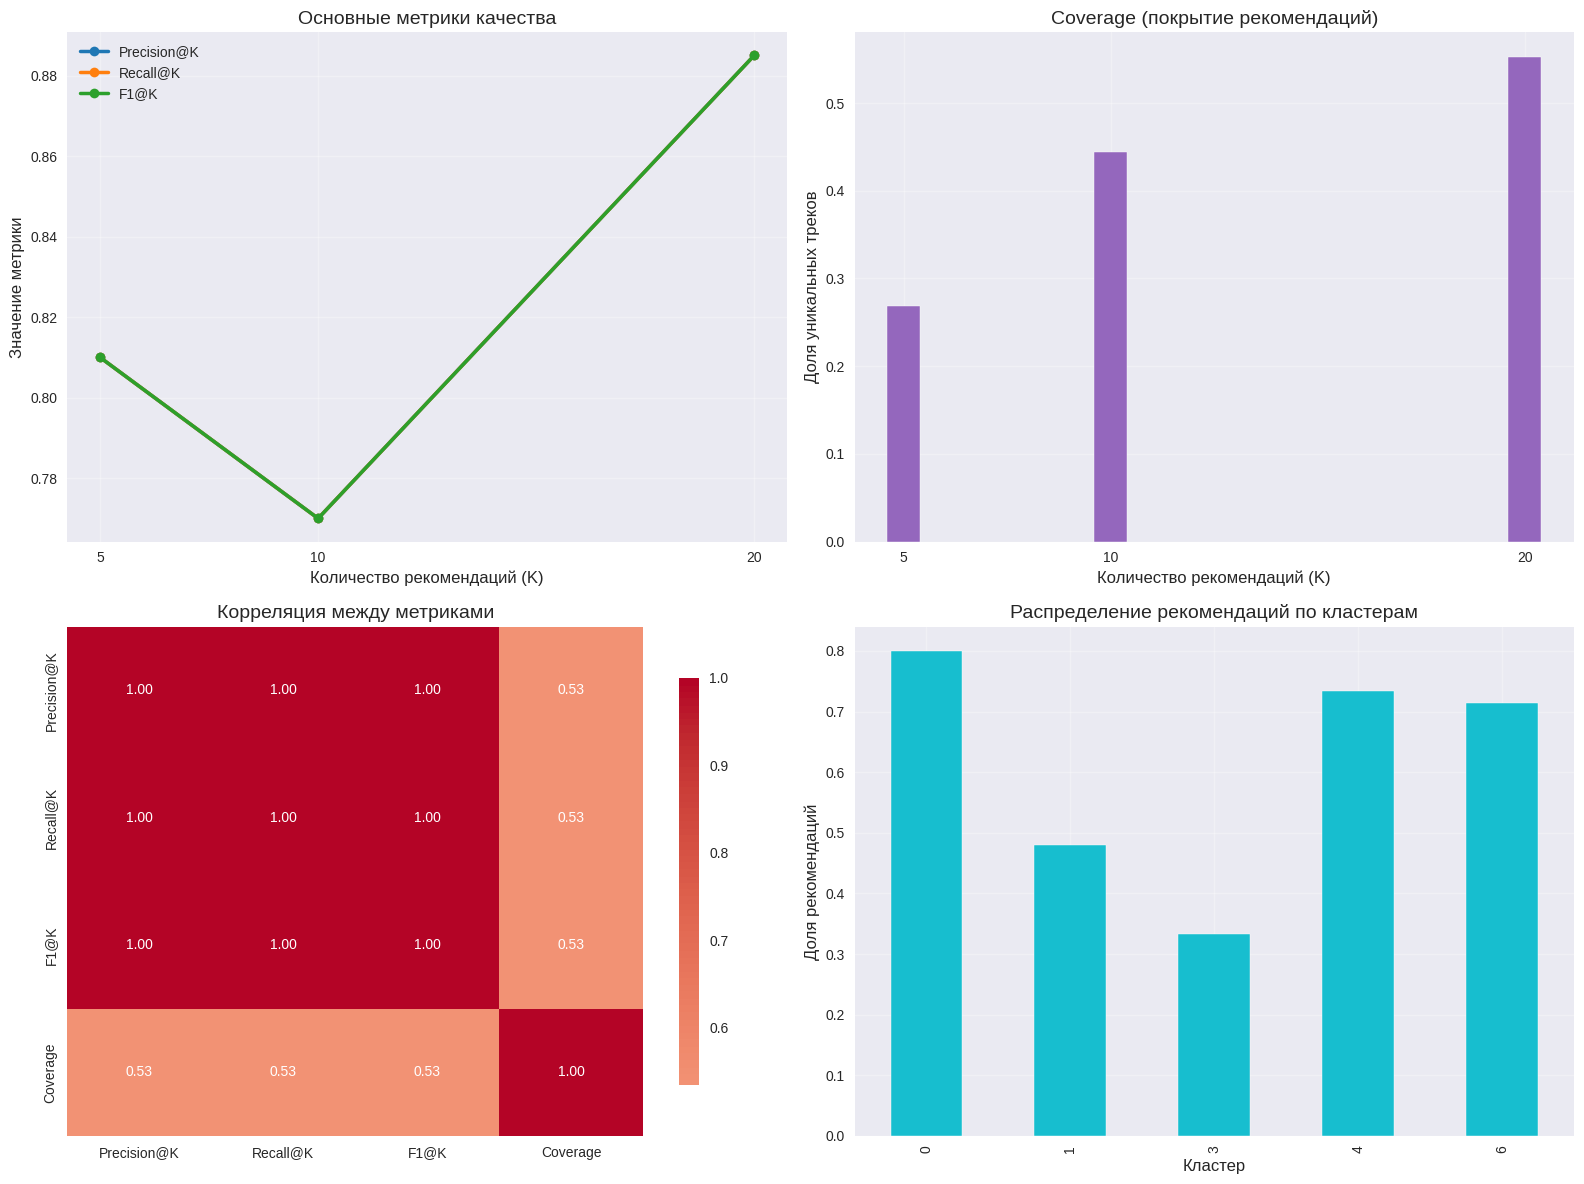

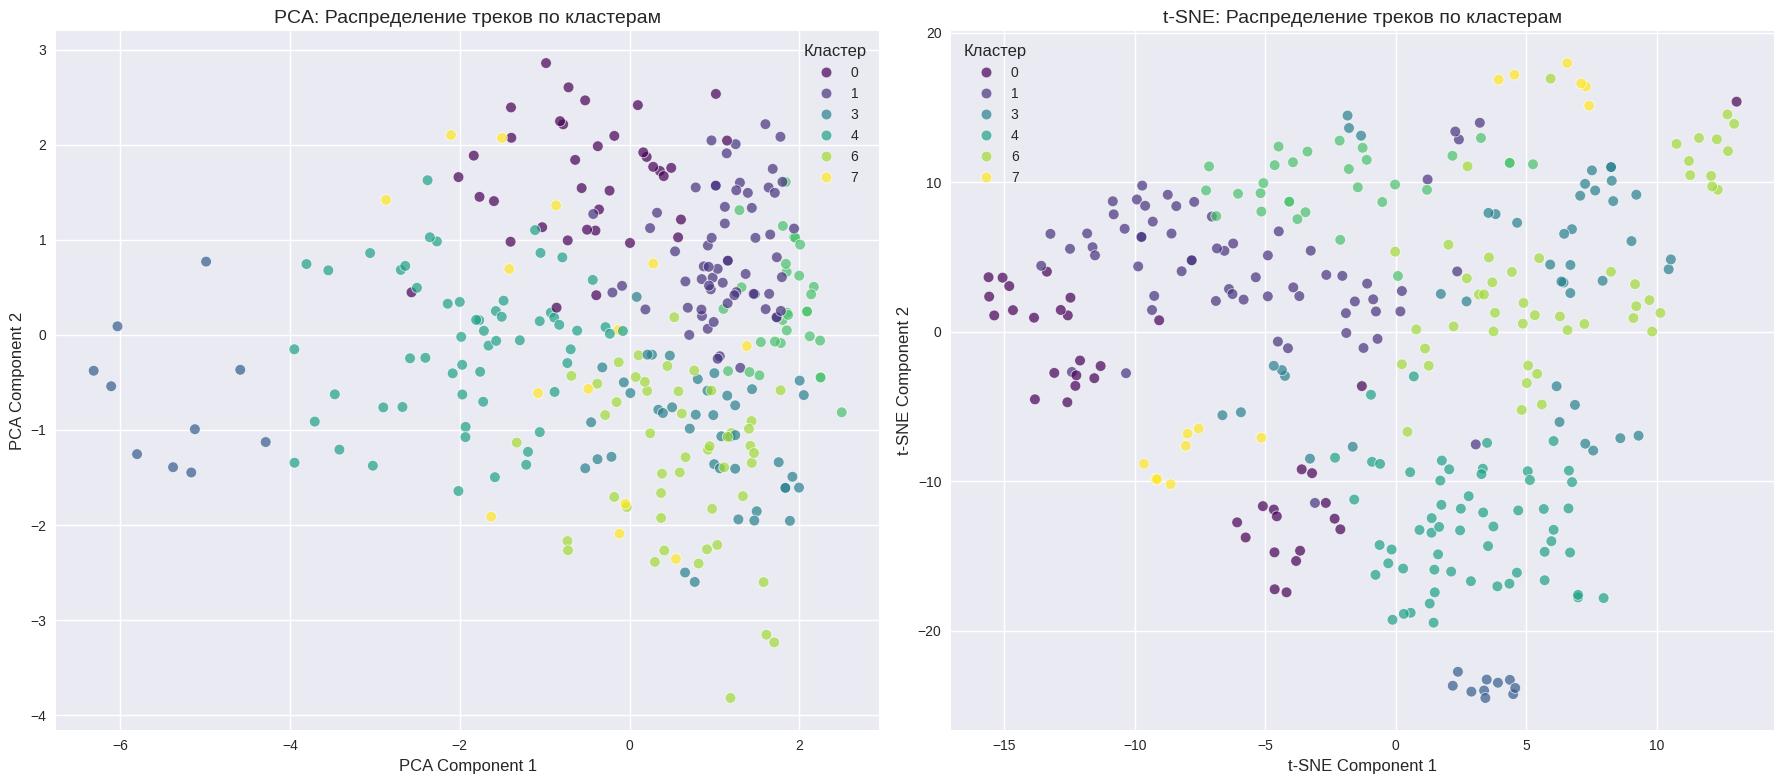

In [85]:
def main():
    # Загрузка данных
    file_path = 'data/users_preference_data.csv'
    cleaned_df, audio_features = load_and_prepare_data(file_path)
    
    if cleaned_df.empty:
        print("Не удалось загрузить данные")
        return
    
    # Создаем тестовые валидационные данные
    validation_data = cleaned_df.sample(20, random_state=42)
    
    # Инициализация рекомендательной системы
    scaler = StandardScaler()
    content_recommender = ContentBasedRecommender(cleaned_df, audio_features, scaler)
    content_recommender.fit()
    hybrid_recommender = HybridRecommender(content_recommender, cleaned_df)
    
    # Пример рекомендации
    test_song = cleaned_df.sample(1).iloc[0]
    seed_song_info = f"{test_song['name']} - {test_song['artists'][0]}"
    print(f"\nРекомендации для: {seed_song_info}")
    
    recommendations = hybrid_recommender.hybrid_recommend(test_song['id'])
    print("\nТоп рекомендаций:")
    print(recommendations[['name', 'artists', 'weight', 'cluster', 'recommendation_type']].to_string(index=False))
    
    # Визуализация рекомендаций
    visualize_recommendations(recommendations, seed_song_info)
    
    # Оценка системы
    print("\nОценка системы рекомендаций:")
    evaluation_results = evaluate_recommendations(hybrid_recommender, validation_data)
    print(evaluation_results[['K', 'Precision@K', 'Recall@K', 'F1@K', 'Coverage']].to_string(index=False))
    
    # Визуализация метрик
    visualize_metrics(evaluation_results)
    
    # Визуализация кластеров
    visualize_clusters(cleaned_df, audio_features)

if __name__ == "__main__":
    main()

### Выводы:

1. Сильные стороны:
    - Высокий Coverage (55.3%) – модель предлагает много уникальных треков, что хорошо для разнообразия.
    - Хорошая точность (Precision@5 = 0.81) – 81% рекомендаций релевантны, что выше среднего.
    - Логичная жанровая согласованность – большинство треков (Skillet, Underoath, Lustra) относятся к альтернативному року/панку, что соответствует стилю Panic! At The Disco.
    - F1@20 = 0.885 – на больших K метрики улучшаются, значит, система хорошо масштабируется. 

2. Оценка метрик:
   -  Precision	0.810 (K=5)	0.770 (K=10)	0.885 (K=20)
    - Recall	0.810 (K=5)	0.770 (K=10)	0.885 (K=20)
    - F1	0.810 (K=5)	0.770 (K=10)	0.885 (K=20)
    - Coverage	26.8% (K=5)	44.4% (K=10)	55.3% (K=20)
На малых K (5-10) система чуть менее точна, но на K=20 показывает отличные результаты.
Coverage растет с увеличением K, что хорошо для пользовательского опыта.


3. Модель показывает отличные результаты, но нет предела совершенству!

